In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "flow_ss_vcr_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM_species"
ood = "1:4"


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 333290 images
Dataset type val label type: species


Loaded 43293 images
Dataset type test label type: species


Loaded 43520 images
Dataset type test label type: species


Loaded 5270 images


In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

1:4 etvcjp2m


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_e_u = []
    trn_e_v = []
    trn_rcn = []
    trn_tgt = []

    val_inp = []
    val_e_u = []
    val_e_v = []
    val_rcn = []
    val_tgt = []

    ind_inp = []
    ind_e_u = []
    ind_e_v = []
    ind_rcn = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_e_u = []
        ood_e_v = []
        ood_rcn = []
        ood_tgt = []

    rnd_inp = []
    rnd_e_u = []
    rnd_e_v = []
    rnd_rcn = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_e_u.extend(e_u.detach().cpu().numpy())
        trn_e_v.extend(e_v.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_e_u.extend(e_u.detach().cpu().numpy())
        val_e_v.extend(e_v.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_e_u.extend(e_u.detach().cpu().numpy())
        ind_e_v.extend(e_v.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_e_u.extend(e_u.detach().cpu().numpy())
            ood_e_v.extend(e_v.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_e_u.extend(e_u.detach().cpu().numpy())
        rnd_e_v.extend(e_v.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                                                              | 0/2604 [00:00<?, ?it/s]

  0%|                                                                                                                                                      | 1/2604 [00:00<40:23,  1.07it/s]

  0%|                                                                                                                                                      | 2/2604 [00:01<20:59,  2.07it/s]

  0%|▏                                                                                                                                                     | 3/2604 [00:01<14:47,  2.93it/s]

  0%|▏                                                                                                                                                     | 4/2604 [00:01<11:52,  3.65it/s]

  0%|▎                                                                                                                                                     | 5/2604 [00:01<10:15,  4.22it/s]

  0%|▎                                                                                                                                                     | 6/2604 [00:01<09:17,  4.66it/s]

  0%|▍                                                                                                                                                     | 7/2604 [00:01<08:40,  4.99it/s]

  0%|▍                                                                                                                                                     | 8/2604 [00:02<08:16,  5.23it/s]

  0%|▌                                                                                                                                                     | 9/2604 [00:02<07:59,  5.41it/s]

  0%|▌                                                                                                                                                    | 10/2604 [00:02<07:48,  5.53it/s]

  0%|▋                                                                                                                                                    | 11/2604 [00:02<07:41,  5.62it/s]

  0%|▋                                                                                                                                                    | 12/2604 [00:02<07:36,  5.68it/s]

  0%|▋                                                                                                                                                    | 13/2604 [00:02<07:32,  5.73it/s]

  1%|▊                                                                                                                                                    | 14/2604 [00:03<07:29,  5.76it/s]

  1%|▊                                                                                                                                                    | 15/2604 [00:03<07:27,  5.78it/s]

  1%|▉                                                                                                                                                    | 16/2604 [00:03<07:27,  5.79it/s]

  1%|▉                                                                                                                                                    | 17/2604 [00:03<07:25,  5.80it/s]

  1%|█                                                                                                                                                    | 18/2604 [00:03<07:24,  5.81it/s]

  1%|█                                                                                                                                                    | 19/2604 [00:04<07:24,  5.82it/s]

  1%|█▏                                                                                                                                                   | 20/2604 [00:04<07:24,  5.82it/s]

  1%|█▏                                                                                                                                                   | 21/2604 [00:04<07:23,  5.82it/s]

  1%|█▎                                                                                                                                                   | 22/2604 [00:04<07:23,  5.82it/s]

  1%|█▎                                                                                                                                                   | 23/2604 [00:04<07:23,  5.82it/s]

  1%|█▎                                                                                                                                                   | 24/2604 [00:04<07:22,  5.83it/s]

  1%|█▍                                                                                                                                                   | 25/2604 [00:05<07:22,  5.83it/s]

  1%|█▍                                                                                                                                                   | 26/2604 [00:05<07:22,  5.83it/s]

  1%|█▌                                                                                                                                                   | 27/2604 [00:05<07:21,  5.83it/s]

  1%|█▌                                                                                                                                                   | 28/2604 [00:05<07:21,  5.83it/s]

  1%|█▋                                                                                                                                                   | 29/2604 [00:05<07:21,  5.83it/s]

  1%|█▋                                                                                                                                                   | 30/2604 [00:05<07:21,  5.83it/s]

  1%|█▊                                                                                                                                                   | 31/2604 [00:06<07:21,  5.83it/s]

  1%|█▊                                                                                                                                                   | 32/2604 [00:06<07:20,  5.84it/s]

  1%|█▉                                                                                                                                                   | 33/2604 [00:06<07:20,  5.84it/s]

  1%|█▉                                                                                                                                                   | 34/2604 [00:06<07:19,  5.85it/s]

  1%|██                                                                                                                                                   | 35/2604 [00:06<07:19,  5.85it/s]

  1%|██                                                                                                                                                   | 36/2604 [00:06<07:19,  5.85it/s]

  1%|██                                                                                                                                                   | 37/2604 [00:07<07:19,  5.84it/s]

  1%|██▏                                                                                                                                                  | 38/2604 [00:07<07:19,  5.84it/s]

  1%|██▏                                                                                                                                                  | 39/2604 [00:07<07:18,  5.84it/s]

  2%|██▎                                                                                                                                                  | 40/2604 [00:07<07:18,  5.85it/s]

  2%|██▎                                                                                                                                                  | 41/2604 [00:07<07:18,  5.84it/s]

  2%|██▍                                                                                                                                                  | 42/2604 [00:07<07:18,  5.84it/s]

  2%|██▍                                                                                                                                                  | 43/2604 [00:08<07:18,  5.84it/s]

  2%|██▌                                                                                                                                                  | 44/2604 [00:08<07:19,  5.83it/s]

  2%|██▌                                                                                                                                                  | 45/2604 [00:08<07:18,  5.83it/s]

  2%|██▋                                                                                                                                                  | 46/2604 [00:08<07:18,  5.84it/s]

  2%|██▋                                                                                                                                                  | 47/2604 [00:08<07:17,  5.84it/s]

  2%|██▋                                                                                                                                                  | 48/2604 [00:08<07:17,  5.85it/s]

  2%|██▊                                                                                                                                                  | 49/2604 [00:09<07:16,  5.85it/s]

  2%|██▊                                                                                                                                                  | 50/2604 [00:09<07:16,  5.85it/s]

  2%|██▉                                                                                                                                                  | 51/2604 [00:09<07:16,  5.85it/s]

  2%|██▉                                                                                                                                                  | 52/2604 [00:09<07:16,  5.85it/s]

  2%|███                                                                                                                                                  | 53/2604 [00:09<07:15,  5.85it/s]

  2%|███                                                                                                                                                  | 54/2604 [00:10<07:15,  5.85it/s]

  2%|███▏                                                                                                                                                 | 55/2604 [00:10<07:15,  5.85it/s]

  2%|███▏                                                                                                                                                 | 56/2604 [00:10<07:15,  5.85it/s]

  2%|███▎                                                                                                                                                 | 57/2604 [00:10<07:15,  5.85it/s]

  2%|███▎                                                                                                                                                 | 58/2604 [00:10<07:15,  5.84it/s]

  2%|███▍                                                                                                                                                 | 59/2604 [00:10<07:15,  5.85it/s]

  2%|███▍                                                                                                                                                 | 60/2604 [00:11<07:15,  5.84it/s]

  2%|███▍                                                                                                                                                 | 61/2604 [00:11<07:15,  5.84it/s]

  2%|███▌                                                                                                                                                 | 62/2604 [00:11<07:15,  5.84it/s]

  2%|███▌                                                                                                                                                 | 63/2604 [00:11<07:15,  5.84it/s]

  2%|███▋                                                                                                                                                 | 64/2604 [00:11<07:14,  5.84it/s]

  2%|███▋                                                                                                                                                 | 65/2604 [00:11<07:15,  5.84it/s]

  3%|███▊                                                                                                                                                 | 66/2604 [00:12<07:14,  5.84it/s]

  3%|███▊                                                                                                                                                 | 67/2604 [00:12<07:14,  5.84it/s]

  3%|███▉                                                                                                                                                 | 68/2604 [00:12<07:14,  5.84it/s]

  3%|███▉                                                                                                                                                 | 69/2604 [00:12<07:14,  5.84it/s]

  3%|████                                                                                                                                                 | 70/2604 [00:12<07:13,  5.84it/s]

  3%|████                                                                                                                                                 | 71/2604 [00:12<07:13,  5.84it/s]

  3%|████                                                                                                                                                 | 72/2604 [00:13<07:13,  5.84it/s]

  3%|████▏                                                                                                                                                | 73/2604 [00:13<07:13,  5.84it/s]

  3%|████▏                                                                                                                                                | 74/2604 [00:13<07:12,  5.85it/s]

  3%|████▎                                                                                                                                                | 75/2604 [00:13<07:12,  5.85it/s]

  3%|████▎                                                                                                                                                | 76/2604 [00:13<07:11,  5.85it/s]

  3%|████▍                                                                                                                                                | 77/2604 [00:13<07:11,  5.86it/s]

  3%|████▍                                                                                                                                                | 78/2604 [00:14<07:11,  5.86it/s]

  3%|████▌                                                                                                                                                | 79/2604 [00:14<07:11,  5.85it/s]

  3%|████▌                                                                                                                                                | 80/2604 [00:14<07:12,  5.84it/s]

  3%|████▋                                                                                                                                                | 81/2604 [00:14<07:11,  5.84it/s]

  3%|████▋                                                                                                                                                | 82/2604 [00:14<07:12,  5.84it/s]

  3%|████▋                                                                                                                                                | 83/2604 [00:14<07:12,  5.82it/s]

  3%|████▊                                                                                                                                                | 84/2604 [00:15<07:12,  5.82it/s]

  3%|████▊                                                                                                                                                | 85/2604 [00:15<07:12,  5.83it/s]

  3%|████▉                                                                                                                                                | 86/2604 [00:15<07:12,  5.82it/s]

  3%|████▉                                                                                                                                                | 87/2604 [00:15<07:11,  5.83it/s]

  3%|█████                                                                                                                                                | 88/2604 [00:15<07:11,  5.83it/s]

  3%|█████                                                                                                                                                | 89/2604 [00:16<07:10,  5.84it/s]

  3%|█████▏                                                                                                                                               | 90/2604 [00:16<07:10,  5.83it/s]

  3%|█████▏                                                                                                                                               | 91/2604 [00:16<07:10,  5.83it/s]

  4%|█████▎                                                                                                                                               | 92/2604 [00:16<07:10,  5.83it/s]

  4%|█████▎                                                                                                                                               | 93/2604 [00:16<07:10,  5.83it/s]

  4%|█████▍                                                                                                                                               | 94/2604 [00:16<07:10,  5.83it/s]

  4%|█████▍                                                                                                                                               | 95/2604 [00:17<07:09,  5.84it/s]

  4%|█████▍                                                                                                                                               | 96/2604 [00:17<07:09,  5.84it/s]

  4%|█████▌                                                                                                                                               | 97/2604 [00:17<07:09,  5.84it/s]

  4%|█████▌                                                                                                                                               | 98/2604 [00:17<07:09,  5.84it/s]

  4%|█████▋                                                                                                                                               | 99/2604 [00:17<07:08,  5.84it/s]

  4%|█████▋                                                                                                                                              | 100/2604 [00:17<07:09,  5.84it/s]

  4%|█████▋                                                                                                                                              | 101/2604 [00:18<07:08,  5.84it/s]

  4%|█████▊                                                                                                                                              | 102/2604 [00:18<07:08,  5.84it/s]

  4%|█████▊                                                                                                                                              | 103/2604 [00:18<07:08,  5.84it/s]

  4%|█████▉                                                                                                                                              | 104/2604 [00:18<07:08,  5.84it/s]

  4%|█████▉                                                                                                                                              | 105/2604 [00:18<07:08,  5.84it/s]

  4%|██████                                                                                                                                              | 106/2604 [00:18<07:08,  5.84it/s]

  4%|██████                                                                                                                                              | 107/2604 [00:19<07:08,  5.83it/s]

  4%|██████▏                                                                                                                                             | 108/2604 [00:19<07:08,  5.83it/s]

  4%|██████▏                                                                                                                                             | 109/2604 [00:19<07:07,  5.83it/s]

  4%|██████▎                                                                                                                                             | 110/2604 [00:19<07:07,  5.83it/s]

  4%|██████▎                                                                                                                                             | 111/2604 [00:19<07:07,  5.84it/s]

  4%|██████▎                                                                                                                                             | 112/2604 [00:19<07:07,  5.83it/s]

  4%|██████▍                                                                                                                                             | 113/2604 [00:20<07:07,  5.83it/s]

  4%|██████▍                                                                                                                                             | 114/2604 [00:20<07:07,  5.83it/s]

  4%|██████▌                                                                                                                                             | 115/2604 [00:20<07:07,  5.83it/s]

  4%|██████▌                                                                                                                                             | 116/2604 [00:20<07:06,  5.83it/s]

  4%|██████▋                                                                                                                                             | 117/2604 [00:20<07:06,  5.83it/s]

  5%|██████▋                                                                                                                                             | 118/2604 [00:20<07:05,  5.84it/s]

  5%|██████▊                                                                                                                                             | 119/2604 [00:21<07:05,  5.84it/s]

  5%|██████▊                                                                                                                                             | 120/2604 [00:21<07:05,  5.84it/s]

  5%|██████▉                                                                                                                                             | 121/2604 [00:21<07:04,  5.84it/s]

  5%|██████▉                                                                                                                                             | 122/2604 [00:21<07:04,  5.84it/s]

  5%|██████▉                                                                                                                                             | 123/2604 [00:21<07:04,  5.84it/s]

  5%|███████                                                                                                                                             | 124/2604 [00:21<07:04,  5.84it/s]

  5%|███████                                                                                                                                             | 125/2604 [00:22<07:04,  5.84it/s]

  5%|███████▏                                                                                                                                            | 126/2604 [00:22<07:03,  5.84it/s]

  5%|███████▏                                                                                                                                            | 127/2604 [00:22<07:03,  5.84it/s]

  5%|███████▎                                                                                                                                            | 128/2604 [00:22<07:04,  5.84it/s]

  5%|███████▎                                                                                                                                            | 129/2604 [00:22<07:03,  5.84it/s]

  5%|███████▍                                                                                                                                            | 130/2604 [00:23<07:03,  5.84it/s]

  5%|███████▍                                                                                                                                            | 131/2604 [00:23<07:03,  5.84it/s]

  5%|███████▌                                                                                                                                            | 132/2604 [00:23<07:03,  5.84it/s]

  5%|███████▌                                                                                                                                            | 133/2604 [00:23<07:03,  5.84it/s]

  5%|███████▌                                                                                                                                            | 134/2604 [00:23<07:03,  5.84it/s]

  5%|███████▋                                                                                                                                            | 135/2604 [00:23<07:03,  5.83it/s]

  5%|███████▋                                                                                                                                            | 136/2604 [00:24<07:03,  5.83it/s]

  5%|███████▊                                                                                                                                            | 137/2604 [00:24<07:02,  5.83it/s]

  5%|███████▊                                                                                                                                            | 138/2604 [00:24<07:02,  5.83it/s]

  5%|███████▉                                                                                                                                            | 139/2604 [00:24<07:02,  5.83it/s]

  5%|███████▉                                                                                                                                            | 140/2604 [00:24<07:02,  5.83it/s]

  5%|████████                                                                                                                                            | 141/2604 [00:24<07:02,  5.82it/s]

  5%|████████                                                                                                                                            | 142/2604 [00:25<07:03,  5.82it/s]

  5%|████████▏                                                                                                                                           | 143/2604 [00:25<07:03,  5.81it/s]

  6%|████████▏                                                                                                                                           | 144/2604 [00:25<07:03,  5.81it/s]

  6%|████████▏                                                                                                                                           | 145/2604 [00:25<07:02,  5.81it/s]

  6%|████████▎                                                                                                                                           | 146/2604 [00:25<07:02,  5.82it/s]

  6%|████████▎                                                                                                                                           | 147/2604 [00:25<07:02,  5.82it/s]

  6%|████████▍                                                                                                                                           | 148/2604 [00:26<07:01,  5.82it/s]

  6%|████████▍                                                                                                                                           | 149/2604 [00:26<07:01,  5.82it/s]

  6%|████████▌                                                                                                                                           | 150/2604 [00:26<07:01,  5.82it/s]

  6%|████████▌                                                                                                                                           | 151/2604 [00:26<07:00,  5.83it/s]

  6%|████████▋                                                                                                                                           | 152/2604 [00:26<07:00,  5.83it/s]

  6%|████████▋                                                                                                                                           | 153/2604 [00:26<07:00,  5.83it/s]

  6%|████████▊                                                                                                                                           | 154/2604 [00:27<06:59,  5.84it/s]

  6%|████████▊                                                                                                                                           | 155/2604 [00:27<06:59,  5.84it/s]

  6%|████████▊                                                                                                                                           | 156/2604 [00:27<06:59,  5.83it/s]

  6%|████████▉                                                                                                                                           | 157/2604 [00:27<06:59,  5.84it/s]

  6%|████████▉                                                                                                                                           | 158/2604 [00:27<06:58,  5.84it/s]

  6%|█████████                                                                                                                                           | 159/2604 [00:28<06:58,  5.84it/s]

  6%|█████████                                                                                                                                           | 160/2604 [00:28<06:57,  5.85it/s]

  6%|█████████▏                                                                                                                                          | 161/2604 [00:28<06:57,  5.85it/s]

  6%|█████████▏                                                                                                                                          | 162/2604 [00:28<06:57,  5.85it/s]

  6%|█████████▎                                                                                                                                          | 163/2604 [00:28<06:57,  5.84it/s]

  6%|█████████▎                                                                                                                                          | 164/2604 [00:28<06:57,  5.85it/s]

  6%|█████████▍                                                                                                                                          | 165/2604 [00:29<06:56,  5.85it/s]

  6%|█████████▍                                                                                                                                          | 166/2604 [00:29<06:56,  5.85it/s]

  6%|█████████▍                                                                                                                                          | 167/2604 [00:29<06:56,  5.85it/s]

  6%|█████████▌                                                                                                                                          | 168/2604 [00:29<06:56,  5.85it/s]

  6%|█████████▌                                                                                                                                          | 169/2604 [00:29<06:56,  5.84it/s]

  7%|█████████▋                                                                                                                                          | 170/2604 [00:29<06:56,  5.84it/s]

  7%|█████████▋                                                                                                                                          | 171/2604 [00:30<06:55,  5.86it/s]

  7%|█████████▊                                                                                                                                          | 172/2604 [00:30<06:54,  5.86it/s]

  7%|█████████▊                                                                                                                                          | 173/2604 [00:30<06:54,  5.87it/s]

  7%|█████████▉                                                                                                                                          | 174/2604 [00:30<06:53,  5.88it/s]

  7%|█████████▉                                                                                                                                          | 175/2604 [00:30<06:52,  5.88it/s]

  7%|██████████                                                                                                                                          | 176/2604 [00:30<06:52,  5.89it/s]

  7%|██████████                                                                                                                                          | 177/2604 [00:31<06:52,  5.88it/s]

  7%|██████████                                                                                                                                          | 178/2604 [00:31<06:53,  5.86it/s]

  7%|██████████▏                                                                                                                                         | 179/2604 [00:31<06:54,  5.85it/s]

  7%|██████████▏                                                                                                                                         | 180/2604 [00:31<06:54,  5.85it/s]

  7%|██████████▎                                                                                                                                         | 181/2604 [00:31<06:54,  5.84it/s]

  7%|██████████▎                                                                                                                                         | 182/2604 [00:31<06:54,  5.84it/s]

  7%|██████████▍                                                                                                                                         | 183/2604 [00:32<06:54,  5.84it/s]

  7%|██████████▍                                                                                                                                         | 184/2604 [00:32<06:54,  5.83it/s]

  7%|██████████▌                                                                                                                                         | 185/2604 [00:32<06:54,  5.84it/s]

  7%|██████████▌                                                                                                                                         | 186/2604 [00:32<06:54,  5.84it/s]

  7%|██████████▋                                                                                                                                         | 187/2604 [00:32<06:53,  5.84it/s]

  7%|██████████▋                                                                                                                                         | 188/2604 [00:32<06:53,  5.84it/s]

  7%|██████████▋                                                                                                                                         | 189/2604 [00:33<06:53,  5.84it/s]

  7%|██████████▊                                                                                                                                         | 190/2604 [00:33<06:53,  5.84it/s]

  7%|██████████▊                                                                                                                                         | 191/2604 [00:33<06:53,  5.83it/s]

  7%|██████████▉                                                                                                                                         | 192/2604 [00:33<06:53,  5.84it/s]

  7%|██████████▉                                                                                                                                         | 193/2604 [00:33<06:53,  5.84it/s]

  7%|███████████                                                                                                                                         | 194/2604 [00:33<06:52,  5.84it/s]

  7%|███████████                                                                                                                                         | 195/2604 [00:34<06:52,  5.83it/s]

  8%|███████████▏                                                                                                                                        | 196/2604 [00:34<06:52,  5.83it/s]

  8%|███████████▏                                                                                                                                        | 197/2604 [00:34<06:52,  5.83it/s]

  8%|███████████▎                                                                                                                                        | 198/2604 [00:34<06:53,  5.82it/s]

  8%|███████████▎                                                                                                                                        | 199/2604 [00:34<06:52,  5.83it/s]

  8%|███████████▎                                                                                                                                        | 200/2604 [00:35<06:52,  5.83it/s]

  8%|███████████▍                                                                                                                                        | 201/2604 [00:35<06:51,  5.83it/s]

  8%|███████████▍                                                                                                                                        | 202/2604 [00:35<06:51,  5.84it/s]

  8%|███████████▌                                                                                                                                        | 203/2604 [00:35<06:51,  5.84it/s]

  8%|███████████▌                                                                                                                                        | 204/2604 [00:35<06:51,  5.84it/s]

  8%|███████████▋                                                                                                                                        | 205/2604 [00:35<06:51,  5.83it/s]

  8%|███████████▋                                                                                                                                        | 206/2604 [00:36<06:51,  5.83it/s]

  8%|███████████▊                                                                                                                                        | 207/2604 [00:36<06:51,  5.83it/s]

  8%|███████████▊                                                                                                                                        | 208/2604 [00:36<06:50,  5.83it/s]

  8%|███████████▉                                                                                                                                        | 209/2604 [00:36<06:50,  5.84it/s]

  8%|███████████▉                                                                                                                                        | 210/2604 [00:36<06:50,  5.84it/s]

  8%|███████████▉                                                                                                                                        | 211/2604 [00:36<06:49,  5.84it/s]

  8%|████████████                                                                                                                                        | 212/2604 [00:37<06:50,  5.83it/s]

  8%|████████████                                                                                                                                        | 213/2604 [00:37<06:50,  5.83it/s]

  8%|████████████▏                                                                                                                                       | 214/2604 [00:37<06:51,  5.81it/s]

  8%|████████████▏                                                                                                                                       | 215/2604 [00:37<06:51,  5.81it/s]

  8%|████████████▎                                                                                                                                       | 216/2604 [00:37<06:51,  5.81it/s]

  8%|████████████▎                                                                                                                                       | 217/2604 [00:37<06:50,  5.81it/s]

  8%|████████████▍                                                                                                                                       | 218/2604 [00:38<06:50,  5.82it/s]

  8%|████████████▍                                                                                                                                       | 219/2604 [00:38<06:50,  5.81it/s]

  8%|████████████▌                                                                                                                                       | 220/2604 [00:38<06:49,  5.82it/s]

  8%|████████████▌                                                                                                                                       | 221/2604 [00:38<06:49,  5.82it/s]

  9%|████████████▌                                                                                                                                       | 222/2604 [00:38<06:49,  5.82it/s]

  9%|████████████▋                                                                                                                                       | 223/2604 [00:38<06:49,  5.82it/s]

  9%|████████████▋                                                                                                                                       | 224/2604 [00:39<06:49,  5.82it/s]

  9%|████████████▊                                                                                                                                       | 225/2604 [00:39<06:49,  5.82it/s]

  9%|████████████▊                                                                                                                                       | 226/2604 [00:39<06:49,  5.81it/s]

  9%|████████████▉                                                                                                                                       | 227/2604 [00:39<06:48,  5.82it/s]

  9%|████████████▉                                                                                                                                       | 228/2604 [00:39<06:47,  5.83it/s]

  9%|█████████████                                                                                                                                       | 229/2604 [00:39<06:47,  5.84it/s]

  9%|█████████████                                                                                                                                       | 230/2604 [00:40<06:46,  5.84it/s]

  9%|█████████████▏                                                                                                                                      | 231/2604 [00:40<06:46,  5.84it/s]

  9%|█████████████▏                                                                                                                                      | 232/2604 [00:40<06:45,  5.85it/s]

  9%|█████████████▏                                                                                                                                      | 233/2604 [00:40<06:45,  5.84it/s]

  9%|█████████████▎                                                                                                                                      | 234/2604 [00:40<06:45,  5.84it/s]

  9%|█████████████▎                                                                                                                                      | 235/2604 [00:41<06:45,  5.84it/s]

  9%|█████████████▍                                                                                                                                      | 236/2604 [00:41<06:45,  5.84it/s]

  9%|█████████████▍                                                                                                                                      | 237/2604 [00:41<06:45,  5.84it/s]

  9%|█████████████▌                                                                                                                                      | 238/2604 [00:41<06:44,  5.84it/s]

  9%|█████████████▌                                                                                                                                      | 239/2604 [00:41<06:44,  5.85it/s]

  9%|█████████████▋                                                                                                                                      | 240/2604 [00:41<06:44,  5.84it/s]

  9%|█████████████▋                                                                                                                                      | 241/2604 [00:42<06:44,  5.84it/s]

  9%|█████████████▊                                                                                                                                      | 242/2604 [00:42<06:44,  5.84it/s]

  9%|█████████████▊                                                                                                                                      | 243/2604 [00:42<06:43,  5.85it/s]

  9%|█████████████▊                                                                                                                                      | 244/2604 [00:42<06:44,  5.84it/s]

  9%|█████████████▉                                                                                                                                      | 245/2604 [00:42<06:44,  5.83it/s]

  9%|█████████████▉                                                                                                                                      | 246/2604 [00:42<06:44,  5.83it/s]

  9%|██████████████                                                                                                                                      | 247/2604 [00:43<06:45,  5.82it/s]

 10%|██████████████                                                                                                                                      | 248/2604 [00:43<06:44,  5.82it/s]

 10%|██████████████▏                                                                                                                                     | 249/2604 [00:43<06:44,  5.82it/s]

 10%|██████████████▏                                                                                                                                     | 250/2604 [00:43<06:44,  5.81it/s]

 10%|██████████████▎                                                                                                                                     | 251/2604 [00:43<06:44,  5.82it/s]

 10%|██████████████▎                                                                                                                                     | 252/2604 [00:43<06:43,  5.82it/s]

 10%|██████████████▍                                                                                                                                     | 253/2604 [00:44<06:43,  5.82it/s]

 10%|██████████████▍                                                                                                                                     | 254/2604 [00:44<06:43,  5.82it/s]

 10%|██████████████▍                                                                                                                                     | 255/2604 [00:44<06:42,  5.83it/s]

 10%|██████████████▌                                                                                                                                     | 256/2604 [00:44<06:42,  5.83it/s]

 10%|██████████████▌                                                                                                                                     | 257/2604 [00:44<06:42,  5.83it/s]

 10%|██████████████▋                                                                                                                                     | 258/2604 [00:44<06:42,  5.83it/s]

 10%|██████████████▋                                                                                                                                     | 259/2604 [00:45<06:41,  5.84it/s]

 10%|██████████████▊                                                                                                                                     | 260/2604 [00:45<06:41,  5.84it/s]

 10%|██████████████▊                                                                                                                                     | 261/2604 [00:45<06:41,  5.84it/s]

 10%|██████████████▉                                                                                                                                     | 262/2604 [00:45<06:40,  5.84it/s]

 10%|██████████████▉                                                                                                                                     | 263/2604 [00:45<06:41,  5.83it/s]

 10%|███████████████                                                                                                                                     | 264/2604 [00:45<06:41,  5.83it/s]

 10%|███████████████                                                                                                                                     | 265/2604 [00:46<06:41,  5.83it/s]

 10%|███████████████                                                                                                                                     | 266/2604 [00:46<06:41,  5.83it/s]

 10%|███████████████▏                                                                                                                                    | 267/2604 [00:46<06:40,  5.83it/s]

 10%|███████████████▏                                                                                                                                    | 268/2604 [00:46<06:40,  5.83it/s]

 10%|███████████████▎                                                                                                                                    | 269/2604 [00:46<06:40,  5.83it/s]

 10%|███████████████▎                                                                                                                                    | 270/2604 [00:47<06:40,  5.83it/s]

 10%|███████████████▍                                                                                                                                    | 271/2604 [00:47<06:40,  5.83it/s]

 10%|███████████████▍                                                                                                                                    | 272/2604 [00:47<06:40,  5.83it/s]

 10%|███████████████▌                                                                                                                                    | 273/2604 [00:47<06:40,  5.83it/s]

 11%|███████████████▌                                                                                                                                    | 274/2604 [00:47<06:39,  5.83it/s]

 11%|███████████████▋                                                                                                                                    | 275/2604 [00:47<06:39,  5.83it/s]

 11%|███████████████▋                                                                                                                                    | 276/2604 [00:48<06:39,  5.83it/s]

 11%|███████████████▋                                                                                                                                    | 277/2604 [00:48<06:38,  5.83it/s]

 11%|███████████████▊                                                                                                                                    | 278/2604 [00:48<06:38,  5.83it/s]

 11%|███████████████▊                                                                                                                                    | 279/2604 [00:48<06:38,  5.83it/s]

 11%|███████████████▉                                                                                                                                    | 280/2604 [00:48<06:38,  5.83it/s]

 11%|███████████████▉                                                                                                                                    | 281/2604 [00:48<06:38,  5.83it/s]

 11%|████████████████                                                                                                                                    | 282/2604 [00:49<06:38,  5.82it/s]

 11%|████████████████                                                                                                                                    | 283/2604 [00:49<06:38,  5.82it/s]

 11%|████████████████▏                                                                                                                                   | 284/2604 [00:49<06:38,  5.82it/s]

 11%|████████████████▏                                                                                                                                   | 285/2604 [00:49<06:38,  5.83it/s]

 11%|████████████████▎                                                                                                                                   | 286/2604 [00:49<06:37,  5.83it/s]

 11%|████████████████▎                                                                                                                                   | 287/2604 [00:49<06:37,  5.83it/s]

 11%|████████████████▎                                                                                                                                   | 288/2604 [00:50<06:37,  5.83it/s]

 11%|████████████████▍                                                                                                                                   | 289/2604 [00:50<06:36,  5.83it/s]

 11%|████████████████▍                                                                                                                                   | 290/2604 [00:50<06:36,  5.83it/s]

 11%|████████████████▌                                                                                                                                   | 291/2604 [00:50<06:37,  5.82it/s]

 11%|████████████████▌                                                                                                                                   | 292/2604 [00:50<06:36,  5.84it/s]

 11%|████████████████▋                                                                                                                                   | 293/2604 [00:50<06:35,  5.85it/s]

 11%|████████████████▋                                                                                                                                   | 294/2604 [00:51<06:34,  5.86it/s]

 11%|████████████████▊                                                                                                                                   | 295/2604 [00:51<06:33,  5.87it/s]

 11%|████████████████▊                                                                                                                                   | 296/2604 [00:51<06:32,  5.87it/s]

 11%|████████████████▉                                                                                                                                   | 297/2604 [00:51<06:33,  5.86it/s]

 11%|████████████████▉                                                                                                                                   | 298/2604 [00:51<06:34,  5.85it/s]

 11%|████████████████▉                                                                                                                                   | 299/2604 [00:51<06:34,  5.84it/s]

 12%|█████████████████                                                                                                                                   | 300/2604 [00:52<06:35,  5.83it/s]

 12%|█████████████████                                                                                                                                   | 301/2604 [00:52<06:35,  5.83it/s]

 12%|█████████████████▏                                                                                                                                  | 302/2604 [00:52<06:35,  5.83it/s]

 12%|█████████████████▏                                                                                                                                  | 303/2604 [00:52<06:34,  5.83it/s]

 12%|█████████████████▎                                                                                                                                  | 304/2604 [00:52<06:35,  5.82it/s]

 12%|█████████████████▎                                                                                                                                  | 305/2604 [00:53<06:34,  5.83it/s]

 12%|█████████████████▍                                                                                                                                  | 306/2604 [00:53<06:34,  5.83it/s]

 12%|█████████████████▍                                                                                                                                  | 307/2604 [00:53<06:33,  5.83it/s]

 12%|█████████████████▌                                                                                                                                  | 308/2604 [00:53<06:33,  5.84it/s]

 12%|█████████████████▌                                                                                                                                  | 309/2604 [00:53<06:33,  5.84it/s]

 12%|█████████████████▌                                                                                                                                  | 310/2604 [00:53<06:33,  5.84it/s]

 12%|█████████████████▋                                                                                                                                  | 311/2604 [00:54<06:33,  5.83it/s]

 12%|█████████████████▋                                                                                                                                  | 312/2604 [00:54<06:33,  5.83it/s]

 12%|█████████████████▊                                                                                                                                  | 313/2604 [00:54<06:32,  5.83it/s]

 12%|█████████████████▊                                                                                                                                  | 314/2604 [00:54<06:33,  5.82it/s]

 12%|█████████████████▉                                                                                                                                  | 315/2604 [00:54<06:33,  5.82it/s]

 12%|█████████████████▉                                                                                                                                  | 316/2604 [00:54<06:33,  5.82it/s]

 12%|██████████████████                                                                                                                                  | 317/2604 [00:55<06:33,  5.82it/s]

 12%|██████████████████                                                                                                                                  | 318/2604 [00:55<06:32,  5.83it/s]

 12%|██████████████████▏                                                                                                                                 | 319/2604 [00:55<06:31,  5.83it/s]

 12%|██████████████████▏                                                                                                                                 | 320/2604 [00:55<06:31,  5.83it/s]

 12%|██████████████████▏                                                                                                                                 | 321/2604 [00:55<06:31,  5.83it/s]

 12%|██████████████████▎                                                                                                                                 | 322/2604 [00:55<06:31,  5.83it/s]

 12%|██████████████████▎                                                                                                                                 | 323/2604 [00:56<06:31,  5.83it/s]

 12%|██████████████████▍                                                                                                                                 | 324/2604 [00:56<06:31,  5.82it/s]

 12%|██████████████████▍                                                                                                                                 | 325/2604 [00:56<06:31,  5.82it/s]

 13%|██████████████████▌                                                                                                                                 | 326/2604 [00:56<06:31,  5.82it/s]

 13%|██████████████████▌                                                                                                                                 | 327/2604 [00:56<06:30,  5.83it/s]

 13%|██████████████████▋                                                                                                                                 | 328/2604 [00:56<06:30,  5.83it/s]

 13%|██████████████████▋                                                                                                                                 | 329/2604 [00:57<06:30,  5.83it/s]

 13%|██████████████████▊                                                                                                                                 | 330/2604 [00:57<06:30,  5.83it/s]

 13%|██████████████████▊                                                                                                                                 | 331/2604 [00:57<06:30,  5.82it/s]

 13%|██████████████████▊                                                                                                                                 | 332/2604 [00:57<06:30,  5.82it/s]

 13%|██████████████████▉                                                                                                                                 | 333/2604 [00:57<06:30,  5.82it/s]

 13%|██████████████████▉                                                                                                                                 | 334/2604 [00:57<06:29,  5.83it/s]

 13%|███████████████████                                                                                                                                 | 335/2604 [00:58<06:29,  5.83it/s]

 13%|███████████████████                                                                                                                                 | 336/2604 [00:58<06:29,  5.83it/s]

 13%|███████████████████▏                                                                                                                                | 337/2604 [00:58<06:28,  5.83it/s]

 13%|███████████████████▏                                                                                                                                | 338/2604 [00:58<06:29,  5.82it/s]

 13%|███████████████████▎                                                                                                                                | 339/2604 [00:58<06:28,  5.83it/s]

 13%|███████████████████▎                                                                                                                                | 340/2604 [00:59<06:28,  5.83it/s]

 13%|███████████████████▍                                                                                                                                | 341/2604 [00:59<06:28,  5.83it/s]

 13%|███████████████████▍                                                                                                                                | 342/2604 [00:59<06:28,  5.83it/s]

 13%|███████████████████▍                                                                                                                                | 343/2604 [00:59<06:28,  5.83it/s]

 13%|███████████████████▌                                                                                                                                | 344/2604 [00:59<06:27,  5.83it/s]

 13%|███████████████████▌                                                                                                                                | 345/2604 [00:59<06:27,  5.83it/s]

 13%|███████████████████▋                                                                                                                                | 346/2604 [01:00<06:26,  5.85it/s]

 13%|███████████████████▋                                                                                                                                | 347/2604 [01:00<06:25,  5.86it/s]

 13%|███████████████████▊                                                                                                                                | 348/2604 [01:00<06:24,  5.86it/s]

 13%|███████████████████▊                                                                                                                                | 349/2604 [01:00<06:24,  5.87it/s]

 13%|███████████████████▉                                                                                                                                | 350/2604 [01:00<06:24,  5.87it/s]

 13%|███████████████████▉                                                                                                                                | 351/2604 [01:00<06:23,  5.87it/s]

 14%|████████████████████                                                                                                                                | 352/2604 [01:01<06:24,  5.86it/s]

 14%|████████████████████                                                                                                                                | 353/2604 [01:01<06:24,  5.85it/s]

 14%|████████████████████                                                                                                                                | 354/2604 [01:01<06:25,  5.84it/s]

 14%|████████████████████▏                                                                                                                               | 355/2604 [01:01<06:25,  5.84it/s]

 14%|████████████████████▏                                                                                                                               | 356/2604 [01:01<06:25,  5.83it/s]

 14%|████████████████████▎                                                                                                                               | 357/2604 [01:01<06:26,  5.82it/s]

 14%|████████████████████▎                                                                                                                               | 358/2604 [01:02<06:25,  5.82it/s]

 14%|████████████████████▍                                                                                                                               | 359/2604 [01:02<06:25,  5.82it/s]

 14%|████████████████████▍                                                                                                                               | 360/2604 [01:02<06:25,  5.83it/s]

 14%|████████████████████▌                                                                                                                               | 361/2604 [01:02<06:24,  5.83it/s]

 14%|████████████████████▌                                                                                                                               | 362/2604 [01:02<06:24,  5.83it/s]

 14%|████████████████████▋                                                                                                                               | 363/2604 [01:02<06:24,  5.83it/s]

 14%|████████████████████▋                                                                                                                               | 364/2604 [01:03<06:24,  5.83it/s]

 14%|████████████████████▋                                                                                                                               | 365/2604 [01:03<06:24,  5.83it/s]

 14%|████████████████████▊                                                                                                                               | 366/2604 [01:03<06:24,  5.83it/s]

 14%|████████████████████▊                                                                                                                               | 367/2604 [01:03<06:23,  5.83it/s]

 14%|████████████████████▉                                                                                                                               | 368/2604 [01:03<06:23,  5.83it/s]

 14%|████████████████████▉                                                                                                                               | 369/2604 [01:03<06:23,  5.83it/s]

 14%|█████████████████████                                                                                                                               | 370/2604 [01:04<06:23,  5.83it/s]

 14%|█████████████████████                                                                                                                               | 371/2604 [01:04<06:23,  5.83it/s]

 14%|█████████████████████▏                                                                                                                              | 372/2604 [01:04<06:23,  5.82it/s]

 14%|█████████████████████▏                                                                                                                              | 373/2604 [01:04<06:22,  5.83it/s]

 14%|█████████████████████▎                                                                                                                              | 374/2604 [01:04<06:22,  5.83it/s]

 14%|█████████████████████▎                                                                                                                              | 375/2604 [01:05<06:22,  5.83it/s]

 14%|█████████████████████▎                                                                                                                              | 376/2604 [01:05<06:22,  5.83it/s]

 14%|█████████████████████▍                                                                                                                              | 377/2604 [01:05<06:22,  5.82it/s]

 15%|█████████████████████▍                                                                                                                              | 378/2604 [01:05<06:22,  5.82it/s]

 15%|█████████████████████▌                                                                                                                              | 379/2604 [01:05<06:22,  5.81it/s]

 15%|█████████████████████▌                                                                                                                              | 380/2604 [01:05<06:22,  5.82it/s]

 15%|█████████████████████▋                                                                                                                              | 381/2604 [01:06<06:21,  5.82it/s]

 15%|█████████████████████▋                                                                                                                              | 382/2604 [01:06<06:21,  5.82it/s]

 15%|█████████████████████▊                                                                                                                              | 383/2604 [01:06<06:21,  5.83it/s]

 15%|█████████████████████▊                                                                                                                              | 384/2604 [01:06<06:20,  5.83it/s]

 15%|█████████████████████▉                                                                                                                              | 385/2604 [01:06<06:20,  5.83it/s]

 15%|█████████████████████▉                                                                                                                              | 386/2604 [01:06<06:20,  5.83it/s]

 15%|█████████████████████▉                                                                                                                              | 387/2604 [01:07<06:20,  5.83it/s]

 15%|██████████████████████                                                                                                                              | 388/2604 [01:07<06:20,  5.83it/s]

 15%|██████████████████████                                                                                                                              | 389/2604 [01:07<06:19,  5.83it/s]

 15%|██████████████████████▏                                                                                                                             | 390/2604 [01:07<06:19,  5.83it/s]

 15%|██████████████████████▏                                                                                                                             | 391/2604 [01:07<06:19,  5.83it/s]

 15%|██████████████████████▎                                                                                                                             | 392/2604 [01:07<06:19,  5.83it/s]

 15%|██████████████████████▎                                                                                                                             | 393/2604 [01:08<06:19,  5.83it/s]

 15%|██████████████████████▍                                                                                                                             | 394/2604 [01:08<06:19,  5.83it/s]

 15%|██████████████████████▍                                                                                                                             | 395/2604 [01:08<06:18,  5.83it/s]

 15%|██████████████████████▌                                                                                                                             | 396/2604 [01:08<06:18,  5.83it/s]

 15%|██████████████████████▌                                                                                                                             | 397/2604 [01:08<06:18,  5.83it/s]

 15%|██████████████████████▌                                                                                                                             | 398/2604 [01:08<06:18,  5.83it/s]

 15%|██████████████████████▋                                                                                                                             | 399/2604 [01:09<06:18,  5.83it/s]

 15%|██████████████████████▋                                                                                                                             | 400/2604 [01:09<06:18,  5.83it/s]

 15%|██████████████████████▊                                                                                                                             | 401/2604 [01:09<06:17,  5.84it/s]

 15%|██████████████████████▊                                                                                                                             | 402/2604 [01:09<06:16,  5.85it/s]

 15%|██████████████████████▉                                                                                                                             | 403/2604 [01:09<06:15,  5.86it/s]

 16%|██████████████████████▉                                                                                                                             | 404/2604 [01:09<06:15,  5.86it/s]

 16%|███████████████████████                                                                                                                             | 405/2604 [01:10<06:15,  5.85it/s]

 16%|███████████████████████                                                                                                                             | 406/2604 [01:10<06:15,  5.85it/s]

 16%|███████████████████████▏                                                                                                                            | 407/2604 [01:10<06:15,  5.85it/s]

 16%|███████████████████████▏                                                                                                                            | 408/2604 [01:10<06:15,  5.85it/s]

 16%|███████████████████████▏                                                                                                                            | 409/2604 [01:10<06:14,  5.85it/s]

 16%|███████████████████████▎                                                                                                                            | 410/2604 [01:11<06:15,  5.85it/s]

 16%|███████████████████████▎                                                                                                                            | 411/2604 [01:11<06:14,  5.85it/s]

 16%|███████████████████████▍                                                                                                                            | 412/2604 [01:11<06:15,  5.84it/s]

 16%|███████████████████████▍                                                                                                                            | 413/2604 [01:11<06:15,  5.84it/s]

 16%|███████████████████████▌                                                                                                                            | 414/2604 [01:11<06:15,  5.84it/s]

 16%|███████████████████████▌                                                                                                                            | 415/2604 [01:11<06:14,  5.84it/s]

 16%|███████████████████████▋                                                                                                                            | 416/2604 [01:12<06:14,  5.84it/s]

 16%|███████████████████████▋                                                                                                                            | 417/2604 [01:12<06:14,  5.84it/s]

 16%|███████████████████████▊                                                                                                                            | 418/2604 [01:12<06:14,  5.84it/s]

 16%|███████████████████████▊                                                                                                                            | 419/2604 [01:12<06:14,  5.84it/s]

 16%|███████████████████████▊                                                                                                                            | 420/2604 [01:12<06:13,  5.84it/s]

 16%|███████████████████████▉                                                                                                                            | 421/2604 [01:12<06:13,  5.84it/s]

 16%|███████████████████████▉                                                                                                                            | 422/2604 [01:13<06:13,  5.85it/s]

 16%|████████████████████████                                                                                                                            | 423/2604 [01:13<06:12,  5.85it/s]

 16%|████████████████████████                                                                                                                            | 424/2604 [01:13<06:12,  5.85it/s]

 16%|████████████████████████▏                                                                                                                           | 425/2604 [01:13<06:12,  5.85it/s]

 16%|████████████████████████▏                                                                                                                           | 426/2604 [01:13<06:12,  5.85it/s]

 16%|████████████████████████▎                                                                                                                           | 427/2604 [01:13<06:12,  5.84it/s]

 16%|████████████████████████▎                                                                                                                           | 428/2604 [01:14<06:12,  5.84it/s]

 16%|████████████████████████▍                                                                                                                           | 429/2604 [01:14<06:12,  5.84it/s]

 17%|████████████████████████▍                                                                                                                           | 430/2604 [01:14<06:12,  5.84it/s]

 17%|████████████████████████▍                                                                                                                           | 431/2604 [01:14<06:12,  5.84it/s]

 17%|████████████████████████▌                                                                                                                           | 432/2604 [01:14<06:11,  5.84it/s]

 17%|████████████████████████▌                                                                                                                           | 433/2604 [01:14<06:12,  5.83it/s]

 17%|████████████████████████▋                                                                                                                           | 434/2604 [01:15<06:12,  5.83it/s]

 17%|████████████████████████▋                                                                                                                           | 435/2604 [01:15<06:12,  5.83it/s]

 17%|████████████████████████▊                                                                                                                           | 436/2604 [01:15<06:11,  5.83it/s]

 17%|████████████████████████▊                                                                                                                           | 437/2604 [01:15<06:11,  5.83it/s]

 17%|████████████████████████▉                                                                                                                           | 438/2604 [01:15<06:11,  5.83it/s]

 17%|████████████████████████▉                                                                                                                           | 439/2604 [01:15<06:11,  5.83it/s]

 17%|█████████████████████████                                                                                                                           | 440/2604 [01:16<06:11,  5.83it/s]

 17%|█████████████████████████                                                                                                                           | 441/2604 [01:16<06:10,  5.83it/s]

 17%|█████████████████████████                                                                                                                           | 442/2604 [01:16<06:10,  5.83it/s]

 17%|█████████████████████████▏                                                                                                                          | 443/2604 [01:16<06:10,  5.84it/s]

 17%|█████████████████████████▏                                                                                                                          | 444/2604 [01:16<06:09,  5.84it/s]

 17%|█████████████████████████▎                                                                                                                          | 445/2604 [01:17<06:09,  5.84it/s]

 17%|█████████████████████████▎                                                                                                                          | 446/2604 [01:17<06:09,  5.84it/s]

 17%|█████████████████████████▍                                                                                                                          | 447/2604 [01:17<06:09,  5.83it/s]

 17%|█████████████████████████▍                                                                                                                          | 448/2604 [01:17<06:09,  5.83it/s]

 17%|█████████████████████████▌                                                                                                                          | 449/2604 [01:17<06:09,  5.84it/s]

 17%|█████████████████████████▌                                                                                                                          | 450/2604 [01:17<06:08,  5.84it/s]

 17%|█████████████████████████▋                                                                                                                          | 451/2604 [01:18<06:08,  5.84it/s]

 17%|█████████████████████████▋                                                                                                                          | 452/2604 [01:18<06:08,  5.84it/s]

 17%|█████████████████████████▋                                                                                                                          | 453/2604 [01:18<06:08,  5.84it/s]

 17%|█████████████████████████▊                                                                                                                          | 454/2604 [01:18<06:07,  5.85it/s]

 17%|█████████████████████████▊                                                                                                                          | 455/2604 [01:18<06:06,  5.86it/s]

 18%|█████████████████████████▉                                                                                                                          | 456/2604 [01:18<06:06,  5.87it/s]

 18%|█████████████████████████▉                                                                                                                          | 457/2604 [01:19<06:05,  5.87it/s]

 18%|██████████████████████████                                                                                                                          | 458/2604 [01:19<06:05,  5.88it/s]

 18%|██████████████████████████                                                                                                                          | 459/2604 [01:19<06:04,  5.88it/s]

 18%|██████████████████████████▏                                                                                                                         | 460/2604 [01:19<06:04,  5.88it/s]

 18%|██████████████████████████▏                                                                                                                         | 461/2604 [01:19<06:05,  5.87it/s]

 18%|██████████████████████████▎                                                                                                                         | 462/2604 [01:19<06:05,  5.86it/s]

 18%|██████████████████████████▎                                                                                                                         | 463/2604 [01:20<06:05,  5.86it/s]

 18%|██████████████████████████▎                                                                                                                         | 464/2604 [01:20<06:05,  5.85it/s]

 18%|██████████████████████████▍                                                                                                                         | 465/2604 [01:20<06:05,  5.85it/s]

 18%|██████████████████████████▍                                                                                                                         | 466/2604 [01:20<06:05,  5.85it/s]

 18%|██████████████████████████▌                                                                                                                         | 467/2604 [01:20<06:05,  5.85it/s]

 18%|██████████████████████████▌                                                                                                                         | 468/2604 [01:20<06:05,  5.84it/s]

 18%|██████████████████████████▋                                                                                                                         | 469/2604 [01:21<06:05,  5.84it/s]

 18%|██████████████████████████▋                                                                                                                         | 470/2604 [01:21<06:05,  5.84it/s]

 18%|██████████████████████████▊                                                                                                                         | 471/2604 [01:21<06:05,  5.84it/s]

 18%|██████████████████████████▊                                                                                                                         | 472/2604 [01:21<06:04,  5.84it/s]

 18%|██████████████████████████▉                                                                                                                         | 473/2604 [01:21<06:04,  5.84it/s]

 18%|██████████████████████████▉                                                                                                                         | 474/2604 [01:21<06:04,  5.84it/s]

 18%|██████████████████████████▉                                                                                                                         | 475/2604 [01:22<06:04,  5.84it/s]

 18%|███████████████████████████                                                                                                                         | 476/2604 [01:22<06:04,  5.84it/s]

 18%|███████████████████████████                                                                                                                         | 477/2604 [01:22<06:03,  5.85it/s]

 18%|███████████████████████████▏                                                                                                                        | 478/2604 [01:22<06:03,  5.85it/s]

 18%|███████████████████████████▏                                                                                                                        | 479/2604 [01:22<06:03,  5.85it/s]

 18%|███████████████████████████▎                                                                                                                        | 480/2604 [01:23<06:03,  5.85it/s]

 18%|███████████████████████████▎                                                                                                                        | 481/2604 [01:23<06:03,  5.84it/s]

 19%|███████████████████████████▍                                                                                                                        | 482/2604 [01:23<06:03,  5.83it/s]

 19%|███████████████████████████▍                                                                                                                        | 483/2604 [01:23<06:03,  5.83it/s]

 19%|███████████████████████████▌                                                                                                                        | 484/2604 [01:23<06:03,  5.83it/s]

 19%|███████████████████████████▌                                                                                                                        | 485/2604 [01:23<06:03,  5.83it/s]

 19%|███████████████████████████▌                                                                                                                        | 486/2604 [01:24<06:02,  5.84it/s]

 19%|███████████████████████████▋                                                                                                                        | 487/2604 [01:24<06:02,  5.84it/s]

 19%|███████████████████████████▋                                                                                                                        | 488/2604 [01:24<06:02,  5.84it/s]

 19%|███████████████████████████▊                                                                                                                        | 489/2604 [01:24<06:02,  5.83it/s]

 19%|███████████████████████████▊                                                                                                                        | 490/2604 [01:24<06:02,  5.83it/s]

 19%|███████████████████████████▉                                                                                                                        | 491/2604 [01:24<06:03,  5.82it/s]

 19%|███████████████████████████▉                                                                                                                        | 492/2604 [01:25<06:02,  5.82it/s]

 19%|████████████████████████████                                                                                                                        | 493/2604 [01:25<06:03,  5.81it/s]

 19%|████████████████████████████                                                                                                                        | 494/2604 [01:25<06:03,  5.81it/s]

 19%|████████████████████████████▏                                                                                                                       | 495/2604 [01:25<06:02,  5.82it/s]

 19%|████████████████████████████▏                                                                                                                       | 496/2604 [01:25<06:02,  5.81it/s]

 19%|████████████████████████████▏                                                                                                                       | 497/2604 [01:25<06:03,  5.79it/s]

 19%|████████████████████████████▎                                                                                                                       | 498/2604 [01:26<06:02,  5.80it/s]

 19%|████████████████████████████▎                                                                                                                       | 499/2604 [01:26<06:02,  5.81it/s]

 19%|████████████████████████████▍                                                                                                                       | 500/2604 [01:26<06:01,  5.82it/s]

 19%|████████████████████████████▍                                                                                                                       | 501/2604 [01:26<06:01,  5.82it/s]

 19%|████████████████████████████▌                                                                                                                       | 502/2604 [01:26<06:00,  5.83it/s]

 19%|████████████████████████████▌                                                                                                                       | 503/2604 [01:26<06:01,  5.82it/s]

 19%|████████████████████████████▋                                                                                                                       | 504/2604 [01:27<06:00,  5.82it/s]

 19%|████████████████████████████▋                                                                                                                       | 505/2604 [01:27<06:00,  5.83it/s]

 19%|████████████████████████████▊                                                                                                                       | 506/2604 [01:27<05:59,  5.83it/s]

 19%|████████████████████████████▊                                                                                                                       | 507/2604 [01:27<05:59,  5.83it/s]

 20%|████████████████████████████▊                                                                                                                       | 508/2604 [01:27<05:59,  5.83it/s]

 20%|████████████████████████████▉                                                                                                                       | 509/2604 [01:27<05:59,  5.83it/s]

 20%|████████████████████████████▉                                                                                                                       | 510/2604 [01:28<05:59,  5.82it/s]

 20%|█████████████████████████████                                                                                                                       | 511/2604 [01:28<05:59,  5.83it/s]

 20%|█████████████████████████████                                                                                                                       | 512/2604 [01:28<05:58,  5.83it/s]

 20%|█████████████████████████████▏                                                                                                                      | 513/2604 [01:28<05:58,  5.83it/s]

 20%|█████████████████████████████▏                                                                                                                      | 514/2604 [01:28<05:58,  5.83it/s]

 20%|█████████████████████████████▎                                                                                                                      | 515/2604 [01:29<05:58,  5.83it/s]

 20%|█████████████████████████████▎                                                                                                                      | 516/2604 [01:29<05:58,  5.83it/s]

 20%|█████████████████████████████▍                                                                                                                      | 517/2604 [01:29<05:57,  5.83it/s]

 20%|█████████████████████████████▍                                                                                                                      | 518/2604 [01:29<05:57,  5.83it/s]

 20%|█████████████████████████████▍                                                                                                                      | 519/2604 [01:29<05:57,  5.84it/s]

 20%|█████████████████████████████▌                                                                                                                      | 520/2604 [01:29<05:57,  5.84it/s]

 20%|█████████████████████████████▌                                                                                                                      | 521/2604 [01:30<05:56,  5.84it/s]

 20%|█████████████████████████████▋                                                                                                                      | 522/2604 [01:30<05:56,  5.84it/s]

 20%|█████████████████████████████▋                                                                                                                      | 523/2604 [01:30<05:56,  5.84it/s]

 20%|█████████████████████████████▊                                                                                                                      | 524/2604 [01:30<05:56,  5.84it/s]

 20%|█████████████████████████████▊                                                                                                                      | 525/2604 [01:30<05:56,  5.83it/s]

 20%|█████████████████████████████▉                                                                                                                      | 526/2604 [01:30<05:56,  5.83it/s]

 20%|█████████████████████████████▉                                                                                                                      | 527/2604 [01:31<05:56,  5.83it/s]

 20%|██████████████████████████████                                                                                                                      | 528/2604 [01:31<05:55,  5.83it/s]

 20%|██████████████████████████████                                                                                                                      | 529/2604 [01:31<05:55,  5.83it/s]

 20%|██████████████████████████████                                                                                                                      | 530/2604 [01:31<05:55,  5.83it/s]

 20%|██████████████████████████████▏                                                                                                                     | 531/2604 [01:31<05:55,  5.83it/s]

 20%|██████████████████████████████▏                                                                                                                     | 532/2604 [01:31<05:55,  5.83it/s]

 20%|██████████████████████████████▎                                                                                                                     | 533/2604 [01:32<05:55,  5.83it/s]

 21%|██████████████████████████████▎                                                                                                                     | 534/2604 [01:32<05:55,  5.83it/s]

 21%|██████████████████████████████▍                                                                                                                     | 535/2604 [01:32<05:54,  5.83it/s]

 21%|██████████████████████████████▍                                                                                                                     | 536/2604 [01:32<05:54,  5.83it/s]

 21%|██████████████████████████████▌                                                                                                                     | 537/2604 [01:32<05:54,  5.83it/s]

 21%|██████████████████████████████▌                                                                                                                     | 538/2604 [01:32<05:54,  5.82it/s]

 21%|██████████████████████████████▋                                                                                                                     | 539/2604 [01:33<05:54,  5.82it/s]

 21%|██████████████████████████████▋                                                                                                                     | 540/2604 [01:33<05:54,  5.83it/s]

 21%|██████████████████████████████▋                                                                                                                     | 541/2604 [01:33<05:54,  5.83it/s]

 21%|██████████████████████████████▊                                                                                                                     | 542/2604 [01:33<05:54,  5.82it/s]

 21%|██████████████████████████████▊                                                                                                                     | 543/2604 [01:33<05:53,  5.82it/s]

 21%|██████████████████████████████▉                                                                                                                     | 544/2604 [01:33<05:53,  5.83it/s]

 21%|██████████████████████████████▉                                                                                                                     | 545/2604 [01:34<05:53,  5.83it/s]

 21%|███████████████████████████████                                                                                                                     | 546/2604 [01:34<05:53,  5.82it/s]

 21%|███████████████████████████████                                                                                                                     | 547/2604 [01:34<05:53,  5.82it/s]

 21%|███████████████████████████████▏                                                                                                                    | 548/2604 [01:34<05:52,  5.83it/s]

 21%|███████████████████████████████▏                                                                                                                    | 549/2604 [01:34<05:52,  5.83it/s]

 21%|███████████████████████████████▎                                                                                                                    | 550/2604 [01:35<05:52,  5.83it/s]

 21%|███████████████████████████████▎                                                                                                                    | 551/2604 [01:35<05:52,  5.83it/s]

 21%|███████████████████████████████▎                                                                                                                    | 552/2604 [01:35<05:51,  5.83it/s]

 21%|███████████████████████████████▍                                                                                                                    | 553/2604 [01:35<05:51,  5.84it/s]

 21%|███████████████████████████████▍                                                                                                                    | 554/2604 [01:35<05:51,  5.84it/s]

 21%|███████████████████████████████▌                                                                                                                    | 555/2604 [01:35<05:51,  5.83it/s]

 21%|███████████████████████████████▌                                                                                                                    | 556/2604 [01:36<05:51,  5.83it/s]

 21%|███████████████████████████████▋                                                                                                                    | 557/2604 [01:36<05:51,  5.82it/s]

 21%|███████████████████████████████▋                                                                                                                    | 558/2604 [01:36<05:51,  5.82it/s]

 21%|███████████████████████████████▊                                                                                                                    | 559/2604 [01:36<05:51,  5.82it/s]

 22%|███████████████████████████████▊                                                                                                                    | 560/2604 [01:36<05:51,  5.82it/s]

 22%|███████████████████████████████▉                                                                                                                    | 561/2604 [01:36<05:51,  5.81it/s]

 22%|███████████████████████████████▉                                                                                                                    | 562/2604 [01:37<05:51,  5.81it/s]

 22%|███████████████████████████████▉                                                                                                                    | 563/2604 [01:37<05:50,  5.82it/s]

 22%|████████████████████████████████                                                                                                                    | 564/2604 [01:37<05:50,  5.82it/s]

 22%|████████████████████████████████                                                                                                                    | 565/2604 [01:37<05:50,  5.82it/s]

 22%|████████████████████████████████▏                                                                                                                   | 566/2604 [01:37<05:49,  5.83it/s]

 22%|████████████████████████████████▏                                                                                                                   | 567/2604 [01:37<05:49,  5.83it/s]

 22%|████████████████████████████████▎                                                                                                                   | 568/2604 [01:38<05:48,  5.84it/s]

 22%|████████████████████████████████▎                                                                                                                   | 569/2604 [01:38<05:48,  5.84it/s]

 22%|████████████████████████████████▍                                                                                                                   | 570/2604 [01:38<05:48,  5.84it/s]

 22%|████████████████████████████████▍                                                                                                                   | 571/2604 [01:38<05:48,  5.84it/s]

 22%|████████████████████████████████▌                                                                                                                   | 572/2604 [01:38<05:48,  5.83it/s]

 22%|████████████████████████████████▌                                                                                                                   | 573/2604 [01:38<05:48,  5.83it/s]

 22%|████████████████████████████████▌                                                                                                                   | 574/2604 [01:39<05:48,  5.82it/s]

 22%|████████████████████████████████▋                                                                                                                   | 575/2604 [01:39<05:48,  5.83it/s]

 22%|████████████████████████████████▋                                                                                                                   | 576/2604 [01:39<05:47,  5.83it/s]

 22%|████████████████████████████████▊                                                                                                                   | 577/2604 [01:39<05:47,  5.83it/s]

 22%|████████████████████████████████▊                                                                                                                   | 578/2604 [01:39<05:48,  5.82it/s]

 22%|████████████████████████████████▉                                                                                                                   | 579/2604 [01:39<05:47,  5.82it/s]

 22%|████████████████████████████████▉                                                                                                                   | 580/2604 [01:40<05:47,  5.82it/s]

 22%|█████████████████████████████████                                                                                                                   | 581/2604 [01:40<05:47,  5.82it/s]

 22%|█████████████████████████████████                                                                                                                   | 582/2604 [01:40<05:47,  5.83it/s]

 22%|█████████████████████████████████▏                                                                                                                  | 583/2604 [01:40<05:46,  5.83it/s]

 22%|█████████████████████████████████▏                                                                                                                  | 584/2604 [01:40<05:46,  5.83it/s]

 22%|█████████████████████████████████▏                                                                                                                  | 585/2604 [01:41<05:46,  5.83it/s]

 23%|█████████████████████████████████▎                                                                                                                  | 586/2604 [01:41<05:46,  5.83it/s]

 23%|█████████████████████████████████▎                                                                                                                  | 587/2604 [01:41<05:45,  5.83it/s]

 23%|█████████████████████████████████▍                                                                                                                  | 588/2604 [01:41<05:45,  5.83it/s]

 23%|█████████████████████████████████▍                                                                                                                  | 589/2604 [01:41<05:45,  5.83it/s]

 23%|█████████████████████████████████▌                                                                                                                  | 590/2604 [01:41<05:46,  5.82it/s]

 23%|█████████████████████████████████▌                                                                                                                  | 591/2604 [01:42<05:45,  5.83it/s]

 23%|█████████████████████████████████▋                                                                                                                  | 592/2604 [01:42<05:44,  5.83it/s]

 23%|█████████████████████████████████▋                                                                                                                  | 593/2604 [01:42<05:44,  5.84it/s]

 23%|█████████████████████████████████▊                                                                                                                  | 594/2604 [01:42<05:43,  5.85it/s]

 23%|█████████████████████████████████▊                                                                                                                  | 595/2604 [01:42<05:43,  5.85it/s]

 23%|█████████████████████████████████▊                                                                                                                  | 596/2604 [01:42<05:43,  5.85it/s]

 23%|█████████████████████████████████▉                                                                                                                  | 597/2604 [01:43<05:42,  5.85it/s]

 23%|█████████████████████████████████▉                                                                                                                  | 598/2604 [01:43<05:42,  5.86it/s]

 23%|██████████████████████████████████                                                                                                                  | 599/2604 [01:43<05:42,  5.86it/s]

 23%|██████████████████████████████████                                                                                                                  | 600/2604 [01:43<05:42,  5.85it/s]

 23%|██████████████████████████████████▏                                                                                                                 | 601/2604 [01:43<05:42,  5.85it/s]

 23%|██████████████████████████████████▏                                                                                                                 | 602/2604 [01:43<05:42,  5.84it/s]

 23%|██████████████████████████████████▎                                                                                                                 | 603/2604 [01:44<05:42,  5.84it/s]

 23%|██████████████████████████████████▎                                                                                                                 | 604/2604 [01:44<05:42,  5.84it/s]

 23%|██████████████████████████████████▍                                                                                                                 | 605/2604 [01:44<05:42,  5.83it/s]

 23%|██████████████████████████████████▍                                                                                                                 | 606/2604 [01:44<05:42,  5.83it/s]

 23%|██████████████████████████████████▍                                                                                                                 | 607/2604 [01:44<05:42,  5.83it/s]

 23%|██████████████████████████████████▌                                                                                                                 | 608/2604 [01:44<05:42,  5.83it/s]

 23%|██████████████████████████████████▌                                                                                                                 | 609/2604 [01:45<05:42,  5.83it/s]

 23%|██████████████████████████████████▋                                                                                                                 | 610/2604 [01:45<05:41,  5.83it/s]

 23%|██████████████████████████████████▋                                                                                                                 | 611/2604 [01:45<05:41,  5.83it/s]

 24%|██████████████████████████████████▊                                                                                                                 | 612/2604 [01:45<05:41,  5.83it/s]

 24%|██████████████████████████████████▊                                                                                                                 | 613/2604 [01:45<05:41,  5.83it/s]

 24%|██████████████████████████████████▉                                                                                                                 | 614/2604 [01:45<05:41,  5.83it/s]

 24%|██████████████████████████████████▉                                                                                                                 | 615/2604 [01:46<05:41,  5.83it/s]

 24%|███████████████████████████████████                                                                                                                 | 616/2604 [01:46<05:41,  5.83it/s]

 24%|███████████████████████████████████                                                                                                                 | 617/2604 [01:46<05:40,  5.83it/s]

 24%|███████████████████████████████████                                                                                                                 | 618/2604 [01:46<05:40,  5.83it/s]

 24%|███████████████████████████████████▏                                                                                                                | 619/2604 [01:46<05:40,  5.83it/s]

 24%|███████████████████████████████████▏                                                                                                                | 620/2604 [01:47<05:40,  5.83it/s]

 24%|███████████████████████████████████▎                                                                                                                | 621/2604 [01:47<05:39,  5.83it/s]

 24%|███████████████████████████████████▎                                                                                                                | 622/2604 [01:47<05:39,  5.83it/s]

 24%|███████████████████████████████████▍                                                                                                                | 623/2604 [01:47<05:39,  5.83it/s]

 24%|███████████████████████████████████▍                                                                                                                | 624/2604 [01:47<05:39,  5.83it/s]

 24%|███████████████████████████████████▌                                                                                                                | 625/2604 [01:47<05:39,  5.83it/s]

 24%|███████████████████████████████████▌                                                                                                                | 626/2604 [01:48<05:39,  5.83it/s]

 24%|███████████████████████████████████▋                                                                                                                | 627/2604 [01:48<05:38,  5.83it/s]

 24%|███████████████████████████████████▋                                                                                                                | 628/2604 [01:48<05:38,  5.83it/s]

 24%|███████████████████████████████████▋                                                                                                                | 629/2604 [01:48<05:38,  5.83it/s]

 24%|███████████████████████████████████▊                                                                                                                | 630/2604 [01:48<05:38,  5.83it/s]

 24%|███████████████████████████████████▊                                                                                                                | 631/2604 [01:48<05:38,  5.83it/s]

 24%|███████████████████████████████████▉                                                                                                                | 632/2604 [01:49<05:38,  5.83it/s]

 24%|███████████████████████████████████▉                                                                                                                | 633/2604 [01:49<05:38,  5.83it/s]

 24%|████████████████████████████████████                                                                                                                | 634/2604 [01:49<05:37,  5.83it/s]

 24%|████████████████████████████████████                                                                                                                | 635/2604 [01:49<05:37,  5.83it/s]

 24%|████████████████████████████████████▏                                                                                                               | 636/2604 [01:49<05:37,  5.83it/s]

 24%|████████████████████████████████████▏                                                                                                               | 637/2604 [01:49<05:37,  5.83it/s]

 25%|████████████████████████████████████▎                                                                                                               | 638/2604 [01:50<05:37,  5.83it/s]

 25%|████████████████████████████████████▎                                                                                                               | 639/2604 [01:50<05:37,  5.83it/s]

 25%|████████████████████████████████████▎                                                                                                               | 640/2604 [01:50<05:37,  5.82it/s]

 25%|████████████████████████████████████▍                                                                                                               | 641/2604 [01:50<05:36,  5.83it/s]

 25%|████████████████████████████████████▍                                                                                                               | 642/2604 [01:50<05:36,  5.83it/s]

 25%|████████████████████████████████████▌                                                                                                               | 643/2604 [01:50<05:36,  5.83it/s]

 25%|████████████████████████████████████▌                                                                                                               | 644/2604 [01:51<05:36,  5.83it/s]

 25%|████████████████████████████████████▋                                                                                                               | 645/2604 [01:51<05:36,  5.83it/s]

 25%|████████████████████████████████████▋                                                                                                               | 646/2604 [01:51<05:37,  5.81it/s]

 25%|████████████████████████████████████▊                                                                                                               | 647/2604 [01:51<05:36,  5.81it/s]

 25%|████████████████████████████████████▊                                                                                                               | 648/2604 [01:51<05:36,  5.80it/s]

 25%|████████████████████████████████████▉                                                                                                               | 649/2604 [01:51<05:36,  5.81it/s]

 25%|████████████████████████████████████▉                                                                                                               | 650/2604 [01:52<05:35,  5.82it/s]

 25%|█████████████████████████████████████                                                                                                               | 651/2604 [01:52<05:35,  5.82it/s]

 25%|█████████████████████████████████████                                                                                                               | 652/2604 [01:52<05:35,  5.82it/s]

 25%|█████████████████████████████████████                                                                                                               | 653/2604 [01:52<05:35,  5.82it/s]

 25%|█████████████████████████████████████▏                                                                                                              | 654/2604 [01:52<05:35,  5.82it/s]

 25%|█████████████████████████████████████▏                                                                                                              | 655/2604 [01:53<05:34,  5.82it/s]

 25%|█████████████████████████████████████▎                                                                                                              | 656/2604 [01:53<05:34,  5.82it/s]

 25%|█████████████████████████████████████▎                                                                                                              | 657/2604 [01:53<05:34,  5.82it/s]

 25%|█████████████████████████████████████▍                                                                                                              | 658/2604 [01:53<05:34,  5.82it/s]

 25%|█████████████████████████████████████▍                                                                                                              | 659/2604 [01:53<05:33,  5.83it/s]

 25%|█████████████████████████████████████▌                                                                                                              | 660/2604 [01:53<05:33,  5.83it/s]

 25%|█████████████████████████████████████▌                                                                                                              | 661/2604 [01:54<05:33,  5.83it/s]

 25%|█████████████████████████████████████▋                                                                                                              | 662/2604 [01:54<05:33,  5.83it/s]

 25%|█████████████████████████████████████▋                                                                                                              | 663/2604 [01:54<05:32,  5.83it/s]

 25%|█████████████████████████████████████▋                                                                                                              | 664/2604 [01:54<05:32,  5.83it/s]

 26%|█████████████████████████████████████▊                                                                                                              | 665/2604 [01:54<05:32,  5.83it/s]

 26%|█████████████████████████████████████▊                                                                                                              | 666/2604 [01:54<05:32,  5.84it/s]

 26%|█████████████████████████████████████▉                                                                                                              | 667/2604 [01:55<05:31,  5.84it/s]

 26%|█████████████████████████████████████▉                                                                                                              | 668/2604 [01:55<05:31,  5.83it/s]

 26%|██████████████████████████████████████                                                                                                              | 669/2604 [01:55<05:31,  5.84it/s]

 26%|██████████████████████████████████████                                                                                                              | 670/2604 [01:55<05:31,  5.84it/s]

 26%|██████████████████████████████████████▏                                                                                                             | 671/2604 [01:55<05:31,  5.84it/s]

 26%|██████████████████████████████████████▏                                                                                                             | 672/2604 [01:55<05:31,  5.83it/s]

 26%|██████████████████████████████████████▎                                                                                                             | 673/2604 [01:56<05:30,  5.83it/s]

 26%|██████████████████████████████████████▎                                                                                                             | 674/2604 [01:56<05:30,  5.84it/s]

 26%|██████████████████████████████████████▎                                                                                                             | 675/2604 [01:56<05:30,  5.84it/s]

 26%|██████████████████████████████████████▍                                                                                                             | 676/2604 [01:56<05:30,  5.84it/s]

 26%|██████████████████████████████████████▍                                                                                                             | 677/2604 [01:56<05:30,  5.84it/s]

 26%|██████████████████████████████████████▌                                                                                                             | 678/2604 [01:56<05:29,  5.84it/s]

 26%|██████████████████████████████████████▌                                                                                                             | 679/2604 [01:57<05:29,  5.84it/s]

 26%|██████████████████████████████████████▋                                                                                                             | 680/2604 [01:57<05:29,  5.83it/s]

 26%|██████████████████████████████████████▋                                                                                                             | 681/2604 [01:57<05:29,  5.83it/s]

 26%|██████████████████████████████████████▊                                                                                                             | 682/2604 [01:57<05:29,  5.83it/s]

 26%|██████████████████████████████████████▊                                                                                                             | 683/2604 [01:57<05:29,  5.83it/s]

 26%|██████████████████████████████████████▉                                                                                                             | 684/2604 [01:57<05:29,  5.83it/s]

 26%|██████████████████████████████████████▉                                                                                                             | 685/2604 [01:58<05:28,  5.83it/s]

 26%|██████████████████████████████████████▉                                                                                                             | 686/2604 [01:58<05:28,  5.83it/s]

 26%|███████████████████████████████████████                                                                                                             | 687/2604 [01:58<05:28,  5.83it/s]

 26%|███████████████████████████████████████                                                                                                             | 688/2604 [01:58<05:28,  5.83it/s]

 26%|███████████████████████████████████████▏                                                                                                            | 689/2604 [01:58<05:28,  5.83it/s]

 26%|███████████████████████████████████████▏                                                                                                            | 690/2604 [01:59<05:28,  5.83it/s]

 27%|███████████████████████████████████████▎                                                                                                            | 691/2604 [01:59<05:27,  5.84it/s]

 27%|███████████████████████████████████████▎                                                                                                            | 692/2604 [01:59<05:27,  5.84it/s]

 27%|███████████████████████████████████████▍                                                                                                            | 693/2604 [01:59<05:27,  5.84it/s]

 27%|███████████████████████████████████████▍                                                                                                            | 694/2604 [01:59<05:27,  5.84it/s]

 27%|███████████████████████████████████████▌                                                                                                            | 695/2604 [01:59<05:27,  5.83it/s]

 27%|███████████████████████████████████████▌                                                                                                            | 696/2604 [02:00<05:27,  5.83it/s]

 27%|███████████████████████████████████████▌                                                                                                            | 697/2604 [02:00<05:26,  5.83it/s]

 27%|███████████████████████████████████████▋                                                                                                            | 698/2604 [02:00<05:26,  5.83it/s]

 27%|███████████████████████████████████████▋                                                                                                            | 699/2604 [02:00<05:26,  5.83it/s]

 27%|███████████████████████████████████████▊                                                                                                            | 700/2604 [02:00<05:26,  5.83it/s]

 27%|███████████████████████████████████████▊                                                                                                            | 701/2604 [02:00<05:26,  5.84it/s]

 27%|███████████████████████████████████████▉                                                                                                            | 702/2604 [02:01<05:25,  5.83it/s]

 27%|███████████████████████████████████████▉                                                                                                            | 703/2604 [02:01<05:25,  5.83it/s]

 27%|████████████████████████████████████████                                                                                                            | 704/2604 [02:01<05:25,  5.83it/s]

 27%|████████████████████████████████████████                                                                                                            | 705/2604 [02:01<05:25,  5.83it/s]

 27%|████████████████████████████████████████▏                                                                                                           | 706/2604 [02:01<05:25,  5.83it/s]

 27%|████████████████████████████████████████▏                                                                                                           | 707/2604 [02:01<05:25,  5.84it/s]

 27%|████████████████████████████████████████▏                                                                                                           | 708/2604 [02:02<05:24,  5.84it/s]

 27%|████████████████████████████████████████▎                                                                                                           | 709/2604 [02:02<05:24,  5.83it/s]

 27%|████████████████████████████████████████▎                                                                                                           | 710/2604 [02:02<05:24,  5.83it/s]

 27%|████████████████████████████████████████▍                                                                                                           | 711/2604 [02:02<05:24,  5.83it/s]

 27%|████████████████████████████████████████▍                                                                                                           | 712/2604 [02:02<05:24,  5.83it/s]

 27%|████████████████████████████████████████▌                                                                                                           | 713/2604 [02:02<05:24,  5.83it/s]

 27%|████████████████████████████████████████▌                                                                                                           | 714/2604 [02:03<05:23,  5.83it/s]

 27%|████████████████████████████████████████▋                                                                                                           | 715/2604 [02:03<05:23,  5.84it/s]

 27%|████████████████████████████████████████▋                                                                                                           | 716/2604 [02:03<05:23,  5.84it/s]

 28%|████████████████████████████████████████▊                                                                                                           | 717/2604 [02:03<05:23,  5.84it/s]

 28%|████████████████████████████████████████▊                                                                                                           | 718/2604 [02:03<05:23,  5.84it/s]

 28%|████████████████████████████████████████▊                                                                                                           | 719/2604 [02:03<05:23,  5.83it/s]

 28%|████████████████████████████████████████▉                                                                                                           | 720/2604 [02:04<05:22,  5.83it/s]

 28%|████████████████████████████████████████▉                                                                                                           | 721/2604 [02:04<05:22,  5.84it/s]

 28%|█████████████████████████████████████████                                                                                                           | 722/2604 [02:04<05:22,  5.84it/s]

 28%|█████████████████████████████████████████                                                                                                           | 723/2604 [02:04<05:22,  5.83it/s]

 28%|█████████████████████████████████████████▏                                                                                                          | 724/2604 [02:04<05:22,  5.83it/s]

 28%|█████████████████████████████████████████▏                                                                                                          | 725/2604 [02:05<05:22,  5.82it/s]

 28%|█████████████████████████████████████████▎                                                                                                          | 726/2604 [02:05<05:22,  5.82it/s]

 28%|█████████████████████████████████████████▎                                                                                                          | 727/2604 [02:05<05:22,  5.81it/s]

 28%|█████████████████████████████████████████▍                                                                                                          | 728/2604 [02:05<05:22,  5.82it/s]

 28%|█████████████████████████████████████████▍                                                                                                          | 729/2604 [02:05<05:21,  5.82it/s]

 28%|█████████████████████████████████████████▍                                                                                                          | 730/2604 [02:05<05:21,  5.83it/s]

 28%|█████████████████████████████████████████▌                                                                                                          | 731/2604 [02:06<05:21,  5.83it/s]

 28%|█████████████████████████████████████████▌                                                                                                          | 732/2604 [02:06<05:20,  5.83it/s]

 28%|█████████████████████████████████████████▋                                                                                                          | 733/2604 [02:06<05:20,  5.83it/s]

 28%|█████████████████████████████████████████▋                                                                                                          | 734/2604 [02:06<05:20,  5.83it/s]

 28%|█████████████████████████████████████████▊                                                                                                          | 735/2604 [02:06<05:20,  5.83it/s]

 28%|█████████████████████████████████████████▊                                                                                                          | 736/2604 [02:06<05:20,  5.83it/s]

 28%|█████████████████████████████████████████▉                                                                                                          | 737/2604 [02:07<05:20,  5.83it/s]

 28%|█████████████████████████████████████████▉                                                                                                          | 738/2604 [02:07<05:19,  5.84it/s]

 28%|██████████████████████████████████████████                                                                                                          | 739/2604 [02:07<05:19,  5.84it/s]

 28%|██████████████████████████████████████████                                                                                                          | 740/2604 [02:07<05:19,  5.84it/s]

 28%|██████████████████████████████████████████                                                                                                          | 741/2604 [02:07<05:20,  5.82it/s]

 28%|██████████████████████████████████████████▏                                                                                                         | 742/2604 [02:07<05:19,  5.82it/s]

 29%|██████████████████████████████████████████▏                                                                                                         | 743/2604 [02:08<05:19,  5.83it/s]

 29%|██████████████████████████████████████████▎                                                                                                         | 744/2604 [02:08<05:19,  5.83it/s]

 29%|██████████████████████████████████████████▎                                                                                                         | 745/2604 [02:08<05:18,  5.83it/s]

 29%|██████████████████████████████████████████▍                                                                                                         | 746/2604 [02:08<05:18,  5.83it/s]

 29%|██████████████████████████████████████████▍                                                                                                         | 747/2604 [02:08<05:18,  5.83it/s]

 29%|██████████████████████████████████████████▌                                                                                                         | 748/2604 [02:08<05:18,  5.83it/s]

 29%|██████████████████████████████████████████▌                                                                                                         | 749/2604 [02:09<05:17,  5.83it/s]

 29%|██████████████████████████████████████████▋                                                                                                         | 750/2604 [02:09<05:17,  5.83it/s]

 29%|██████████████████████████████████████████▋                                                                                                         | 751/2604 [02:09<05:17,  5.83it/s]

 29%|██████████████████████████████████████████▋                                                                                                         | 752/2604 [02:09<05:17,  5.83it/s]

 29%|██████████████████████████████████████████▊                                                                                                         | 753/2604 [02:09<05:17,  5.83it/s]

 29%|██████████████████████████████████████████▊                                                                                                         | 754/2604 [02:09<05:17,  5.83it/s]

 29%|██████████████████████████████████████████▉                                                                                                         | 755/2604 [02:10<05:16,  5.83it/s]

 29%|██████████████████████████████████████████▉                                                                                                         | 756/2604 [02:10<05:16,  5.83it/s]

 29%|███████████████████████████████████████████                                                                                                         | 757/2604 [02:10<05:16,  5.83it/s]

 29%|███████████████████████████████████████████                                                                                                         | 758/2604 [02:10<05:16,  5.83it/s]

 29%|███████████████████████████████████████████▏                                                                                                        | 759/2604 [02:10<05:16,  5.83it/s]

 29%|███████████████████████████████████████████▏                                                                                                        | 760/2604 [02:11<05:16,  5.83it/s]

 29%|███████████████████████████████████████████▎                                                                                                        | 761/2604 [02:11<05:15,  5.84it/s]

 29%|███████████████████████████████████████████▎                                                                                                        | 762/2604 [02:11<05:15,  5.84it/s]

 29%|███████████████████████████████████████████▎                                                                                                        | 763/2604 [02:11<05:15,  5.83it/s]

 29%|███████████████████████████████████████████▍                                                                                                        | 764/2604 [02:11<05:15,  5.83it/s]

 29%|███████████████████████████████████████████▍                                                                                                        | 765/2604 [02:11<05:15,  5.83it/s]

 29%|███████████████████████████████████████████▌                                                                                                        | 766/2604 [02:12<05:14,  5.84it/s]

 29%|███████████████████████████████████████████▌                                                                                                        | 767/2604 [02:12<05:14,  5.84it/s]

 29%|███████████████████████████████████████████▋                                                                                                        | 768/2604 [02:12<05:13,  5.85it/s]

 30%|███████████████████████████████████████████▋                                                                                                        | 769/2604 [02:12<05:13,  5.85it/s]

 30%|███████████████████████████████████████████▊                                                                                                        | 770/2604 [02:12<05:13,  5.85it/s]

 30%|███████████████████████████████████████████▊                                                                                                        | 771/2604 [02:12<05:13,  5.85it/s]

 30%|███████████████████████████████████████████▉                                                                                                        | 772/2604 [02:13<05:13,  5.85it/s]

 30%|███████████████████████████████████████████▉                                                                                                        | 773/2604 [02:13<05:13,  5.84it/s]

 30%|███████████████████████████████████████████▉                                                                                                        | 774/2604 [02:13<05:13,  5.84it/s]

 30%|████████████████████████████████████████████                                                                                                        | 775/2604 [02:13<05:13,  5.84it/s]

 30%|████████████████████████████████████████████                                                                                                        | 776/2604 [02:13<05:12,  5.84it/s]

 30%|████████████████████████████████████████████▏                                                                                                       | 777/2604 [02:13<05:12,  5.84it/s]

 30%|████████████████████████████████████████████▏                                                                                                       | 778/2604 [02:14<05:12,  5.84it/s]

 30%|████████████████████████████████████████████▎                                                                                                       | 779/2604 [02:14<05:12,  5.84it/s]

 30%|████████████████████████████████████████████▎                                                                                                       | 780/2604 [02:14<05:12,  5.84it/s]

 30%|████████████████████████████████████████████▍                                                                                                       | 781/2604 [02:14<05:12,  5.84it/s]

 30%|████████████████████████████████████████████▍                                                                                                       | 782/2604 [02:14<05:11,  5.84it/s]

 30%|████████████████████████████████████████████▌                                                                                                       | 783/2604 [02:14<05:11,  5.84it/s]

 30%|████████████████████████████████████████████▌                                                                                                       | 784/2604 [02:15<05:11,  5.84it/s]

 30%|████████████████████████████████████████████▌                                                                                                       | 785/2604 [02:15<05:11,  5.84it/s]

 30%|████████████████████████████████████████████▋                                                                                                       | 786/2604 [02:15<05:11,  5.84it/s]

 30%|████████████████████████████████████████████▋                                                                                                       | 787/2604 [02:15<05:11,  5.84it/s]

 30%|████████████████████████████████████████████▊                                                                                                       | 788/2604 [02:15<05:11,  5.82it/s]

 30%|████████████████████████████████████████████▊                                                                                                       | 789/2604 [02:15<05:11,  5.83it/s]

 30%|████████████████████████████████████████████▉                                                                                                       | 790/2604 [02:16<05:11,  5.83it/s]

 30%|████████████████████████████████████████████▉                                                                                                       | 791/2604 [02:16<05:10,  5.83it/s]

 30%|█████████████████████████████████████████████                                                                                                       | 792/2604 [02:16<05:10,  5.83it/s]

 30%|█████████████████████████████████████████████                                                                                                       | 793/2604 [02:16<05:10,  5.83it/s]

 30%|█████████████████████████████████████████████▏                                                                                                      | 794/2604 [02:16<05:10,  5.83it/s]

 31%|█████████████████████████████████████████████▏                                                                                                      | 795/2604 [02:17<05:10,  5.83it/s]

 31%|█████████████████████████████████████████████▏                                                                                                      | 796/2604 [02:17<05:09,  5.83it/s]

 31%|█████████████████████████████████████████████▎                                                                                                      | 797/2604 [02:17<05:09,  5.84it/s]

 31%|█████████████████████████████████████████████▎                                                                                                      | 798/2604 [02:17<05:09,  5.84it/s]

 31%|█████████████████████████████████████████████▍                                                                                                      | 799/2604 [02:17<05:09,  5.84it/s]

 31%|█████████████████████████████████████████████▍                                                                                                      | 800/2604 [02:17<05:09,  5.84it/s]

 31%|█████████████████████████████████████████████▌                                                                                                      | 801/2604 [02:18<05:08,  5.84it/s]

 31%|█████████████████████████████████████████████▌                                                                                                      | 802/2604 [02:18<05:08,  5.84it/s]

 31%|█████████████████████████████████████████████▋                                                                                                      | 803/2604 [02:18<05:08,  5.85it/s]

 31%|█████████████████████████████████████████████▋                                                                                                      | 804/2604 [02:18<05:07,  5.85it/s]

 31%|█████████████████████████████████████████████▊                                                                                                      | 805/2604 [02:18<05:07,  5.84it/s]

 31%|█████████████████████████████████████████████▊                                                                                                      | 806/2604 [02:18<05:07,  5.84it/s]

 31%|█████████████████████████████████████████████▊                                                                                                      | 807/2604 [02:19<05:07,  5.84it/s]

 31%|█████████████████████████████████████████████▉                                                                                                      | 808/2604 [02:19<05:07,  5.84it/s]

 31%|█████████████████████████████████████████████▉                                                                                                      | 809/2604 [02:19<05:08,  5.82it/s]

 31%|██████████████████████████████████████████████                                                                                                      | 810/2604 [02:19<05:07,  5.82it/s]

 31%|██████████████████████████████████████████████                                                                                                      | 811/2604 [02:19<05:07,  5.83it/s]

 31%|██████████████████████████████████████████████▏                                                                                                     | 812/2604 [02:19<05:07,  5.83it/s]

 31%|██████████████████████████████████████████████▏                                                                                                     | 813/2604 [02:20<05:07,  5.83it/s]

 31%|██████████████████████████████████████████████▎                                                                                                     | 814/2604 [02:20<05:06,  5.83it/s]

 31%|██████████████████████████████████████████████▎                                                                                                     | 815/2604 [02:20<05:06,  5.84it/s]

 31%|██████████████████████████████████████████████▍                                                                                                     | 816/2604 [02:20<05:06,  5.84it/s]

 31%|██████████████████████████████████████████████▍                                                                                                     | 817/2604 [02:20<05:06,  5.84it/s]

 31%|██████████████████████████████████████████████▍                                                                                                     | 818/2604 [02:20<05:07,  5.82it/s]

 31%|██████████████████████████████████████████████▌                                                                                                     | 819/2604 [02:21<05:06,  5.82it/s]

 31%|██████████████████████████████████████████████▌                                                                                                     | 820/2604 [02:21<05:06,  5.82it/s]

 32%|██████████████████████████████████████████████▋                                                                                                     | 821/2604 [02:21<05:06,  5.82it/s]

 32%|██████████████████████████████████████████████▋                                                                                                     | 822/2604 [02:21<05:05,  5.82it/s]

 32%|██████████████████████████████████████████████▊                                                                                                     | 823/2604 [02:21<05:05,  5.83it/s]

 32%|██████████████████████████████████████████████▊                                                                                                     | 824/2604 [02:21<05:04,  5.84it/s]

 32%|██████████████████████████████████████████████▉                                                                                                     | 825/2604 [02:22<05:04,  5.85it/s]

 32%|██████████████████████████████████████████████▉                                                                                                     | 826/2604 [02:22<05:03,  5.85it/s]

 32%|███████████████████████████████████████████████                                                                                                     | 827/2604 [02:22<05:03,  5.85it/s]

 32%|███████████████████████████████████████████████                                                                                                     | 828/2604 [02:22<05:03,  5.85it/s]

 32%|███████████████████████████████████████████████                                                                                                     | 829/2604 [02:22<05:03,  5.85it/s]

 32%|███████████████████████████████████████████████▏                                                                                                    | 830/2604 [02:23<05:03,  5.85it/s]

 32%|███████████████████████████████████████████████▏                                                                                                    | 831/2604 [02:23<05:03,  5.84it/s]

 32%|███████████████████████████████████████████████▎                                                                                                    | 832/2604 [02:23<05:03,  5.85it/s]

 32%|███████████████████████████████████████████████▎                                                                                                    | 833/2604 [02:23<05:03,  5.84it/s]

 32%|███████████████████████████████████████████████▍                                                                                                    | 834/2604 [02:23<05:02,  5.84it/s]

 32%|███████████████████████████████████████████████▍                                                                                                    | 835/2604 [02:23<05:02,  5.84it/s]

 32%|███████████████████████████████████████████████▌                                                                                                    | 836/2604 [02:24<05:02,  5.84it/s]

 32%|███████████████████████████████████████████████▌                                                                                                    | 837/2604 [02:24<05:02,  5.84it/s]

 32%|███████████████████████████████████████████████▋                                                                                                    | 838/2604 [02:24<05:02,  5.84it/s]

 32%|███████████████████████████████████████████████▋                                                                                                    | 839/2604 [02:24<05:02,  5.84it/s]

 32%|███████████████████████████████████████████████▋                                                                                                    | 840/2604 [02:24<05:01,  5.84it/s]

 32%|███████████████████████████████████████████████▊                                                                                                    | 841/2604 [02:24<05:01,  5.84it/s]

 32%|███████████████████████████████████████████████▊                                                                                                    | 842/2604 [02:25<05:01,  5.84it/s]

 32%|███████████████████████████████████████████████▉                                                                                                    | 843/2604 [02:25<05:01,  5.84it/s]

 32%|███████████████████████████████████████████████▉                                                                                                    | 844/2604 [02:25<05:01,  5.84it/s]

 32%|████████████████████████████████████████████████                                                                                                    | 845/2604 [02:25<05:00,  5.84it/s]

 32%|████████████████████████████████████████████████                                                                                                    | 846/2604 [02:25<05:00,  5.85it/s]

 33%|████████████████████████████████████████████████▏                                                                                                   | 847/2604 [02:25<05:00,  5.84it/s]

 33%|████████████████████████████████████████████████▏                                                                                                   | 848/2604 [02:26<05:00,  5.84it/s]

 33%|████████████████████████████████████████████████▎                                                                                                   | 849/2604 [02:26<05:00,  5.84it/s]

 33%|████████████████████████████████████████████████▎                                                                                                   | 850/2604 [02:26<05:00,  5.84it/s]

 33%|████████████████████████████████████████████████▎                                                                                                   | 851/2604 [02:26<04:59,  5.84it/s]

 33%|████████████████████████████████████████████████▍                                                                                                   | 852/2604 [02:26<04:59,  5.84it/s]

 33%|████████████████████████████████████████████████▍                                                                                                   | 853/2604 [02:26<04:59,  5.84it/s]

 33%|████████████████████████████████████████████████▌                                                                                                   | 854/2604 [02:27<04:59,  5.85it/s]

 33%|████████████████████████████████████████████████▌                                                                                                   | 855/2604 [02:27<04:59,  5.84it/s]

 33%|████████████████████████████████████████████████▋                                                                                                   | 856/2604 [02:27<04:59,  5.85it/s]

 33%|████████████████████████████████████████████████▋                                                                                                   | 857/2604 [02:27<04:58,  5.85it/s]

 33%|████████████████████████████████████████████████▊                                                                                                   | 858/2604 [02:27<04:58,  5.84it/s]

 33%|████████████████████████████████████████████████▊                                                                                                   | 859/2604 [02:27<04:58,  5.84it/s]

 33%|████████████████████████████████████████████████▉                                                                                                   | 860/2604 [02:28<04:58,  5.84it/s]

 33%|████████████████████████████████████████████████▉                                                                                                   | 861/2604 [02:28<04:58,  5.84it/s]

 33%|████████████████████████████████████████████████▉                                                                                                   | 862/2604 [02:28<04:58,  5.84it/s]

 33%|█████████████████████████████████████████████████                                                                                                   | 863/2604 [02:28<04:57,  5.84it/s]

 33%|█████████████████████████████████████████████████                                                                                                   | 864/2604 [02:28<04:57,  5.84it/s]

 33%|█████████████████████████████████████████████████▏                                                                                                  | 865/2604 [02:29<04:57,  5.84it/s]

 33%|█████████████████████████████████████████████████▏                                                                                                  | 866/2604 [02:29<04:57,  5.84it/s]

 33%|█████████████████████████████████████████████████▎                                                                                                  | 867/2604 [02:29<04:57,  5.84it/s]

 33%|█████████████████████████████████████████████████▎                                                                                                  | 868/2604 [02:29<04:57,  5.84it/s]

 33%|█████████████████████████████████████████████████▍                                                                                                  | 869/2604 [02:29<04:57,  5.84it/s]

 33%|█████████████████████████████████████████████████▍                                                                                                  | 870/2604 [02:29<04:56,  5.84it/s]

 33%|█████████████████████████████████████████████████▌                                                                                                  | 871/2604 [02:30<04:56,  5.84it/s]

 33%|█████████████████████████████████████████████████▌                                                                                                  | 872/2604 [02:30<04:56,  5.84it/s]

 34%|█████████████████████████████████████████████████▌                                                                                                  | 873/2604 [02:30<04:56,  5.84it/s]

 34%|█████████████████████████████████████████████████▋                                                                                                  | 874/2604 [02:30<04:56,  5.84it/s]

 34%|█████████████████████████████████████████████████▋                                                                                                  | 875/2604 [02:30<04:56,  5.84it/s]

 34%|█████████████████████████████████████████████████▊                                                                                                  | 876/2604 [02:30<04:55,  5.84it/s]

 34%|█████████████████████████████████████████████████▊                                                                                                  | 877/2604 [02:31<04:55,  5.84it/s]

 34%|█████████████████████████████████████████████████▉                                                                                                  | 878/2604 [02:31<04:55,  5.84it/s]

 34%|█████████████████████████████████████████████████▉                                                                                                  | 879/2604 [02:31<04:55,  5.84it/s]

 34%|██████████████████████████████████████████████████                                                                                                  | 880/2604 [02:31<04:55,  5.84it/s]

 34%|██████████████████████████████████████████████████                                                                                                  | 881/2604 [02:31<04:55,  5.84it/s]

 34%|██████████████████████████████████████████████████▏                                                                                                 | 882/2604 [02:31<04:54,  5.84it/s]

 34%|██████████████████████████████████████████████████▏                                                                                                 | 883/2604 [02:32<04:54,  5.84it/s]

 34%|██████████████████████████████████████████████████▏                                                                                                 | 884/2604 [02:32<04:54,  5.84it/s]

 34%|██████████████████████████████████████████████████▎                                                                                                 | 885/2604 [02:32<04:54,  5.84it/s]

 34%|██████████████████████████████████████████████████▎                                                                                                 | 886/2604 [02:32<04:54,  5.84it/s]

 34%|██████████████████████████████████████████████████▍                                                                                                 | 887/2604 [02:32<04:53,  5.84it/s]

 34%|██████████████████████████████████████████████████▍                                                                                                 | 888/2604 [02:32<04:53,  5.84it/s]

 34%|██████████████████████████████████████████████████▌                                                                                                 | 889/2604 [02:33<04:54,  5.83it/s]

 34%|██████████████████████████████████████████████████▌                                                                                                 | 890/2604 [02:33<04:53,  5.83it/s]

 34%|██████████████████████████████████████████████████▋                                                                                                 | 891/2604 [02:33<04:53,  5.83it/s]

 34%|██████████████████████████████████████████████████▋                                                                                                 | 892/2604 [02:33<04:53,  5.84it/s]

 34%|██████████████████████████████████████████████████▊                                                                                                 | 893/2604 [02:33<04:53,  5.84it/s]

 34%|██████████████████████████████████████████████████▊                                                                                                 | 894/2604 [02:33<04:52,  5.84it/s]

 34%|██████████████████████████████████████████████████▊                                                                                                 | 895/2604 [02:34<04:52,  5.84it/s]

 34%|██████████████████████████████████████████████████▉                                                                                                 | 896/2604 [02:34<04:52,  5.84it/s]

 34%|██████████████████████████████████████████████████▉                                                                                                 | 897/2604 [02:34<04:52,  5.84it/s]

 34%|███████████████████████████████████████████████████                                                                                                 | 898/2604 [02:34<04:52,  5.84it/s]

 35%|███████████████████████████████████████████████████                                                                                                 | 899/2604 [02:34<04:51,  5.84it/s]

 35%|███████████████████████████████████████████████████▏                                                                                                | 900/2604 [02:35<04:52,  5.83it/s]

 35%|███████████████████████████████████████████████████▏                                                                                                | 901/2604 [02:35<04:51,  5.83it/s]

 35%|███████████████████████████████████████████████████▎                                                                                                | 902/2604 [02:35<04:51,  5.84it/s]

 35%|███████████████████████████████████████████████████▎                                                                                                | 903/2604 [02:35<04:51,  5.83it/s]

 35%|███████████████████████████████████████████████████▍                                                                                                | 904/2604 [02:35<04:51,  5.83it/s]

 35%|███████████████████████████████████████████████████▍                                                                                                | 905/2604 [02:35<04:51,  5.84it/s]

 35%|███████████████████████████████████████████████████▍                                                                                                | 906/2604 [02:36<04:50,  5.84it/s]

 35%|███████████████████████████████████████████████████▌                                                                                                | 907/2604 [02:36<04:50,  5.84it/s]

 35%|███████████████████████████████████████████████████▌                                                                                                | 908/2604 [02:36<04:50,  5.83it/s]

 35%|███████████████████████████████████████████████████▋                                                                                                | 909/2604 [02:36<04:50,  5.83it/s]

 35%|███████████████████████████████████████████████████▋                                                                                                | 910/2604 [02:36<04:50,  5.83it/s]

 35%|███████████████████████████████████████████████████▊                                                                                                | 911/2604 [02:36<04:50,  5.83it/s]

 35%|███████████████████████████████████████████████████▊                                                                                                | 912/2604 [02:37<04:50,  5.83it/s]

 35%|███████████████████████████████████████████████████▉                                                                                                | 913/2604 [02:37<04:49,  5.83it/s]

 35%|███████████████████████████████████████████████████▉                                                                                                | 914/2604 [02:37<04:49,  5.84it/s]

 35%|████████████████████████████████████████████████████                                                                                                | 915/2604 [02:37<04:49,  5.84it/s]

 35%|████████████████████████████████████████████████████                                                                                                | 916/2604 [02:37<04:49,  5.84it/s]

 35%|████████████████████████████████████████████████████                                                                                                | 917/2604 [02:37<04:49,  5.84it/s]

 35%|████████████████████████████████████████████████████▏                                                                                               | 918/2604 [02:38<04:48,  5.83it/s]

 35%|████████████████████████████████████████████████████▏                                                                                               | 919/2604 [02:38<04:48,  5.83it/s]

 35%|████████████████████████████████████████████████████▎                                                                                               | 920/2604 [02:38<04:48,  5.83it/s]

 35%|████████████████████████████████████████████████████▎                                                                                               | 921/2604 [02:38<04:49,  5.81it/s]

 35%|████████████████████████████████████████████████████▍                                                                                               | 922/2604 [02:38<04:48,  5.82it/s]

 35%|████████████████████████████████████████████████████▍                                                                                               | 923/2604 [02:38<04:48,  5.83it/s]

 35%|████████████████████████████████████████████████████▌                                                                                               | 924/2604 [02:39<04:48,  5.83it/s]

 36%|████████████████████████████████████████████████████▌                                                                                               | 925/2604 [02:39<04:47,  5.84it/s]

 36%|████████████████████████████████████████████████████▋                                                                                               | 926/2604 [02:39<04:47,  5.84it/s]

 36%|████████████████████████████████████████████████████▋                                                                                               | 927/2604 [02:39<04:46,  5.85it/s]

 36%|████████████████████████████████████████████████████▋                                                                                               | 928/2604 [02:39<04:46,  5.85it/s]

 36%|████████████████████████████████████████████████████▊                                                                                               | 929/2604 [02:39<04:46,  5.85it/s]

 36%|████████████████████████████████████████████████████▊                                                                                               | 930/2604 [02:40<04:46,  5.85it/s]

 36%|████████████████████████████████████████████████████▉                                                                                               | 931/2604 [02:40<04:46,  5.85it/s]

 36%|████████████████████████████████████████████████████▉                                                                                               | 932/2604 [02:40<04:46,  5.84it/s]

 36%|█████████████████████████████████████████████████████                                                                                               | 933/2604 [02:40<04:46,  5.84it/s]

 36%|█████████████████████████████████████████████████████                                                                                               | 934/2604 [02:40<04:46,  5.83it/s]

 36%|█████████████████████████████████████████████████████▏                                                                                              | 935/2604 [02:41<04:46,  5.82it/s]

 36%|█████████████████████████████████████████████████████▏                                                                                              | 936/2604 [02:41<04:46,  5.82it/s]

 36%|█████████████████████████████████████████████████████▎                                                                                              | 937/2604 [02:41<04:46,  5.82it/s]

 36%|█████████████████████████████████████████████████████▎                                                                                              | 938/2604 [02:41<04:46,  5.82it/s]

 36%|█████████████████████████████████████████████████████▎                                                                                              | 939/2604 [02:41<04:46,  5.82it/s]

 36%|█████████████████████████████████████████████████████▍                                                                                              | 940/2604 [02:41<04:45,  5.82it/s]

 36%|█████████████████████████████████████████████████████▍                                                                                              | 941/2604 [02:42<04:45,  5.82it/s]

 36%|█████████████████████████████████████████████████████▌                                                                                              | 942/2604 [02:42<04:45,  5.83it/s]

 36%|█████████████████████████████████████████████████████▌                                                                                              | 943/2604 [02:42<04:45,  5.83it/s]

 36%|█████████████████████████████████████████████████████▋                                                                                              | 944/2604 [02:42<04:44,  5.83it/s]

 36%|█████████████████████████████████████████████████████▋                                                                                              | 945/2604 [02:42<04:44,  5.83it/s]

 36%|█████████████████████████████████████████████████████▊                                                                                              | 946/2604 [02:42<04:44,  5.83it/s]

 36%|█████████████████████████████████████████████████████▊                                                                                              | 947/2604 [02:43<04:44,  5.83it/s]

 36%|█████████████████████████████████████████████████████▉                                                                                              | 948/2604 [02:43<04:44,  5.83it/s]

 36%|█████████████████████████████████████████████████████▉                                                                                              | 949/2604 [02:43<04:43,  5.83it/s]

 36%|█████████████████████████████████████████████████████▉                                                                                              | 950/2604 [02:43<04:43,  5.83it/s]

 37%|██████████████████████████████████████████████████████                                                                                              | 951/2604 [02:43<04:43,  5.83it/s]

 37%|██████████████████████████████████████████████████████                                                                                              | 952/2604 [02:43<04:43,  5.83it/s]

 37%|██████████████████████████████████████████████████████▏                                                                                             | 953/2604 [02:44<04:43,  5.83it/s]

 37%|██████████████████████████████████████████████████████▏                                                                                             | 954/2604 [02:44<04:42,  5.83it/s]

 37%|██████████████████████████████████████████████████████▎                                                                                             | 955/2604 [02:44<04:42,  5.83it/s]

 37%|██████████████████████████████████████████████████████▎                                                                                             | 956/2604 [02:44<04:42,  5.83it/s]

 37%|██████████████████████████████████████████████████████▍                                                                                             | 957/2604 [02:44<04:42,  5.83it/s]

 37%|██████████████████████████████████████████████████████▍                                                                                             | 958/2604 [02:44<04:42,  5.83it/s]

 37%|██████████████████████████████████████████████████████▌                                                                                             | 959/2604 [02:45<04:42,  5.83it/s]

 37%|██████████████████████████████████████████████████████▌                                                                                             | 960/2604 [02:45<04:41,  5.83it/s]

 37%|██████████████████████████████████████████████████████▌                                                                                             | 961/2604 [02:45<04:41,  5.83it/s]

 37%|██████████████████████████████████████████████████████▋                                                                                             | 962/2604 [02:45<04:41,  5.83it/s]

 37%|██████████████████████████████████████████████████████▋                                                                                             | 963/2604 [02:45<04:41,  5.83it/s]

 37%|██████████████████████████████████████████████████████▊                                                                                             | 964/2604 [02:45<04:41,  5.83it/s]

 37%|██████████████████████████████████████████████████████▊                                                                                             | 965/2604 [02:46<04:41,  5.83it/s]

 37%|██████████████████████████████████████████████████████▉                                                                                             | 966/2604 [02:46<04:41,  5.83it/s]

 37%|██████████████████████████████████████████████████████▉                                                                                             | 967/2604 [02:46<04:40,  5.83it/s]

 37%|███████████████████████████████████████████████████████                                                                                             | 968/2604 [02:46<04:40,  5.83it/s]

 37%|███████████████████████████████████████████████████████                                                                                             | 969/2604 [02:46<04:40,  5.83it/s]

 37%|███████████████████████████████████████████████████████▏                                                                                            | 970/2604 [02:47<04:40,  5.83it/s]

 37%|███████████████████████████████████████████████████████▏                                                                                            | 971/2604 [02:47<04:40,  5.83it/s]

 37%|███████████████████████████████████████████████████████▏                                                                                            | 972/2604 [02:47<04:39,  5.83it/s]

 37%|███████████████████████████████████████████████████████▎                                                                                            | 973/2604 [02:47<04:39,  5.83it/s]

 37%|███████████████████████████████████████████████████████▎                                                                                            | 974/2604 [02:47<04:39,  5.83it/s]

 37%|███████████████████████████████████████████████████████▍                                                                                            | 975/2604 [02:47<04:39,  5.83it/s]

 37%|███████████████████████████████████████████████████████▍                                                                                            | 976/2604 [02:48<04:39,  5.83it/s]

 38%|███████████████████████████████████████████████████████▌                                                                                            | 977/2604 [02:48<04:39,  5.83it/s]

 38%|███████████████████████████████████████████████████████▌                                                                                            | 978/2604 [02:48<04:38,  5.83it/s]

 38%|███████████████████████████████████████████████████████▋                                                                                            | 979/2604 [02:48<04:38,  5.83it/s]

 38%|███████████████████████████████████████████████████████▋                                                                                            | 980/2604 [02:48<04:38,  5.83it/s]

 38%|███████████████████████████████████████████████████████▊                                                                                            | 981/2604 [02:48<04:38,  5.83it/s]

 38%|███████████████████████████████████████████████████████▊                                                                                            | 982/2604 [02:49<04:38,  5.83it/s]

 38%|███████████████████████████████████████████████████████▊                                                                                            | 983/2604 [02:49<04:38,  5.83it/s]

 38%|███████████████████████████████████████████████████████▉                                                                                            | 984/2604 [02:49<04:37,  5.83it/s]

 38%|███████████████████████████████████████████████████████▉                                                                                            | 985/2604 [02:49<04:37,  5.83it/s]

 38%|████████████████████████████████████████████████████████                                                                                            | 986/2604 [02:49<04:37,  5.83it/s]

 38%|████████████████████████████████████████████████████████                                                                                            | 987/2604 [02:49<04:37,  5.83it/s]

 38%|████████████████████████████████████████████████████████▏                                                                                           | 988/2604 [02:50<04:37,  5.83it/s]

 38%|████████████████████████████████████████████████████████▏                                                                                           | 989/2604 [02:50<04:37,  5.83it/s]

 38%|████████████████████████████████████████████████████████▎                                                                                           | 990/2604 [02:50<04:36,  5.83it/s]

 38%|████████████████████████████████████████████████████████▎                                                                                           | 991/2604 [02:50<04:36,  5.83it/s]

 38%|████████████████████████████████████████████████████████▍                                                                                           | 992/2604 [02:50<04:36,  5.83it/s]

 38%|████████████████████████████████████████████████████████▍                                                                                           | 993/2604 [02:50<04:36,  5.83it/s]

 38%|████████████████████████████████████████████████████████▍                                                                                           | 994/2604 [02:51<04:36,  5.83it/s]

 38%|████████████████████████████████████████████████████████▌                                                                                           | 995/2604 [02:51<04:35,  5.83it/s]

 38%|████████████████████████████████████████████████████████▌                                                                                           | 996/2604 [02:51<04:35,  5.83it/s]

 38%|████████████████████████████████████████████████████████▋                                                                                           | 997/2604 [02:51<04:35,  5.83it/s]

 38%|████████████████████████████████████████████████████████▋                                                                                           | 998/2604 [02:51<04:35,  5.83it/s]

 38%|████████████████████████████████████████████████████████▊                                                                                           | 999/2604 [02:51<04:35,  5.82it/s]

 38%|████████████████████████████████████████████████████████▍                                                                                          | 1000/2604 [02:52<04:35,  5.82it/s]

 38%|████████████████████████████████████████████████████████▌                                                                                          | 1001/2604 [02:52<04:35,  5.82it/s]

 38%|████████████████████████████████████████████████████████▌                                                                                          | 1002/2604 [02:52<04:34,  5.83it/s]

 39%|████████████████████████████████████████████████████████▌                                                                                          | 1003/2604 [02:52<04:34,  5.83it/s]

 39%|████████████████████████████████████████████████████████▋                                                                                          | 1004/2604 [02:52<04:34,  5.83it/s]

 39%|████████████████████████████████████████████████████████▋                                                                                          | 1005/2604 [02:53<04:34,  5.83it/s]

 39%|████████████████████████████████████████████████████████▊                                                                                          | 1006/2604 [02:53<04:34,  5.83it/s]

 39%|████████████████████████████████████████████████████████▊                                                                                          | 1007/2604 [02:53<04:34,  5.83it/s]

 39%|████████████████████████████████████████████████████████▉                                                                                          | 1008/2604 [02:53<04:33,  5.83it/s]

 39%|████████████████████████████████████████████████████████▉                                                                                          | 1009/2604 [02:53<04:33,  5.83it/s]

 39%|█████████████████████████████████████████████████████████                                                                                          | 1010/2604 [02:53<04:33,  5.82it/s]

 39%|█████████████████████████████████████████████████████████                                                                                          | 1011/2604 [02:54<04:33,  5.82it/s]

 39%|█████████████████████████████████████████████████████████▏                                                                                         | 1012/2604 [02:54<04:33,  5.82it/s]

 39%|█████████████████████████████████████████████████████████▏                                                                                         | 1013/2604 [02:54<04:33,  5.83it/s]

 39%|█████████████████████████████████████████████████████████▏                                                                                         | 1014/2604 [02:54<04:32,  5.83it/s]

 39%|█████████████████████████████████████████████████████████▎                                                                                         | 1015/2604 [02:54<04:32,  5.83it/s]

 39%|█████████████████████████████████████████████████████████▎                                                                                         | 1016/2604 [02:54<04:32,  5.83it/s]

 39%|█████████████████████████████████████████████████████████▍                                                                                         | 1017/2604 [02:55<04:32,  5.83it/s]

 39%|█████████████████████████████████████████████████████████▍                                                                                         | 1018/2604 [02:55<04:31,  5.84it/s]

 39%|█████████████████████████████████████████████████████████▌                                                                                         | 1019/2604 [02:55<04:31,  5.83it/s]

 39%|█████████████████████████████████████████████████████████▌                                                                                         | 1020/2604 [02:55<04:31,  5.83it/s]

 39%|█████████████████████████████████████████████████████████▋                                                                                         | 1021/2604 [02:55<04:31,  5.83it/s]

 39%|█████████████████████████████████████████████████████████▋                                                                                         | 1022/2604 [02:55<04:31,  5.83it/s]

 39%|█████████████████████████████████████████████████████████▊                                                                                         | 1023/2604 [02:56<04:30,  5.84it/s]

 39%|█████████████████████████████████████████████████████████▊                                                                                         | 1024/2604 [02:56<04:30,  5.84it/s]

 39%|█████████████████████████████████████████████████████████▊                                                                                         | 1025/2604 [02:56<04:30,  5.83it/s]

 39%|█████████████████████████████████████████████████████████▉                                                                                         | 1026/2604 [02:56<04:30,  5.83it/s]

 39%|█████████████████████████████████████████████████████████▉                                                                                         | 1027/2604 [02:56<04:30,  5.83it/s]

 39%|██████████████████████████████████████████████████████████                                                                                         | 1028/2604 [02:56<04:30,  5.83it/s]

 40%|██████████████████████████████████████████████████████████                                                                                         | 1029/2604 [02:57<04:30,  5.83it/s]

 40%|██████████████████████████████████████████████████████████▏                                                                                        | 1030/2604 [02:57<04:30,  5.82it/s]

 40%|██████████████████████████████████████████████████████████▏                                                                                        | 1031/2604 [02:57<04:30,  5.83it/s]

 40%|██████████████████████████████████████████████████████████▎                                                                                        | 1032/2604 [02:57<04:29,  5.83it/s]

 40%|██████████████████████████████████████████████████████████▎                                                                                        | 1033/2604 [02:57<04:29,  5.83it/s]

 40%|██████████████████████████████████████████████████████████▎                                                                                        | 1034/2604 [02:57<04:29,  5.83it/s]

 40%|██████████████████████████████████████████████████████████▍                                                                                        | 1035/2604 [02:58<04:29,  5.83it/s]

 40%|██████████████████████████████████████████████████████████▍                                                                                        | 1036/2604 [02:58<04:28,  5.83it/s]

 40%|██████████████████████████████████████████████████████████▌                                                                                        | 1037/2604 [02:58<04:29,  5.81it/s]

 40%|██████████████████████████████████████████████████████████▌                                                                                        | 1038/2604 [02:58<04:29,  5.82it/s]

 40%|██████████████████████████████████████████████████████████▋                                                                                        | 1039/2604 [02:58<04:28,  5.82it/s]

 40%|██████████████████████████████████████████████████████████▋                                                                                        | 1040/2604 [02:59<04:28,  5.83it/s]

 40%|██████████████████████████████████████████████████████████▊                                                                                        | 1041/2604 [02:59<04:28,  5.83it/s]

 40%|██████████████████████████████████████████████████████████▊                                                                                        | 1042/2604 [02:59<04:27,  5.83it/s]

 40%|██████████████████████████████████████████████████████████▉                                                                                        | 1043/2604 [02:59<04:27,  5.83it/s]

 40%|██████████████████████████████████████████████████████████▉                                                                                        | 1044/2604 [02:59<04:27,  5.83it/s]

 40%|██████████████████████████████████████████████████████████▉                                                                                        | 1045/2604 [02:59<04:27,  5.82it/s]

 40%|███████████████████████████████████████████████████████████                                                                                        | 1046/2604 [03:00<04:27,  5.83it/s]

 40%|███████████████████████████████████████████████████████████                                                                                        | 1047/2604 [03:00<04:27,  5.83it/s]

 40%|███████████████████████████████████████████████████████████▏                                                                                       | 1048/2604 [03:00<04:27,  5.83it/s]

 40%|███████████████████████████████████████████████████████████▏                                                                                       | 1049/2604 [03:00<04:26,  5.83it/s]

 40%|███████████████████████████████████████████████████████████▎                                                                                       | 1050/2604 [03:00<04:26,  5.83it/s]

 40%|███████████████████████████████████████████████████████████▎                                                                                       | 1051/2604 [03:00<04:26,  5.83it/s]

 40%|███████████████████████████████████████████████████████████▍                                                                                       | 1052/2604 [03:01<04:26,  5.83it/s]

 40%|███████████████████████████████████████████████████████████▍                                                                                       | 1053/2604 [03:01<04:26,  5.83it/s]

 40%|███████████████████████████████████████████████████████████▌                                                                                       | 1054/2604 [03:01<04:25,  5.83it/s]

 41%|███████████████████████████████████████████████████████████▌                                                                                       | 1055/2604 [03:01<04:25,  5.83it/s]

 41%|███████████████████████████████████████████████████████████▌                                                                                       | 1056/2604 [03:01<04:25,  5.83it/s]

 41%|███████████████████████████████████████████████████████████▋                                                                                       | 1057/2604 [03:01<04:25,  5.83it/s]

 41%|███████████████████████████████████████████████████████████▋                                                                                       | 1058/2604 [03:02<04:25,  5.83it/s]

 41%|███████████████████████████████████████████████████████████▊                                                                                       | 1059/2604 [03:02<04:24,  5.83it/s]

 41%|███████████████████████████████████████████████████████████▊                                                                                       | 1060/2604 [03:02<04:24,  5.83it/s]

 41%|███████████████████████████████████████████████████████████▉                                                                                       | 1061/2604 [03:02<04:24,  5.83it/s]

 41%|███████████████████████████████████████████████████████████▉                                                                                       | 1062/2604 [03:02<04:24,  5.83it/s]

 41%|████████████████████████████████████████████████████████████                                                                                       | 1063/2604 [03:02<04:24,  5.83it/s]

 41%|████████████████████████████████████████████████████████████                                                                                       | 1064/2604 [03:03<04:24,  5.83it/s]

 41%|████████████████████████████████████████████████████████████                                                                                       | 1065/2604 [03:03<04:23,  5.83it/s]

 41%|████████████████████████████████████████████████████████████▏                                                                                      | 1066/2604 [03:03<04:23,  5.83it/s]

 41%|████████████████████████████████████████████████████████████▏                                                                                      | 1067/2604 [03:03<04:23,  5.83it/s]

 41%|████████████████████████████████████████████████████████████▎                                                                                      | 1068/2604 [03:03<04:23,  5.83it/s]

 41%|████████████████████████████████████████████████████████████▎                                                                                      | 1069/2604 [03:03<04:23,  5.83it/s]

 41%|████████████████████████████████████████████████████████████▍                                                                                      | 1070/2604 [03:04<04:23,  5.83it/s]

 41%|████████████████████████████████████████████████████████████▍                                                                                      | 1071/2604 [03:04<04:22,  5.83it/s]

 41%|████████████████████████████████████████████████████████████▌                                                                                      | 1072/2604 [03:04<04:22,  5.83it/s]

 41%|████████████████████████████████████████████████████████████▌                                                                                      | 1073/2604 [03:04<04:22,  5.83it/s]

 41%|████████████████████████████████████████████████████████████▋                                                                                      | 1074/2604 [03:04<04:22,  5.83it/s]

 41%|████████████████████████████████████████████████████████████▋                                                                                      | 1075/2604 [03:05<04:22,  5.83it/s]

 41%|████████████████████████████████████████████████████████████▋                                                                                      | 1076/2604 [03:05<04:22,  5.81it/s]

 41%|████████████████████████████████████████████████████████████▊                                                                                      | 1077/2604 [03:05<04:22,  5.81it/s]

 41%|████████████████████████████████████████████████████████████▊                                                                                      | 1078/2604 [03:05<04:22,  5.81it/s]

 41%|████████████████████████████████████████████████████████████▉                                                                                      | 1079/2604 [03:05<04:22,  5.82it/s]

 41%|████████████████████████████████████████████████████████████▉                                                                                      | 1080/2604 [03:05<04:21,  5.82it/s]

 42%|█████████████████████████████████████████████████████████████                                                                                      | 1081/2604 [03:06<04:21,  5.82it/s]

 42%|█████████████████████████████████████████████████████████████                                                                                      | 1082/2604 [03:06<04:21,  5.82it/s]

 42%|█████████████████████████████████████████████████████████████▏                                                                                     | 1083/2604 [03:06<04:21,  5.82it/s]

 42%|█████████████████████████████████████████████████████████████▏                                                                                     | 1084/2604 [03:06<04:21,  5.82it/s]

 42%|█████████████████████████████████████████████████████████████▎                                                                                     | 1085/2604 [03:06<04:20,  5.83it/s]

 42%|█████████████████████████████████████████████████████████████▎                                                                                     | 1086/2604 [03:06<04:20,  5.83it/s]

 42%|█████████████████████████████████████████████████████████████▎                                                                                     | 1087/2604 [03:07<04:20,  5.83it/s]

 42%|█████████████████████████████████████████████████████████████▍                                                                                     | 1088/2604 [03:07<04:20,  5.83it/s]

 42%|█████████████████████████████████████████████████████████████▍                                                                                     | 1089/2604 [03:07<04:19,  5.83it/s]

 42%|█████████████████████████████████████████████████████████████▌                                                                                     | 1090/2604 [03:07<04:19,  5.83it/s]

 42%|█████████████████████████████████████████████████████████████▌                                                                                     | 1091/2604 [03:07<04:19,  5.83it/s]

 42%|█████████████████████████████████████████████████████████████▋                                                                                     | 1092/2604 [03:07<04:19,  5.83it/s]

 42%|█████████████████████████████████████████████████████████████▋                                                                                     | 1093/2604 [03:08<04:19,  5.83it/s]

 42%|█████████████████████████████████████████████████████████████▊                                                                                     | 1094/2604 [03:08<04:19,  5.83it/s]

 42%|█████████████████████████████████████████████████████████████▊                                                                                     | 1095/2604 [03:08<04:18,  5.83it/s]

 42%|█████████████████████████████████████████████████████████████▊                                                                                     | 1096/2604 [03:08<04:18,  5.83it/s]

 42%|█████████████████████████████████████████████████████████████▉                                                                                     | 1097/2604 [03:08<04:18,  5.83it/s]

 42%|█████████████████████████████████████████████████████████████▉                                                                                     | 1098/2604 [03:08<04:18,  5.83it/s]

 42%|██████████████████████████████████████████████████████████████                                                                                     | 1099/2604 [03:09<04:18,  5.83it/s]

 42%|██████████████████████████████████████████████████████████████                                                                                     | 1100/2604 [03:09<04:17,  5.83it/s]

 42%|██████████████████████████████████████████████████████████████▏                                                                                    | 1101/2604 [03:09<04:17,  5.83it/s]

 42%|██████████████████████████████████████████████████████████████▏                                                                                    | 1102/2604 [03:09<04:17,  5.83it/s]

 42%|██████████████████████████████████████████████████████████████▎                                                                                    | 1103/2604 [03:09<04:17,  5.83it/s]

 42%|██████████████████████████████████████████████████████████████▎                                                                                    | 1104/2604 [03:09<04:17,  5.83it/s]

 42%|██████████████████████████████████████████████████████████████▍                                                                                    | 1105/2604 [03:10<04:17,  5.83it/s]

 42%|██████████████████████████████████████████████████████████████▍                                                                                    | 1106/2604 [03:10<04:17,  5.83it/s]

 43%|██████████████████████████████████████████████████████████████▍                                                                                    | 1107/2604 [03:10<04:16,  5.83it/s]

 43%|██████████████████████████████████████████████████████████████▌                                                                                    | 1108/2604 [03:10<04:16,  5.83it/s]

 43%|██████████████████████████████████████████████████████████████▌                                                                                    | 1109/2604 [03:10<04:16,  5.83it/s]

 43%|██████████████████████████████████████████████████████████████▋                                                                                    | 1110/2604 [03:11<04:16,  5.83it/s]

 43%|██████████████████████████████████████████████████████████████▋                                                                                    | 1111/2604 [03:11<04:15,  5.83it/s]

 43%|██████████████████████████████████████████████████████████████▊                                                                                    | 1112/2604 [03:11<04:15,  5.83it/s]

 43%|██████████████████████████████████████████████████████████████▊                                                                                    | 1113/2604 [03:11<04:15,  5.83it/s]

 43%|██████████████████████████████████████████████████████████████▉                                                                                    | 1114/2604 [03:11<04:15,  5.83it/s]

 43%|██████████████████████████████████████████████████████████████▉                                                                                    | 1115/2604 [03:11<04:22,  5.67it/s]

 43%|███████████████████████████████████████████████████████████████                                                                                    | 1116/2604 [03:12<04:20,  5.72it/s]

 43%|███████████████████████████████████████████████████████████████                                                                                    | 1117/2604 [03:12<04:18,  5.75it/s]

 43%|███████████████████████████████████████████████████████████████                                                                                    | 1118/2604 [03:12<04:17,  5.78it/s]

 43%|███████████████████████████████████████████████████████████████▏                                                                                   | 1119/2604 [03:12<04:16,  5.79it/s]

 43%|███████████████████████████████████████████████████████████████▏                                                                                   | 1120/2604 [03:12<04:15,  5.80it/s]

 43%|███████████████████████████████████████████████████████████████▎                                                                                   | 1121/2604 [03:12<04:15,  5.81it/s]

 43%|███████████████████████████████████████████████████████████████▎                                                                                   | 1122/2604 [03:13<04:14,  5.82it/s]

 43%|███████████████████████████████████████████████████████████████▍                                                                                   | 1123/2604 [03:13<04:14,  5.82it/s]

 43%|███████████████████████████████████████████████████████████████▍                                                                                   | 1124/2604 [03:13<04:14,  5.82it/s]

 43%|███████████████████████████████████████████████████████████████▌                                                                                   | 1125/2604 [03:13<04:13,  5.82it/s]

 43%|███████████████████████████████████████████████████████████████▌                                                                                   | 1126/2604 [03:13<04:13,  5.83it/s]

 43%|███████████████████████████████████████████████████████████████▌                                                                                   | 1127/2604 [03:13<04:13,  5.83it/s]

 43%|███████████████████████████████████████████████████████████████▋                                                                                   | 1128/2604 [03:14<04:13,  5.83it/s]

 43%|███████████████████████████████████████████████████████████████▋                                                                                   | 1129/2604 [03:14<04:12,  5.83it/s]

 43%|███████████████████████████████████████████████████████████████▊                                                                                   | 1130/2604 [03:14<04:12,  5.83it/s]

 43%|███████████████████████████████████████████████████████████████▊                                                                                   | 1131/2604 [03:14<04:12,  5.83it/s]

 43%|███████████████████████████████████████████████████████████████▉                                                                                   | 1132/2604 [03:14<04:12,  5.83it/s]

 44%|███████████████████████████████████████████████████████████████▉                                                                                   | 1133/2604 [03:14<04:12,  5.83it/s]

 44%|████████████████████████████████████████████████████████████████                                                                                   | 1134/2604 [03:15<04:12,  5.83it/s]

 44%|████████████████████████████████████████████████████████████████                                                                                   | 1135/2604 [03:15<04:12,  5.83it/s]

 44%|████████████████████████████████████████████████████████████████▏                                                                                  | 1136/2604 [03:15<04:12,  5.81it/s]

 44%|████████████████████████████████████████████████████████████████▏                                                                                  | 1137/2604 [03:15<04:12,  5.82it/s]

 44%|████████████████████████████████████████████████████████████████▏                                                                                  | 1138/2604 [03:15<04:11,  5.82it/s]

 44%|████████████████████████████████████████████████████████████████▎                                                                                  | 1139/2604 [03:16<04:11,  5.83it/s]

 44%|████████████████████████████████████████████████████████████████▎                                                                                  | 1140/2604 [03:16<04:11,  5.83it/s]

 44%|████████████████████████████████████████████████████████████████▍                                                                                  | 1141/2604 [03:16<04:10,  5.83it/s]

 44%|████████████████████████████████████████████████████████████████▍                                                                                  | 1142/2604 [03:16<04:10,  5.83it/s]

 44%|████████████████████████████████████████████████████████████████▌                                                                                  | 1143/2604 [03:16<04:10,  5.83it/s]

 44%|████████████████████████████████████████████████████████████████▌                                                                                  | 1144/2604 [03:16<04:10,  5.82it/s]

 44%|████████████████████████████████████████████████████████████████▋                                                                                  | 1145/2604 [03:17<04:10,  5.82it/s]

 44%|████████████████████████████████████████████████████████████████▋                                                                                  | 1146/2604 [03:17<04:10,  5.82it/s]

 44%|████████████████████████████████████████████████████████████████▊                                                                                  | 1147/2604 [03:17<04:10,  5.83it/s]

 44%|████████████████████████████████████████████████████████████████▊                                                                                  | 1148/2604 [03:17<04:09,  5.83it/s]

 44%|████████████████████████████████████████████████████████████████▊                                                                                  | 1149/2604 [03:17<04:09,  5.83it/s]

 44%|████████████████████████████████████████████████████████████████▉                                                                                  | 1150/2604 [03:17<04:09,  5.83it/s]

 44%|████████████████████████████████████████████████████████████████▉                                                                                  | 1151/2604 [03:18<04:09,  5.83it/s]

 44%|█████████████████████████████████████████████████████████████████                                                                                  | 1152/2604 [03:18<04:08,  5.84it/s]

 44%|█████████████████████████████████████████████████████████████████                                                                                  | 1153/2604 [03:18<04:08,  5.84it/s]

 44%|█████████████████████████████████████████████████████████████████▏                                                                                 | 1154/2604 [03:18<04:08,  5.83it/s]

 44%|█████████████████████████████████████████████████████████████████▏                                                                                 | 1155/2604 [03:18<04:08,  5.83it/s]

 44%|█████████████████████████████████████████████████████████████████▎                                                                                 | 1156/2604 [03:18<04:08,  5.83it/s]

 44%|█████████████████████████████████████████████████████████████████▎                                                                                 | 1157/2604 [03:19<04:08,  5.83it/s]

 44%|█████████████████████████████████████████████████████████████████▎                                                                                 | 1158/2604 [03:19<04:07,  5.84it/s]

 45%|█████████████████████████████████████████████████████████████████▍                                                                                 | 1159/2604 [03:19<04:07,  5.84it/s]

 45%|█████████████████████████████████████████████████████████████████▍                                                                                 | 1160/2604 [03:19<04:07,  5.84it/s]

 45%|█████████████████████████████████████████████████████████████████▌                                                                                 | 1161/2604 [03:19<04:07,  5.84it/s]

 45%|█████████████████████████████████████████████████████████████████▌                                                                                 | 1162/2604 [03:19<04:07,  5.84it/s]

 45%|█████████████████████████████████████████████████████████████████▋                                                                                 | 1163/2604 [03:20<04:06,  5.84it/s]

 45%|█████████████████████████████████████████████████████████████████▋                                                                                 | 1164/2604 [03:20<04:06,  5.84it/s]

 45%|█████████████████████████████████████████████████████████████████▊                                                                                 | 1165/2604 [03:20<04:06,  5.84it/s]

 45%|█████████████████████████████████████████████████████████████████▊                                                                                 | 1166/2604 [03:20<04:06,  5.84it/s]

 45%|█████████████████████████████████████████████████████████████████▉                                                                                 | 1167/2604 [03:20<04:06,  5.83it/s]

 45%|█████████████████████████████████████████████████████████████████▉                                                                                 | 1168/2604 [03:20<04:06,  5.83it/s]

 45%|█████████████████████████████████████████████████████████████████▉                                                                                 | 1169/2604 [03:21<04:06,  5.83it/s]

 45%|██████████████████████████████████████████████████████████████████                                                                                 | 1170/2604 [03:21<04:05,  5.84it/s]

 45%|██████████████████████████████████████████████████████████████████                                                                                 | 1171/2604 [03:21<04:05,  5.84it/s]

 45%|██████████████████████████████████████████████████████████████████▏                                                                                | 1172/2604 [03:21<04:05,  5.84it/s]

 45%|██████████████████████████████████████████████████████████████████▏                                                                                | 1173/2604 [03:21<04:05,  5.84it/s]

 45%|██████████████████████████████████████████████████████████████████▎                                                                                | 1174/2604 [03:22<04:04,  5.84it/s]

 45%|██████████████████████████████████████████████████████████████████▎                                                                                | 1175/2604 [03:22<04:04,  5.84it/s]

 45%|██████████████████████████████████████████████████████████████████▍                                                                                | 1176/2604 [03:22<04:04,  5.84it/s]

 45%|██████████████████████████████████████████████████████████████████▍                                                                                | 1177/2604 [03:22<04:04,  5.85it/s]

 45%|██████████████████████████████████████████████████████████████████▌                                                                                | 1178/2604 [03:22<04:04,  5.84it/s]

 45%|██████████████████████████████████████████████████████████████████▌                                                                                | 1179/2604 [03:22<04:03,  5.84it/s]

 45%|██████████████████████████████████████████████████████████████████▌                                                                                | 1180/2604 [03:23<04:03,  5.84it/s]

 45%|██████████████████████████████████████████████████████████████████▋                                                                                | 1181/2604 [03:23<04:03,  5.84it/s]

 45%|██████████████████████████████████████████████████████████████████▋                                                                                | 1182/2604 [03:23<04:03,  5.84it/s]

 45%|██████████████████████████████████████████████████████████████████▊                                                                                | 1183/2604 [03:23<04:03,  5.84it/s]

 45%|██████████████████████████████████████████████████████████████████▊                                                                                | 1184/2604 [03:23<04:02,  5.84it/s]

 46%|██████████████████████████████████████████████████████████████████▉                                                                                | 1185/2604 [03:23<04:02,  5.84it/s]

 46%|██████████████████████████████████████████████████████████████████▉                                                                                | 1186/2604 [03:24<04:02,  5.85it/s]

 46%|███████████████████████████████████████████████████████████████████                                                                                | 1187/2604 [03:24<04:03,  5.83it/s]

 46%|███████████████████████████████████████████████████████████████████                                                                                | 1188/2604 [03:24<04:02,  5.83it/s]

 46%|███████████████████████████████████████████████████████████████████                                                                                | 1189/2604 [03:24<04:02,  5.84it/s]

 46%|███████████████████████████████████████████████████████████████████▏                                                                               | 1190/2604 [03:24<04:02,  5.84it/s]

 46%|███████████████████████████████████████████████████████████████████▏                                                                               | 1191/2604 [03:24<04:01,  5.84it/s]

 46%|███████████████████████████████████████████████████████████████████▎                                                                               | 1192/2604 [03:25<04:01,  5.84it/s]

 46%|███████████████████████████████████████████████████████████████████▎                                                                               | 1193/2604 [03:25<04:01,  5.84it/s]

 46%|███████████████████████████████████████████████████████████████████▍                                                                               | 1194/2604 [03:25<04:01,  5.84it/s]

 46%|███████████████████████████████████████████████████████████████████▍                                                                               | 1195/2604 [03:25<04:01,  5.84it/s]

 46%|███████████████████████████████████████████████████████████████████▌                                                                               | 1196/2604 [03:25<04:00,  5.84it/s]

 46%|███████████████████████████████████████████████████████████████████▌                                                                               | 1197/2604 [03:25<04:00,  5.84it/s]

 46%|███████████████████████████████████████████████████████████████████▋                                                                               | 1198/2604 [03:26<04:00,  5.84it/s]

 46%|███████████████████████████████████████████████████████████████████▋                                                                               | 1199/2604 [03:26<04:00,  5.84it/s]

 46%|███████████████████████████████████████████████████████████████████▋                                                                               | 1200/2604 [03:26<04:00,  5.84it/s]

 46%|███████████████████████████████████████████████████████████████████▊                                                                               | 1201/2604 [03:26<04:00,  5.84it/s]

 46%|███████████████████████████████████████████████████████████████████▊                                                                               | 1202/2604 [03:26<04:00,  5.84it/s]

 46%|███████████████████████████████████████████████████████████████████▉                                                                               | 1203/2604 [03:26<04:00,  5.84it/s]

 46%|███████████████████████████████████████████████████████████████████▉                                                                               | 1204/2604 [03:27<03:59,  5.84it/s]

 46%|████████████████████████████████████████████████████████████████████                                                                               | 1205/2604 [03:27<03:59,  5.83it/s]

 46%|████████████████████████████████████████████████████████████████████                                                                               | 1206/2604 [03:27<03:59,  5.83it/s]

 46%|████████████████████████████████████████████████████████████████████▏                                                                              | 1207/2604 [03:27<03:59,  5.84it/s]

 46%|████████████████████████████████████████████████████████████████████▏                                                                              | 1208/2604 [03:27<03:59,  5.84it/s]

 46%|████████████████████████████████████████████████████████████████████▎                                                                              | 1209/2604 [03:28<03:59,  5.84it/s]

 46%|████████████████████████████████████████████████████████████████████▎                                                                              | 1210/2604 [03:28<03:58,  5.84it/s]

 47%|████████████████████████████████████████████████████████████████████▎                                                                              | 1211/2604 [03:28<03:58,  5.84it/s]

 47%|████████████████████████████████████████████████████████████████████▍                                                                              | 1212/2604 [03:28<03:58,  5.84it/s]

 47%|████████████████████████████████████████████████████████████████████▍                                                                              | 1213/2604 [03:28<03:58,  5.84it/s]

 47%|████████████████████████████████████████████████████████████████████▌                                                                              | 1214/2604 [03:28<03:58,  5.84it/s]

 47%|████████████████████████████████████████████████████████████████████▌                                                                              | 1215/2604 [03:29<03:57,  5.84it/s]

 47%|████████████████████████████████████████████████████████████████████▋                                                                              | 1216/2604 [03:29<03:57,  5.84it/s]

 47%|████████████████████████████████████████████████████████████████████▋                                                                              | 1217/2604 [03:29<03:57,  5.84it/s]

 47%|████████████████████████████████████████████████████████████████████▊                                                                              | 1218/2604 [03:29<03:57,  5.84it/s]

 47%|████████████████████████████████████████████████████████████████████▊                                                                              | 1219/2604 [03:29<03:56,  5.85it/s]

 47%|████████████████████████████████████████████████████████████████████▊                                                                              | 1220/2604 [03:29<03:56,  5.84it/s]

 47%|████████████████████████████████████████████████████████████████████▉                                                                              | 1221/2604 [03:30<03:56,  5.84it/s]

 47%|████████████████████████████████████████████████████████████████████▉                                                                              | 1222/2604 [03:30<03:56,  5.84it/s]

 47%|█████████████████████████████████████████████████████████████████████                                                                              | 1223/2604 [03:30<03:56,  5.84it/s]

 47%|█████████████████████████████████████████████████████████████████████                                                                              | 1224/2604 [03:30<03:56,  5.84it/s]

 47%|█████████████████████████████████████████████████████████████████████▏                                                                             | 1225/2604 [03:30<03:56,  5.84it/s]

 47%|█████████████████████████████████████████████████████████████████████▏                                                                             | 1226/2604 [03:30<03:55,  5.84it/s]

 47%|█████████████████████████████████████████████████████████████████████▎                                                                             | 1227/2604 [03:31<03:55,  5.84it/s]

 47%|█████████████████████████████████████████████████████████████████████▎                                                                             | 1228/2604 [03:31<03:56,  5.82it/s]

 47%|█████████████████████████████████████████████████████████████████████▍                                                                             | 1229/2604 [03:31<03:56,  5.82it/s]

 47%|█████████████████████████████████████████████████████████████████████▍                                                                             | 1230/2604 [03:31<03:55,  5.83it/s]

 47%|█████████████████████████████████████████████████████████████████████▍                                                                             | 1231/2604 [03:31<03:55,  5.83it/s]

 47%|█████████████████████████████████████████████████████████████████████▌                                                                             | 1232/2604 [03:31<03:55,  5.83it/s]

 47%|█████████████████████████████████████████████████████████████████████▌                                                                             | 1233/2604 [03:32<03:55,  5.83it/s]

 47%|█████████████████████████████████████████████████████████████████████▋                                                                             | 1234/2604 [03:32<03:55,  5.83it/s]

 47%|█████████████████████████████████████████████████████████████████████▋                                                                             | 1235/2604 [03:32<03:54,  5.83it/s]

 47%|█████████████████████████████████████████████████████████████████████▊                                                                             | 1236/2604 [03:32<03:54,  5.83it/s]

 48%|█████████████████████████████████████████████████████████████████████▊                                                                             | 1237/2604 [03:32<03:54,  5.83it/s]

 48%|█████████████████████████████████████████████████████████████████████▉                                                                             | 1238/2604 [03:32<03:54,  5.83it/s]

 48%|█████████████████████████████████████████████████████████████████████▉                                                                             | 1239/2604 [03:33<03:54,  5.83it/s]

 48%|██████████████████████████████████████████████████████████████████████                                                                             | 1240/2604 [03:33<03:53,  5.83it/s]

 48%|██████████████████████████████████████████████████████████████████████                                                                             | 1241/2604 [03:33<03:53,  5.83it/s]

 48%|██████████████████████████████████████████████████████████████████████                                                                             | 1242/2604 [03:33<03:53,  5.83it/s]

 48%|██████████████████████████████████████████████████████████████████████▏                                                                            | 1243/2604 [03:33<03:53,  5.82it/s]

 48%|██████████████████████████████████████████████████████████████████████▏                                                                            | 1244/2604 [03:34<03:53,  5.82it/s]

 48%|██████████████████████████████████████████████████████████████████████▎                                                                            | 1245/2604 [03:34<03:53,  5.82it/s]

 48%|██████████████████████████████████████████████████████████████████████▎                                                                            | 1246/2604 [03:34<03:53,  5.82it/s]

 48%|██████████████████████████████████████████████████████████████████████▍                                                                            | 1247/2604 [03:34<03:53,  5.82it/s]

 48%|██████████████████████████████████████████████████████████████████████▍                                                                            | 1248/2604 [03:34<03:52,  5.82it/s]

 48%|██████████████████████████████████████████████████████████████████████▌                                                                            | 1249/2604 [03:34<03:52,  5.82it/s]

 48%|██████████████████████████████████████████████████████████████████████▌                                                                            | 1250/2604 [03:35<03:52,  5.82it/s]

 48%|██████████████████████████████████████████████████████████████████████▌                                                                            | 1251/2604 [03:35<03:52,  5.83it/s]

 48%|██████████████████████████████████████████████████████████████████████▋                                                                            | 1252/2604 [03:35<03:52,  5.83it/s]

 48%|██████████████████████████████████████████████████████████████████████▋                                                                            | 1253/2604 [03:35<03:51,  5.83it/s]

 48%|██████████████████████████████████████████████████████████████████████▊                                                                            | 1254/2604 [03:35<03:51,  5.83it/s]

 48%|██████████████████████████████████████████████████████████████████████▊                                                                            | 1255/2604 [03:35<03:51,  5.83it/s]

 48%|██████████████████████████████████████████████████████████████████████▉                                                                            | 1256/2604 [03:36<03:51,  5.83it/s]

 48%|██████████████████████████████████████████████████████████████████████▉                                                                            | 1257/2604 [03:36<03:51,  5.83it/s]

 48%|███████████████████████████████████████████████████████████████████████                                                                            | 1258/2604 [03:36<03:50,  5.83it/s]

 48%|███████████████████████████████████████████████████████████████████████                                                                            | 1259/2604 [03:36<03:50,  5.83it/s]

 48%|███████████████████████████████████████████████████████████████████████▏                                                                           | 1260/2604 [03:36<03:50,  5.83it/s]

 48%|███████████████████████████████████████████████████████████████████████▏                                                                           | 1261/2604 [03:36<03:50,  5.83it/s]

 48%|███████████████████████████████████████████████████████████████████████▏                                                                           | 1262/2604 [03:37<03:50,  5.83it/s]

 49%|███████████████████████████████████████████████████████████████████████▎                                                                           | 1263/2604 [03:37<03:49,  5.83it/s]

 49%|███████████████████████████████████████████████████████████████████████▎                                                                           | 1264/2604 [03:37<03:49,  5.83it/s]

 49%|███████████████████████████████████████████████████████████████████████▍                                                                           | 1265/2604 [03:37<03:49,  5.83it/s]

 49%|███████████████████████████████████████████████████████████████████████▍                                                                           | 1266/2604 [03:37<03:49,  5.83it/s]

 49%|███████████████████████████████████████████████████████████████████████▌                                                                           | 1267/2604 [03:37<03:49,  5.84it/s]

 49%|███████████████████████████████████████████████████████████████████████▌                                                                           | 1268/2604 [03:38<03:48,  5.84it/s]

 49%|███████████████████████████████████████████████████████████████████████▋                                                                           | 1269/2604 [03:38<03:48,  5.84it/s]

 49%|███████████████████████████████████████████████████████████████████████▋                                                                           | 1270/2604 [03:38<03:48,  5.84it/s]

 49%|███████████████████████████████████████████████████████████████████████▊                                                                           | 1271/2604 [03:38<03:48,  5.84it/s]

 49%|███████████████████████████████████████████████████████████████████████▊                                                                           | 1272/2604 [03:38<03:48,  5.83it/s]

 49%|███████████████████████████████████████████████████████████████████████▊                                                                           | 1273/2604 [03:38<03:48,  5.84it/s]

 49%|███████████████████████████████████████████████████████████████████████▉                                                                           | 1274/2604 [03:39<03:47,  5.84it/s]

 49%|███████████████████████████████████████████████████████████████████████▉                                                                           | 1275/2604 [03:39<03:47,  5.84it/s]

 49%|████████████████████████████████████████████████████████████████████████                                                                           | 1276/2604 [03:39<03:47,  5.84it/s]

 49%|████████████████████████████████████████████████████████████████████████                                                                           | 1277/2604 [03:39<03:47,  5.84it/s]

 49%|████████████████████████████████████████████████████████████████████████▏                                                                          | 1278/2604 [03:39<03:47,  5.83it/s]

 49%|████████████████████████████████████████████████████████████████████████▏                                                                          | 1279/2604 [03:40<03:47,  5.83it/s]

 49%|████████████████████████████████████████████████████████████████████████▎                                                                          | 1280/2604 [03:40<03:46,  5.83it/s]

 49%|████████████████████████████████████████████████████████████████████████▎                                                                          | 1281/2604 [03:40<03:46,  5.84it/s]

 49%|████████████████████████████████████████████████████████████████████████▎                                                                          | 1282/2604 [03:40<03:46,  5.83it/s]

 49%|████████████████████████████████████████████████████████████████████████▍                                                                          | 1283/2604 [03:40<03:46,  5.83it/s]

 49%|████████████████████████████████████████████████████████████████████████▍                                                                          | 1284/2604 [03:40<03:46,  5.83it/s]

 49%|████████████████████████████████████████████████████████████████████████▌                                                                          | 1285/2604 [03:41<03:46,  5.83it/s]

 49%|████████████████████████████████████████████████████████████████████████▌                                                                          | 1286/2604 [03:41<03:45,  5.83it/s]

 49%|████████████████████████████████████████████████████████████████████████▋                                                                          | 1287/2604 [03:41<03:45,  5.83it/s]

 49%|████████████████████████████████████████████████████████████████████████▋                                                                          | 1288/2604 [03:41<03:45,  5.83it/s]

 50%|████████████████████████████████████████████████████████████████████████▊                                                                          | 1289/2604 [03:41<03:45,  5.83it/s]

 50%|████████████████████████████████████████████████████████████████████████▊                                                                          | 1290/2604 [03:41<03:45,  5.83it/s]

 50%|████████████████████████████████████████████████████████████████████████▉                                                                          | 1291/2604 [03:42<03:45,  5.83it/s]

 50%|████████████████████████████████████████████████████████████████████████▉                                                                          | 1292/2604 [03:42<03:44,  5.84it/s]

 50%|████████████████████████████████████████████████████████████████████████▉                                                                          | 1293/2604 [03:42<03:44,  5.84it/s]

 50%|█████████████████████████████████████████████████████████████████████████                                                                          | 1294/2604 [03:42<03:44,  5.83it/s]

 50%|█████████████████████████████████████████████████████████████████████████                                                                          | 1295/2604 [03:42<03:44,  5.83it/s]

 50%|█████████████████████████████████████████████████████████████████████████▏                                                                         | 1296/2604 [03:42<03:44,  5.83it/s]

 50%|█████████████████████████████████████████████████████████████████████████▏                                                                         | 1297/2604 [03:43<03:43,  5.84it/s]

 50%|█████████████████████████████████████████████████████████████████████████▎                                                                         | 1298/2604 [03:43<03:43,  5.84it/s]

 50%|█████████████████████████████████████████████████████████████████████████▎                                                                         | 1299/2604 [03:43<03:43,  5.84it/s]

 50%|█████████████████████████████████████████████████████████████████████████▍                                                                         | 1300/2604 [03:43<03:43,  5.83it/s]

 50%|█████████████████████████████████████████████████████████████████████████▍                                                                         | 1301/2604 [03:43<03:43,  5.83it/s]

 50%|█████████████████████████████████████████████████████████████████████████▌                                                                         | 1302/2604 [03:43<03:43,  5.83it/s]

 50%|█████████████████████████████████████████████████████████████████████████▌                                                                         | 1303/2604 [03:44<03:43,  5.83it/s]

 50%|█████████████████████████████████████████████████████████████████████████▌                                                                         | 1304/2604 [03:44<03:43,  5.83it/s]

 50%|█████████████████████████████████████████████████████████████████████████▋                                                                         | 1305/2604 [03:44<03:43,  5.82it/s]

 50%|█████████████████████████████████████████████████████████████████████████▋                                                                         | 1306/2604 [03:44<03:42,  5.83it/s]

 50%|█████████████████████████████████████████████████████████████████████████▊                                                                         | 1307/2604 [03:44<03:42,  5.83it/s]

 50%|█████████████████████████████████████████████████████████████████████████▊                                                                         | 1308/2604 [03:44<03:42,  5.82it/s]

 50%|█████████████████████████████████████████████████████████████████████████▉                                                                         | 1309/2604 [03:45<03:42,  5.82it/s]

 50%|█████████████████████████████████████████████████████████████████████████▉                                                                         | 1310/2604 [03:45<03:42,  5.82it/s]

 50%|██████████████████████████████████████████████████████████████████████████                                                                         | 1311/2604 [03:45<03:42,  5.82it/s]

 50%|██████████████████████████████████████████████████████████████████████████                                                                         | 1312/2604 [03:45<03:41,  5.83it/s]

 50%|██████████████████████████████████████████████████████████████████████████                                                                         | 1313/2604 [03:45<03:42,  5.80it/s]

 50%|██████████████████████████████████████████████████████████████████████████▏                                                                        | 1314/2604 [03:46<03:42,  5.81it/s]

 50%|██████████████████████████████████████████████████████████████████████████▏                                                                        | 1315/2604 [03:46<03:41,  5.82it/s]

 51%|██████████████████████████████████████████████████████████████████████████▎                                                                        | 1316/2604 [03:46<03:40,  5.83it/s]

 51%|██████████████████████████████████████████████████████████████████████████▎                                                                        | 1317/2604 [03:46<03:40,  5.83it/s]

 51%|██████████████████████████████████████████████████████████████████████████▍                                                                        | 1318/2604 [03:46<03:40,  5.83it/s]

 51%|██████████████████████████████████████████████████████████████████████████▍                                                                        | 1319/2604 [03:46<03:40,  5.83it/s]

 51%|██████████████████████████████████████████████████████████████████████████▌                                                                        | 1320/2604 [03:47<03:40,  5.83it/s]

 51%|██████████████████████████████████████████████████████████████████████████▌                                                                        | 1321/2604 [03:47<03:40,  5.82it/s]

 51%|██████████████████████████████████████████████████████████████████████████▋                                                                        | 1322/2604 [03:47<03:40,  5.83it/s]

 51%|██████████████████████████████████████████████████████████████████████████▋                                                                        | 1323/2604 [03:47<03:39,  5.83it/s]

 51%|██████████████████████████████████████████████████████████████████████████▋                                                                        | 1324/2604 [03:47<03:39,  5.84it/s]

 51%|██████████████████████████████████████████████████████████████████████████▊                                                                        | 1325/2604 [03:47<03:38,  5.84it/s]

 51%|██████████████████████████████████████████████████████████████████████████▊                                                                        | 1326/2604 [03:48<03:39,  5.83it/s]

 51%|██████████████████████████████████████████████████████████████████████████▉                                                                        | 1327/2604 [03:48<03:38,  5.84it/s]

 51%|██████████████████████████████████████████████████████████████████████████▉                                                                        | 1328/2604 [03:48<03:38,  5.85it/s]

 51%|███████████████████████████████████████████████████████████████████████████                                                                        | 1329/2604 [03:48<03:37,  5.85it/s]

 51%|███████████████████████████████████████████████████████████████████████████                                                                        | 1330/2604 [03:48<03:37,  5.85it/s]

 51%|███████████████████████████████████████████████████████████████████████████▏                                                                       | 1331/2604 [03:48<03:37,  5.85it/s]

 51%|███████████████████████████████████████████████████████████████████████████▏                                                                       | 1332/2604 [03:49<03:37,  5.86it/s]

 51%|███████████████████████████████████████████████████████████████████████████▎                                                                       | 1333/2604 [03:49<03:37,  5.86it/s]

 51%|███████████████████████████████████████████████████████████████████████████▎                                                                       | 1334/2604 [03:49<03:36,  5.85it/s]

 51%|███████████████████████████████████████████████████████████████████████████▎                                                                       | 1335/2604 [03:49<03:37,  5.85it/s]

 51%|███████████████████████████████████████████████████████████████████████████▍                                                                       | 1336/2604 [03:49<03:36,  5.85it/s]

 51%|███████████████████████████████████████████████████████████████████████████▍                                                                       | 1337/2604 [03:49<03:37,  5.84it/s]

 51%|███████████████████████████████████████████████████████████████████████████▌                                                                       | 1338/2604 [03:50<03:37,  5.83it/s]

 51%|███████████████████████████████████████████████████████████████████████████▌                                                                       | 1339/2604 [03:50<03:36,  5.84it/s]

 51%|███████████████████████████████████████████████████████████████████████████▋                                                                       | 1340/2604 [03:50<03:36,  5.84it/s]

 51%|███████████████████████████████████████████████████████████████████████████▋                                                                       | 1341/2604 [03:50<03:36,  5.84it/s]

 52%|███████████████████████████████████████████████████████████████████████████▊                                                                       | 1342/2604 [03:50<03:35,  5.84it/s]

 52%|███████████████████████████████████████████████████████████████████████████▊                                                                       | 1343/2604 [03:50<03:35,  5.84it/s]

 52%|███████████████████████████████████████████████████████████████████████████▊                                                                       | 1344/2604 [03:51<03:35,  5.85it/s]

 52%|███████████████████████████████████████████████████████████████████████████▉                                                                       | 1345/2604 [03:51<03:35,  5.85it/s]

 52%|███████████████████████████████████████████████████████████████████████████▉                                                                       | 1346/2604 [03:51<03:35,  5.85it/s]

 52%|████████████████████████████████████████████████████████████████████████████                                                                       | 1347/2604 [03:51<03:34,  5.85it/s]

 52%|████████████████████████████████████████████████████████████████████████████                                                                       | 1348/2604 [03:51<03:34,  5.85it/s]

 52%|████████████████████████████████████████████████████████████████████████████▏                                                                      | 1349/2604 [03:52<03:34,  5.85it/s]

 52%|████████████████████████████████████████████████████████████████████████████▏                                                                      | 1350/2604 [03:52<03:34,  5.85it/s]

 52%|████████████████████████████████████████████████████████████████████████████▎                                                                      | 1351/2604 [03:52<03:34,  5.84it/s]

 52%|████████████████████████████████████████████████████████████████████████████▎                                                                      | 1352/2604 [03:52<03:34,  5.84it/s]

 52%|████████████████████████████████████████████████████████████████████████████▍                                                                      | 1353/2604 [03:52<03:33,  5.85it/s]

 52%|████████████████████████████████████████████████████████████████████████████▍                                                                      | 1354/2604 [03:52<03:33,  5.85it/s]

 52%|████████████████████████████████████████████████████████████████████████████▍                                                                      | 1355/2604 [03:53<03:33,  5.85it/s]

 52%|████████████████████████████████████████████████████████████████████████████▌                                                                      | 1356/2604 [03:53<03:33,  5.85it/s]

 52%|████████████████████████████████████████████████████████████████████████████▌                                                                      | 1357/2604 [03:53<03:33,  5.85it/s]

 52%|████████████████████████████████████████████████████████████████████████████▋                                                                      | 1358/2604 [03:53<03:32,  5.85it/s]

 52%|████████████████████████████████████████████████████████████████████████████▋                                                                      | 1359/2604 [03:53<03:32,  5.85it/s]

 52%|████████████████████████████████████████████████████████████████████████████▊                                                                      | 1360/2604 [03:53<03:32,  5.84it/s]

 52%|████████████████████████████████████████████████████████████████████████████▊                                                                      | 1361/2604 [03:54<03:32,  5.84it/s]

 52%|████████████████████████████████████████████████████████████████████████████▉                                                                      | 1362/2604 [03:54<03:32,  5.84it/s]

 52%|████████████████████████████████████████████████████████████████████████████▉                                                                      | 1363/2604 [03:54<03:32,  5.84it/s]

 52%|█████████████████████████████████████████████████████████████████████████████                                                                      | 1364/2604 [03:54<03:32,  5.84it/s]

 52%|█████████████████████████████████████████████████████████████████████████████                                                                      | 1365/2604 [03:54<03:32,  5.84it/s]

 52%|█████████████████████████████████████████████████████████████████████████████                                                                      | 1366/2604 [03:54<03:32,  5.84it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▏                                                                     | 1367/2604 [03:55<03:31,  5.84it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▏                                                                     | 1368/2604 [03:55<03:31,  5.84it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▎                                                                     | 1369/2604 [03:55<03:31,  5.84it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▎                                                                     | 1370/2604 [03:55<03:31,  5.84it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▍                                                                     | 1371/2604 [03:55<03:31,  5.84it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▍                                                                     | 1372/2604 [03:55<03:30,  5.84it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▌                                                                     | 1373/2604 [03:56<03:30,  5.84it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▌                                                                     | 1374/2604 [03:56<03:30,  5.84it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▌                                                                     | 1375/2604 [03:56<03:30,  5.84it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▋                                                                     | 1376/2604 [03:56<03:30,  5.84it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▋                                                                     | 1377/2604 [03:56<03:30,  5.84it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▊                                                                     | 1378/2604 [03:56<03:29,  5.84it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▊                                                                     | 1379/2604 [03:57<03:29,  5.84it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▉                                                                     | 1380/2604 [03:57<03:29,  5.83it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▉                                                                     | 1381/2604 [03:57<03:29,  5.83it/s]

 53%|██████████████████████████████████████████████████████████████████████████████                                                                     | 1382/2604 [03:57<03:29,  5.83it/s]

 53%|██████████████████████████████████████████████████████████████████████████████                                                                     | 1383/2604 [03:57<03:29,  5.83it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▏                                                                    | 1384/2604 [03:58<03:29,  5.83it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▏                                                                    | 1385/2604 [03:58<03:28,  5.84it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▏                                                                    | 1386/2604 [03:58<03:28,  5.84it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▎                                                                    | 1387/2604 [03:58<03:28,  5.84it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▎                                                                    | 1388/2604 [03:58<03:28,  5.84it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▍                                                                    | 1389/2604 [03:58<03:28,  5.84it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▍                                                                    | 1390/2604 [03:59<03:27,  5.84it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▌                                                                    | 1391/2604 [03:59<03:27,  5.84it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▌                                                                    | 1392/2604 [03:59<03:27,  5.84it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▋                                                                    | 1393/2604 [03:59<03:27,  5.84it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▋                                                                    | 1394/2604 [03:59<03:27,  5.84it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▊                                                                    | 1395/2604 [03:59<03:26,  5.84it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▊                                                                    | 1396/2604 [04:00<03:26,  5.84it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▊                                                                    | 1397/2604 [04:00<03:26,  5.84it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▉                                                                    | 1398/2604 [04:00<03:26,  5.84it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▉                                                                    | 1399/2604 [04:00<03:26,  5.84it/s]

 54%|███████████████████████████████████████████████████████████████████████████████                                                                    | 1400/2604 [04:00<03:26,  5.84it/s]

 54%|███████████████████████████████████████████████████████████████████████████████                                                                    | 1401/2604 [04:00<03:25,  5.84it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▏                                                                   | 1402/2604 [04:01<03:25,  5.84it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▏                                                                   | 1403/2604 [04:01<03:25,  5.84it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▎                                                                   | 1404/2604 [04:01<03:25,  5.84it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▎                                                                   | 1405/2604 [04:01<03:25,  5.84it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▎                                                                   | 1406/2604 [04:01<03:25,  5.84it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▍                                                                   | 1407/2604 [04:01<03:24,  5.84it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▍                                                                   | 1408/2604 [04:02<03:24,  5.84it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▌                                                                   | 1409/2604 [04:02<03:24,  5.84it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▌                                                                   | 1410/2604 [04:02<03:24,  5.85it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▋                                                                   | 1411/2604 [04:02<03:24,  5.84it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▋                                                                   | 1412/2604 [04:02<03:24,  5.84it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▊                                                                   | 1413/2604 [04:02<03:23,  5.84it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▊                                                                   | 1414/2604 [04:03<03:23,  5.85it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▉                                                                   | 1415/2604 [04:03<03:23,  5.85it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▉                                                                   | 1416/2604 [04:03<03:23,  5.84it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▉                                                                   | 1417/2604 [04:03<03:23,  5.84it/s]

 54%|████████████████████████████████████████████████████████████████████████████████                                                                   | 1418/2604 [04:03<03:22,  5.84it/s]

 54%|████████████████████████████████████████████████████████████████████████████████                                                                   | 1419/2604 [04:03<03:22,  5.84it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▏                                                                  | 1420/2604 [04:04<03:22,  5.84it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▏                                                                  | 1421/2604 [04:04<03:22,  5.84it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▎                                                                  | 1422/2604 [04:04<03:22,  5.84it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▎                                                                  | 1423/2604 [04:04<03:22,  5.84it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▍                                                                  | 1424/2604 [04:04<03:22,  5.84it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▍                                                                  | 1425/2604 [04:05<03:21,  5.84it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▌                                                                  | 1426/2604 [04:05<03:21,  5.84it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▌                                                                  | 1427/2604 [04:05<03:21,  5.84it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▌                                                                  | 1428/2604 [04:05<03:21,  5.84it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▋                                                                  | 1429/2604 [04:05<03:21,  5.84it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▋                                                                  | 1430/2604 [04:05<03:20,  5.84it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▊                                                                  | 1431/2604 [04:06<03:20,  5.84it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▊                                                                  | 1432/2604 [04:06<03:20,  5.84it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▉                                                                  | 1433/2604 [04:06<03:20,  5.84it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▉                                                                  | 1434/2604 [04:06<03:20,  5.84it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████                                                                  | 1435/2604 [04:06<03:20,  5.84it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████                                                                  | 1436/2604 [04:06<03:19,  5.84it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████                                                                  | 1437/2604 [04:07<03:19,  5.84it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▏                                                                 | 1438/2604 [04:07<03:19,  5.84it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▏                                                                 | 1439/2604 [04:07<03:19,  5.84it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▎                                                                 | 1440/2604 [04:07<03:19,  5.84it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▎                                                                 | 1441/2604 [04:07<03:19,  5.84it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▍                                                                 | 1442/2604 [04:07<03:18,  5.84it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▍                                                                 | 1443/2604 [04:08<03:18,  5.85it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▌                                                                 | 1444/2604 [04:08<03:18,  5.85it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▌                                                                 | 1445/2604 [04:08<03:18,  5.85it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▋                                                                 | 1446/2604 [04:08<03:18,  5.85it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▋                                                                 | 1447/2604 [04:08<03:18,  5.84it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▋                                                                 | 1448/2604 [04:08<03:18,  5.83it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▊                                                                 | 1449/2604 [04:09<03:17,  5.84it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▊                                                                 | 1450/2604 [04:09<03:17,  5.84it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▉                                                                 | 1451/2604 [04:09<03:17,  5.84it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▉                                                                 | 1452/2604 [04:09<03:17,  5.84it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████                                                                 | 1453/2604 [04:09<03:16,  5.84it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████                                                                 | 1454/2604 [04:09<03:16,  5.84it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                | 1455/2604 [04:10<03:16,  5.84it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▏                                                                | 1456/2604 [04:10<03:16,  5.83it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▎                                                                | 1457/2604 [04:10<03:16,  5.83it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▎                                                                | 1458/2604 [04:10<03:16,  5.83it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▎                                                                | 1459/2604 [04:10<03:16,  5.84it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▍                                                                | 1460/2604 [04:11<03:15,  5.84it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▍                                                                | 1461/2604 [04:11<03:15,  5.84it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▌                                                                | 1462/2604 [04:11<03:15,  5.85it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▌                                                                | 1463/2604 [04:11<03:15,  5.85it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▋                                                                | 1464/2604 [04:11<03:14,  5.85it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▋                                                                | 1465/2604 [04:11<03:14,  5.85it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▊                                                                | 1466/2604 [04:12<03:14,  5.85it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▊                                                                | 1467/2604 [04:12<03:14,  5.85it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▊                                                                | 1468/2604 [04:12<03:14,  5.85it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▉                                                                | 1469/2604 [04:12<03:14,  5.85it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▉                                                                | 1470/2604 [04:12<03:13,  5.85it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████                                                                | 1471/2604 [04:12<03:13,  5.85it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████                                                                | 1472/2604 [04:13<03:13,  5.85it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▏                                                               | 1473/2604 [04:13<03:13,  5.85it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▏                                                               | 1474/2604 [04:13<03:13,  5.85it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▎                                                               | 1475/2604 [04:13<03:13,  5.85it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▎                                                               | 1476/2604 [04:13<03:12,  5.85it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▍                                                               | 1477/2604 [04:13<03:12,  5.84it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▍                                                               | 1478/2604 [04:14<03:13,  5.81it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▍                                                               | 1479/2604 [04:14<03:13,  5.81it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▌                                                               | 1480/2604 [04:14<03:13,  5.81it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▌                                                               | 1481/2604 [04:14<03:13,  5.81it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▋                                                               | 1482/2604 [04:14<03:13,  5.81it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▋                                                               | 1483/2604 [04:14<03:12,  5.82it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▊                                                               | 1484/2604 [04:15<03:12,  5.82it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▊                                                               | 1485/2604 [04:15<03:12,  5.81it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▉                                                               | 1486/2604 [04:15<03:12,  5.81it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▉                                                               | 1487/2604 [04:15<03:12,  5.82it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████                                                               | 1488/2604 [04:15<03:11,  5.82it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████                                                               | 1489/2604 [04:15<03:11,  5.83it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████                                                               | 1490/2604 [04:16<03:11,  5.82it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▏                                                              | 1491/2604 [04:16<03:11,  5.82it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▏                                                              | 1492/2604 [04:16<03:10,  5.83it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▎                                                              | 1493/2604 [04:16<03:10,  5.83it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▎                                                              | 1494/2604 [04:16<03:10,  5.83it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▍                                                              | 1495/2604 [04:17<03:10,  5.84it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▍                                                              | 1496/2604 [04:17<03:09,  5.84it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▌                                                              | 1497/2604 [04:17<03:09,  5.83it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▌                                                              | 1498/2604 [04:17<03:09,  5.83it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▌                                                              | 1499/2604 [04:17<03:09,  5.83it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▋                                                              | 1500/2604 [04:17<03:09,  5.83it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▋                                                              | 1501/2604 [04:18<03:09,  5.82it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▊                                                              | 1502/2604 [04:18<03:09,  5.82it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▊                                                              | 1503/2604 [04:18<03:09,  5.82it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▉                                                              | 1504/2604 [04:18<03:08,  5.82it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▉                                                              | 1505/2604 [04:18<03:08,  5.82it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████                                                              | 1506/2604 [04:18<03:08,  5.83it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████                                                              | 1507/2604 [04:19<03:08,  5.82it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▏                                                             | 1508/2604 [04:19<03:08,  5.82it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▏                                                             | 1509/2604 [04:19<03:08,  5.82it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▏                                                             | 1510/2604 [04:19<03:07,  5.82it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▎                                                             | 1511/2604 [04:19<03:07,  5.82it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▎                                                             | 1512/2604 [04:19<03:07,  5.83it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▍                                                             | 1513/2604 [04:20<03:07,  5.83it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▍                                                             | 1514/2604 [04:20<03:07,  5.83it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▌                                                             | 1515/2604 [04:20<03:06,  5.82it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▌                                                             | 1516/2604 [04:20<03:06,  5.83it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▋                                                             | 1517/2604 [04:20<03:06,  5.83it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▋                                                             | 1518/2604 [04:20<03:06,  5.83it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▊                                                             | 1519/2604 [04:21<03:06,  5.82it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▊                                                             | 1520/2604 [04:21<03:06,  5.82it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▊                                                             | 1521/2604 [04:21<03:06,  5.82it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▉                                                             | 1522/2604 [04:21<03:06,  5.82it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▉                                                             | 1523/2604 [04:21<03:05,  5.82it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████                                                             | 1524/2604 [04:21<03:05,  5.82it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████                                                             | 1525/2604 [04:22<03:05,  5.82it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▏                                                            | 1526/2604 [04:22<03:05,  5.81it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▏                                                            | 1527/2604 [04:22<03:05,  5.80it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▎                                                            | 1528/2604 [04:22<03:05,  5.80it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▎                                                            | 1529/2604 [04:22<03:05,  5.81it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▎                                                            | 1530/2604 [04:23<03:04,  5.81it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▍                                                            | 1531/2604 [04:23<03:04,  5.82it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▍                                                            | 1532/2604 [04:23<03:04,  5.82it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▌                                                            | 1533/2604 [04:23<03:04,  5.82it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▌                                                            | 1534/2604 [04:23<03:03,  5.82it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▋                                                            | 1535/2604 [04:23<03:03,  5.82it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▋                                                            | 1536/2604 [04:24<03:03,  5.83it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▊                                                            | 1537/2604 [04:24<03:02,  5.83it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▊                                                            | 1538/2604 [04:24<03:03,  5.82it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▉                                                            | 1539/2604 [04:24<03:02,  5.82it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▉                                                            | 1540/2604 [04:24<03:02,  5.83it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▉                                                            | 1541/2604 [04:24<03:02,  5.83it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████                                                            | 1542/2604 [04:25<03:02,  5.83it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████                                                            | 1543/2604 [04:25<03:01,  5.84it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▏                                                           | 1544/2604 [04:25<03:01,  5.84it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▏                                                           | 1545/2604 [04:25<03:01,  5.85it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▎                                                           | 1546/2604 [04:25<03:00,  5.85it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▎                                                           | 1547/2604 [04:25<03:00,  5.85it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▍                                                           | 1548/2604 [04:26<03:00,  5.84it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▍                                                           | 1549/2604 [04:26<03:00,  5.84it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▌                                                           | 1550/2604 [04:26<03:00,  5.84it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▌                                                           | 1551/2604 [04:26<03:00,  5.83it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▌                                                           | 1552/2604 [04:26<03:00,  5.83it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▋                                                           | 1553/2604 [04:26<03:00,  5.83it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▋                                                           | 1554/2604 [04:27<03:00,  5.83it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▊                                                           | 1555/2604 [04:27<02:59,  5.83it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▊                                                           | 1556/2604 [04:27<02:59,  5.83it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▉                                                           | 1557/2604 [04:27<02:59,  5.83it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▉                                                           | 1558/2604 [04:27<02:59,  5.83it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████                                                           | 1559/2604 [04:27<02:59,  5.82it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████                                                           | 1560/2604 [04:28<02:59,  5.82it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████                                                           | 1561/2604 [04:28<02:59,  5.82it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 1562/2604 [04:28<02:58,  5.83it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 1563/2604 [04:28<02:58,  5.83it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 1564/2604 [04:28<02:58,  5.83it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 1565/2604 [04:29<02:58,  5.83it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 1566/2604 [04:29<02:58,  5.83it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 1567/2604 [04:29<02:57,  5.83it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 1568/2604 [04:29<02:57,  5.83it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 1569/2604 [04:29<02:57,  5.83it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 1570/2604 [04:29<02:57,  5.83it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 1571/2604 [04:30<02:57,  5.82it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 1572/2604 [04:30<02:57,  5.82it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 1573/2604 [04:30<02:57,  5.81it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 1574/2604 [04:30<02:57,  5.81it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 1575/2604 [04:30<02:57,  5.81it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 1576/2604 [04:30<02:56,  5.81it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████                                                          | 1577/2604 [04:31<02:56,  5.82it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████                                                          | 1578/2604 [04:31<02:56,  5.82it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 1579/2604 [04:31<02:56,  5.82it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 1580/2604 [04:31<02:55,  5.82it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 1581/2604 [04:31<02:55,  5.83it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 1582/2604 [04:31<02:55,  5.83it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 1583/2604 [04:32<02:55,  5.82it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 1584/2604 [04:32<02:55,  5.82it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 1585/2604 [04:32<02:55,  5.82it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 1586/2604 [04:32<02:54,  5.83it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 1587/2604 [04:32<02:55,  5.81it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 1588/2604 [04:32<02:54,  5.81it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 1589/2604 [04:33<02:54,  5.82it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 1590/2604 [04:33<02:54,  5.82it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 1591/2604 [04:33<02:54,  5.82it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 1592/2604 [04:33<02:53,  5.82it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 1593/2604 [04:33<02:53,  5.83it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 1594/2604 [04:34<02:53,  5.83it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████                                                         | 1595/2604 [04:34<02:53,  5.82it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████                                                         | 1596/2604 [04:34<02:53,  5.83it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 1597/2604 [04:34<02:52,  5.83it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 1598/2604 [04:34<02:52,  5.83it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 1599/2604 [04:34<02:52,  5.83it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 1600/2604 [04:35<02:52,  5.83it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 1601/2604 [04:35<02:52,  5.83it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 1602/2604 [04:35<02:51,  5.83it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 1603/2604 [04:35<02:51,  5.83it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 1604/2604 [04:35<02:51,  5.83it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 1605/2604 [04:35<02:51,  5.83it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 1606/2604 [04:36<02:51,  5.83it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 1607/2604 [04:36<02:51,  5.82it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 1608/2604 [04:36<02:51,  5.82it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 1609/2604 [04:36<02:50,  5.82it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 1610/2604 [04:36<02:50,  5.82it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 1611/2604 [04:36<02:50,  5.82it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████                                                        | 1612/2604 [04:37<02:50,  5.82it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████                                                        | 1613/2604 [04:37<02:50,  5.82it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████                                                        | 1614/2604 [04:37<02:50,  5.82it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 1615/2604 [04:37<02:49,  5.82it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 1616/2604 [04:37<02:49,  5.82it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 1617/2604 [04:37<02:49,  5.82it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 1618/2604 [04:38<02:49,  5.82it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 1619/2604 [04:38<02:49,  5.82it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 1620/2604 [04:38<02:48,  5.83it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 1621/2604 [04:38<02:48,  5.83it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 1622/2604 [04:38<02:48,  5.83it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 1623/2604 [04:38<02:48,  5.82it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 1624/2604 [04:39<02:48,  5.83it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 1625/2604 [04:39<02:48,  5.83it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 1626/2604 [04:39<02:47,  5.83it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 1627/2604 [04:39<02:47,  5.83it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 1628/2604 [04:39<02:47,  5.83it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 1629/2604 [04:40<02:47,  5.83it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████                                                       | 1630/2604 [04:40<02:47,  5.83it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████                                                       | 1631/2604 [04:40<02:47,  5.82it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 1632/2604 [04:40<02:46,  5.82it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 1633/2604 [04:40<02:46,  5.82it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 1634/2604 [04:40<02:46,  5.82it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 1635/2604 [04:41<02:46,  5.82it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 1636/2604 [04:41<02:46,  5.82it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 1637/2604 [04:41<02:46,  5.82it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 1638/2604 [04:41<02:46,  5.81it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 1639/2604 [04:41<02:46,  5.80it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 1640/2604 [04:41<02:46,  5.80it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 1641/2604 [04:42<02:46,  5.80it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 1642/2604 [04:42<02:45,  5.80it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 1643/2604 [04:42<02:45,  5.80it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 1644/2604 [04:42<02:45,  5.80it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 1645/2604 [04:42<02:45,  5.80it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 1646/2604 [04:42<02:44,  5.81it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 1647/2604 [04:43<02:44,  5.81it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████                                                      | 1648/2604 [04:43<02:44,  5.82it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████                                                      | 1649/2604 [04:43<02:44,  5.82it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 1650/2604 [04:43<02:43,  5.83it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 1651/2604 [04:43<02:43,  5.83it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 1652/2604 [04:43<02:43,  5.83it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 1653/2604 [04:44<02:42,  5.84it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 1654/2604 [04:44<02:42,  5.83it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 1655/2604 [04:44<02:43,  5.81it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 1656/2604 [04:44<02:43,  5.81it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 1657/2604 [04:44<02:43,  5.81it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 1658/2604 [04:45<02:42,  5.81it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 1659/2604 [04:45<02:42,  5.81it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 1660/2604 [04:45<02:42,  5.81it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 1661/2604 [04:45<02:42,  5.81it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 1662/2604 [04:45<02:42,  5.81it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 1663/2604 [04:45<02:43,  5.77it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 1664/2604 [04:46<02:42,  5.79it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 1665/2604 [04:46<02:42,  5.78it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████                                                     | 1666/2604 [04:46<02:42,  5.78it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████                                                     | 1667/2604 [04:46<02:42,  5.78it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 1668/2604 [04:46<02:41,  5.79it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 1669/2604 [04:46<02:41,  5.80it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 1670/2604 [04:47<02:40,  5.81it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 1671/2604 [04:47<02:40,  5.81it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 1672/2604 [04:47<02:40,  5.82it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 1673/2604 [04:47<02:40,  5.82it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 1674/2604 [04:47<02:39,  5.82it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 1675/2604 [04:47<02:39,  5.82it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 1676/2604 [04:48<02:39,  5.82it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 1677/2604 [04:48<02:39,  5.82it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 1678/2604 [04:48<02:38,  5.83it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 1679/2604 [04:48<02:38,  5.83it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 1680/2604 [04:48<02:38,  5.83it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 1681/2604 [04:48<02:38,  5.83it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 1682/2604 [04:49<02:38,  5.83it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████                                                    | 1683/2604 [04:49<02:38,  5.82it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████                                                    | 1684/2604 [04:49<02:37,  5.82it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████                                                    | 1685/2604 [04:49<02:37,  5.82it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 1686/2604 [04:49<02:37,  5.82it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 1687/2604 [04:49<02:37,  5.82it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 1688/2604 [04:50<02:37,  5.82it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 1689/2604 [04:50<02:37,  5.82it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 1690/2604 [04:50<02:37,  5.82it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 1691/2604 [04:50<02:37,  5.81it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 1692/2604 [04:50<02:36,  5.81it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 1693/2604 [04:51<02:36,  5.82it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 1694/2604 [04:51<02:36,  5.81it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 1695/2604 [04:51<02:36,  5.81it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 1696/2604 [04:51<02:36,  5.81it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 1697/2604 [04:51<02:36,  5.81it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 1698/2604 [04:51<02:35,  5.81it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 1699/2604 [04:52<02:35,  5.81it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 1700/2604 [04:52<02:35,  5.82it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 1701/2604 [04:52<02:35,  5.82it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 1702/2604 [04:52<02:35,  5.82it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 1703/2604 [04:52<02:34,  5.82it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 1704/2604 [04:52<02:34,  5.82it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 1705/2604 [04:53<02:34,  5.82it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 1706/2604 [04:53<02:34,  5.82it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 1707/2604 [04:53<02:34,  5.82it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 1708/2604 [04:53<02:34,  5.82it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 1709/2604 [04:53<02:33,  5.82it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 1710/2604 [04:53<02:33,  5.83it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 1711/2604 [04:54<02:33,  5.82it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 1712/2604 [04:54<02:33,  5.82it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 1713/2604 [04:54<02:32,  5.83it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 1714/2604 [04:54<02:32,  5.83it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 1715/2604 [04:54<02:32,  5.83it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 1716/2604 [04:54<02:32,  5.82it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 1717/2604 [04:55<02:32,  5.82it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 1718/2604 [04:55<02:32,  5.82it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 1719/2604 [04:55<02:32,  5.82it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 1720/2604 [04:55<02:31,  5.82it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 1721/2604 [04:55<02:31,  5.82it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 1722/2604 [04:56<02:31,  5.82it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 1723/2604 [04:56<02:31,  5.82it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 1724/2604 [04:56<02:31,  5.82it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 1725/2604 [04:56<02:31,  5.82it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 1726/2604 [04:56<02:30,  5.82it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 1727/2604 [04:56<02:30,  5.82it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 1728/2604 [04:57<02:30,  5.82it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 1729/2604 [04:57<02:30,  5.82it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 1730/2604 [04:57<02:30,  5.82it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 1731/2604 [04:57<02:30,  5.82it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 1732/2604 [04:57<02:29,  5.82it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 1733/2604 [04:57<02:29,  5.82it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 1734/2604 [04:58<02:29,  5.82it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 1735/2604 [04:58<02:29,  5.82it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 1736/2604 [04:58<02:29,  5.82it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 1737/2604 [04:58<02:28,  5.82it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 1738/2604 [04:58<02:28,  5.83it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 1739/2604 [04:58<02:28,  5.83it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 1740/2604 [04:59<02:28,  5.83it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 1741/2604 [04:59<02:27,  5.83it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 1742/2604 [04:59<02:27,  5.83it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 1743/2604 [04:59<02:27,  5.83it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 1744/2604 [04:59<02:27,  5.83it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 1745/2604 [04:59<02:27,  5.83it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 1746/2604 [05:00<02:27,  5.83it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 1747/2604 [05:00<02:27,  5.82it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 1748/2604 [05:00<02:27,  5.82it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 1749/2604 [05:00<02:27,  5.81it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 1750/2604 [05:00<02:26,  5.81it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 1751/2604 [05:00<02:26,  5.81it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 1752/2604 [05:01<02:26,  5.81it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 1753/2604 [05:01<02:26,  5.82it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                | 1754/2604 [05:01<02:26,  5.82it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                | 1755/2604 [05:01<02:25,  5.82it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 1756/2604 [05:01<02:26,  5.80it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 1757/2604 [05:02<02:25,  5.81it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 1758/2604 [05:02<02:25,  5.81it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 1759/2604 [05:02<02:25,  5.82it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 1760/2604 [05:02<02:25,  5.82it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 1761/2604 [05:02<02:24,  5.82it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 1762/2604 [05:02<02:24,  5.82it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 1763/2604 [05:03<02:24,  5.82it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 1764/2604 [05:03<02:24,  5.81it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 1765/2604 [05:03<02:24,  5.81it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 1766/2604 [05:03<02:24,  5.82it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 1767/2604 [05:03<02:23,  5.82it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 1768/2604 [05:03<02:23,  5.82it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 1769/2604 [05:04<02:23,  5.82it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 1770/2604 [05:04<02:23,  5.82it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 1771/2604 [05:04<02:23,  5.82it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 1772/2604 [05:04<02:22,  5.82it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 1773/2604 [05:04<02:22,  5.82it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 1774/2604 [05:04<02:22,  5.82it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 1775/2604 [05:05<02:22,  5.82it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 1776/2604 [05:05<02:22,  5.82it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 1777/2604 [05:05<02:22,  5.82it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 1778/2604 [05:05<02:21,  5.82it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 1779/2604 [05:05<02:21,  5.82it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 1780/2604 [05:05<02:21,  5.82it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 1781/2604 [05:06<02:21,  5.82it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 1782/2604 [05:06<02:21,  5.82it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 1783/2604 [05:06<02:20,  5.82it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 1784/2604 [05:06<02:20,  5.82it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 1785/2604 [05:06<02:21,  5.81it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 1786/2604 [05:07<02:20,  5.81it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 1787/2604 [05:07<02:20,  5.81it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 1788/2604 [05:07<02:20,  5.82it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 1789/2604 [05:07<02:20,  5.82it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 1790/2604 [05:07<02:19,  5.82it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 1791/2604 [05:07<02:19,  5.81it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 1792/2604 [05:08<02:19,  5.81it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 1793/2604 [05:08<02:19,  5.81it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 1794/2604 [05:08<02:19,  5.82it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 1795/2604 [05:08<02:19,  5.82it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 1796/2604 [05:08<02:18,  5.82it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 1797/2604 [05:08<02:18,  5.82it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 1798/2604 [05:09<02:18,  5.82it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 1799/2604 [05:09<02:18,  5.82it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 1800/2604 [05:09<02:18,  5.83it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 1801/2604 [05:09<02:17,  5.83it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 1802/2604 [05:09<02:17,  5.83it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 1803/2604 [05:09<02:17,  5.83it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 1804/2604 [05:10<02:17,  5.83it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 1805/2604 [05:10<02:16,  5.83it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 1806/2604 [05:10<02:16,  5.83it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 1807/2604 [05:10<02:16,  5.82it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 1808/2604 [05:10<02:16,  5.82it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 1809/2604 [05:10<02:16,  5.82it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 1810/2604 [05:11<02:16,  5.82it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 1811/2604 [05:11<02:16,  5.82it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 1812/2604 [05:11<02:16,  5.82it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 1813/2604 [05:11<02:16,  5.81it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 1814/2604 [05:11<02:15,  5.81it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 1815/2604 [05:11<02:15,  5.82it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 1816/2604 [05:12<02:15,  5.82it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 1817/2604 [05:12<02:15,  5.81it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 1818/2604 [05:12<02:15,  5.81it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 1819/2604 [05:12<02:15,  5.81it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 1820/2604 [05:12<02:14,  5.81it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 1821/2604 [05:13<02:14,  5.81it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 1822/2604 [05:13<02:14,  5.80it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 1823/2604 [05:13<02:14,  5.80it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 1824/2604 [05:13<02:14,  5.81it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 1825/2604 [05:13<02:14,  5.81it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 1826/2604 [05:13<02:13,  5.81it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 1827/2604 [05:14<02:13,  5.81it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 1828/2604 [05:14<02:13,  5.81it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 1829/2604 [05:14<02:13,  5.82it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 1830/2604 [05:14<02:13,  5.82it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 1831/2604 [05:14<02:12,  5.82it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 1832/2604 [05:14<02:12,  5.82it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 1833/2604 [05:15<02:12,  5.82it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 1834/2604 [05:15<02:12,  5.82it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 1835/2604 [05:15<02:12,  5.82it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 1836/2604 [05:15<02:12,  5.82it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 1837/2604 [05:15<02:11,  5.82it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 1838/2604 [05:15<02:11,  5.82it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 1839/2604 [05:16<02:11,  5.82it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 1840/2604 [05:16<02:11,  5.83it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 1841/2604 [05:16<02:10,  5.84it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 1842/2604 [05:16<02:10,  5.83it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 1843/2604 [05:16<02:10,  5.83it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 1844/2604 [05:16<02:10,  5.83it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 1845/2604 [05:17<02:10,  5.83it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 1846/2604 [05:17<02:09,  5.83it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 1847/2604 [05:17<02:09,  5.83it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 1848/2604 [05:17<02:09,  5.83it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 1849/2604 [05:17<02:09,  5.82it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 1850/2604 [05:18<02:09,  5.82it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 1851/2604 [05:18<02:09,  5.82it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 1852/2604 [05:18<02:09,  5.82it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 1853/2604 [05:18<02:08,  5.82it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 1854/2604 [05:18<02:08,  5.82it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 1855/2604 [05:18<02:08,  5.82it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 1856/2604 [05:19<02:08,  5.82it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 1857/2604 [05:19<02:08,  5.82it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 1858/2604 [05:19<02:08,  5.82it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 1859/2604 [05:19<02:07,  5.82it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 1860/2604 [05:19<02:07,  5.82it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 1861/2604 [05:19<02:07,  5.82it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 1862/2604 [05:20<02:07,  5.82it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 1863/2604 [05:20<02:07,  5.82it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 1864/2604 [05:20<02:07,  5.82it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 1865/2604 [05:20<02:07,  5.82it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 1866/2604 [05:20<02:06,  5.82it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 1867/2604 [05:20<02:06,  5.82it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 1868/2604 [05:21<02:06,  5.82it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 1869/2604 [05:21<02:06,  5.82it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 1870/2604 [05:21<02:06,  5.82it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 1871/2604 [05:21<02:06,  5.78it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 1872/2604 [05:21<02:06,  5.79it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 1873/2604 [05:21<02:06,  5.80it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 1874/2604 [05:22<02:05,  5.81it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 1875/2604 [05:22<02:05,  5.81it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 1876/2604 [05:22<02:05,  5.82it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 1877/2604 [05:22<02:05,  5.81it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 1878/2604 [05:22<02:04,  5.81it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 1879/2604 [05:22<02:04,  5.81it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 1880/2604 [05:23<02:04,  5.81it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 1881/2604 [05:23<02:04,  5.82it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 1882/2604 [05:23<02:04,  5.81it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 1883/2604 [05:23<02:04,  5.81it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 1884/2604 [05:23<02:03,  5.81it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 1885/2604 [05:24<02:03,  5.82it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 1886/2604 [05:24<02:03,  5.82it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 1887/2604 [05:24<02:03,  5.82it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 1888/2604 [05:24<02:03,  5.81it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 1889/2604 [05:24<02:03,  5.81it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 1890/2604 [05:24<02:02,  5.81it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 1891/2604 [05:25<02:02,  5.80it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 1892/2604 [05:25<02:02,  5.81it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 1893/2604 [05:25<02:02,  5.82it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 1894/2604 [05:25<02:02,  5.82it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 1895/2604 [05:25<02:01,  5.82it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 1896/2604 [05:25<02:01,  5.83it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 1897/2604 [05:26<02:01,  5.83it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 1898/2604 [05:26<02:01,  5.82it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 1899/2604 [05:26<02:00,  5.83it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 1900/2604 [05:26<02:00,  5.83it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 1901/2604 [05:26<02:00,  5.83it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 1902/2604 [05:26<02:00,  5.83it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 1903/2604 [05:27<02:00,  5.83it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 1904/2604 [05:27<02:00,  5.83it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 1905/2604 [05:27<02:00,  5.82it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 1906/2604 [05:27<02:00,  5.81it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 1907/2604 [05:27<02:00,  5.80it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 1908/2604 [05:27<01:59,  5.80it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 1909/2604 [05:28<01:59,  5.81it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 1910/2604 [05:28<01:59,  5.81it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 1911/2604 [05:28<01:59,  5.79it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 1912/2604 [05:28<01:59,  5.79it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 1913/2604 [05:28<01:59,  5.80it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 1914/2604 [05:29<01:58,  5.80it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 1915/2604 [05:29<01:58,  5.80it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 1916/2604 [05:29<01:58,  5.81it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 1917/2604 [05:29<01:58,  5.81it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 1918/2604 [05:29<01:57,  5.81it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 1919/2604 [05:29<01:57,  5.81it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 1920/2604 [05:30<01:57,  5.81it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 1921/2604 [05:30<01:57,  5.81it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 1922/2604 [05:30<01:57,  5.82it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 1923/2604 [05:30<01:57,  5.82it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 1924/2604 [05:30<01:56,  5.82it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 1925/2604 [05:30<01:56,  5.82it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 1926/2604 [05:31<01:56,  5.82it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 1927/2604 [05:31<01:56,  5.82it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 1928/2604 [05:31<01:56,  5.82it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 1929/2604 [05:31<01:55,  5.82it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 1930/2604 [05:31<01:55,  5.82it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 1931/2604 [05:31<01:55,  5.83it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 1932/2604 [05:32<01:55,  5.83it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 1933/2604 [05:32<01:55,  5.82it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 1934/2604 [05:32<01:54,  5.83it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 1935/2604 [05:32<01:54,  5.83it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 1936/2604 [05:32<01:54,  5.83it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 1937/2604 [05:32<01:54,  5.83it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 1938/2604 [05:33<01:54,  5.83it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 1939/2604 [05:33<01:54,  5.83it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 1940/2604 [05:33<01:54,  5.82it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 1941/2604 [05:33<01:53,  5.82it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 1942/2604 [05:33<01:53,  5.82it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 1943/2604 [05:33<01:53,  5.82it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 1944/2604 [05:34<01:53,  5.82it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 1945/2604 [05:34<01:53,  5.82it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 1946/2604 [05:34<01:52,  5.82it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 1947/2604 [05:34<01:52,  5.82it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 1948/2604 [05:34<01:52,  5.82it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 1949/2604 [05:35<01:52,  5.82it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 1950/2604 [05:35<01:52,  5.82it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 1951/2604 [05:35<01:52,  5.83it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 1952/2604 [05:35<01:51,  5.83it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 1953/2604 [05:35<01:51,  5.83it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 1954/2604 [05:35<01:51,  5.82it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 1955/2604 [05:36<01:51,  5.83it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 1956/2604 [05:36<01:51,  5.83it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 1957/2604 [05:36<01:51,  5.83it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 1958/2604 [05:36<01:50,  5.83it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 1959/2604 [05:36<01:50,  5.83it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 1960/2604 [05:36<01:50,  5.83it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 1961/2604 [05:37<01:50,  5.82it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 1962/2604 [05:37<01:50,  5.81it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 1963/2604 [05:37<01:50,  5.81it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 1964/2604 [05:37<01:50,  5.81it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 1965/2604 [05:37<01:49,  5.82it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 1966/2604 [05:37<01:49,  5.82it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 1967/2604 [05:38<01:49,  5.82it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 1968/2604 [05:38<01:49,  5.81it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 1969/2604 [05:38<01:49,  5.81it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 1970/2604 [05:38<01:49,  5.81it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 1971/2604 [05:38<01:48,  5.82it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 1972/2604 [05:38<01:48,  5.82it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 1973/2604 [05:39<01:48,  5.80it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 1974/2604 [05:39<01:48,  5.81it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 1975/2604 [05:39<01:48,  5.80it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 1976/2604 [05:39<01:48,  5.81it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 1977/2604 [05:39<01:47,  5.81it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 1978/2604 [05:40<01:47,  5.81it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 1979/2604 [05:40<01:47,  5.81it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 1980/2604 [05:40<01:47,  5.81it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 1981/2604 [05:40<01:47,  5.81it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 1982/2604 [05:40<01:47,  5.81it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 1983/2604 [05:40<01:46,  5.81it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 1984/2604 [05:41<01:46,  5.82it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 1985/2604 [05:41<01:46,  5.83it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 1986/2604 [05:41<01:46,  5.83it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 1987/2604 [05:41<01:45,  5.83it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 1988/2604 [05:41<01:45,  5.83it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 1989/2604 [05:41<01:45,  5.81it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 1990/2604 [05:42<01:45,  5.81it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 1991/2604 [05:42<01:45,  5.79it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 1992/2604 [05:42<01:45,  5.80it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 1993/2604 [05:42<01:45,  5.80it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 1994/2604 [05:42<01:45,  5.81it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 1995/2604 [05:42<01:44,  5.81it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 1996/2604 [05:43<01:44,  5.81it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 1997/2604 [05:43<01:44,  5.81it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 1998/2604 [05:43<01:44,  5.82it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 1999/2604 [05:43<01:44,  5.82it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 2000/2604 [05:43<01:43,  5.82it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 2001/2604 [05:43<01:43,  5.82it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 2002/2604 [05:44<01:43,  5.81it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 2003/2604 [05:44<01:43,  5.81it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 2004/2604 [05:44<01:43,  5.81it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 2005/2604 [05:44<01:42,  5.82it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 2006/2604 [05:44<01:42,  5.82it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 2007/2604 [05:44<01:42,  5.82it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 2008/2604 [05:45<01:42,  5.82it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 2009/2604 [05:45<01:42,  5.82it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 2010/2604 [05:45<01:42,  5.81it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 2011/2604 [05:45<01:41,  5.82it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 2012/2604 [05:45<01:41,  5.82it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 2013/2604 [05:46<01:41,  5.82it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 2014/2604 [05:46<01:41,  5.82it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 2015/2604 [05:46<01:41,  5.82it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 2016/2604 [05:46<01:41,  5.82it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 2017/2604 [05:46<01:40,  5.81it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 2018/2604 [05:46<01:40,  5.82it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 2019/2604 [05:47<01:40,  5.82it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 2020/2604 [05:47<01:40,  5.82it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 2021/2604 [05:47<01:40,  5.82it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 2022/2604 [05:47<01:39,  5.82it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 2023/2604 [05:47<01:39,  5.82it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 2024/2604 [05:47<01:39,  5.82it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 2025/2604 [05:48<01:39,  5.82it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 2026/2604 [05:48<01:39,  5.82it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 2027/2604 [05:48<01:39,  5.81it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 2028/2604 [05:48<01:39,  5.81it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 2029/2604 [05:48<01:38,  5.82it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 2030/2604 [05:48<01:38,  5.82it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 2031/2604 [05:49<01:38,  5.80it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 2032/2604 [05:49<01:38,  5.80it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 2033/2604 [05:49<01:38,  5.81it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 2034/2604 [05:49<01:38,  5.81it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 2035/2604 [05:49<01:37,  5.81it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 2036/2604 [05:49<01:37,  5.81it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 2037/2604 [05:50<01:37,  5.81it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 2038/2604 [05:50<01:37,  5.81it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 2039/2604 [05:50<01:37,  5.81it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 2040/2604 [05:50<01:37,  5.81it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 2041/2604 [05:50<01:36,  5.81it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 2042/2604 [05:51<01:36,  5.82it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 2043/2604 [05:51<01:36,  5.82it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 2044/2604 [05:51<01:36,  5.82it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 2045/2604 [05:51<01:36,  5.81it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 2046/2604 [05:51<01:35,  5.82it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 2047/2604 [05:51<01:35,  5.82it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 2048/2604 [05:52<01:35,  5.82it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 2049/2604 [05:52<01:35,  5.82it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 2050/2604 [05:52<01:35,  5.82it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 2051/2604 [05:52<01:35,  5.82it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 2052/2604 [05:52<01:34,  5.81it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 2053/2604 [05:52<01:34,  5.82it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 2054/2604 [05:53<01:34,  5.82it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 2055/2604 [05:53<01:34,  5.82it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 2056/2604 [05:53<01:34,  5.82it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 2057/2604 [05:53<01:34,  5.82it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 2058/2604 [05:53<01:33,  5.82it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 2059/2604 [05:53<01:33,  5.81it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 2060/2604 [05:54<01:33,  5.81it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 2061/2604 [05:54<01:33,  5.80it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 2062/2604 [05:54<01:33,  5.80it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 2063/2604 [05:54<01:33,  5.81it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 2064/2604 [05:54<01:32,  5.81it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 2065/2604 [05:54<01:32,  5.82it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 2066/2604 [05:55<01:32,  5.81it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 2067/2604 [05:55<01:32,  5.81it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 2068/2604 [05:55<01:32,  5.82it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 2069/2604 [05:55<01:31,  5.82it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 2070/2604 [05:55<01:31,  5.82it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 2071/2604 [05:56<01:31,  5.82it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 2072/2604 [05:56<01:31,  5.82it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 2073/2604 [05:56<01:31,  5.81it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 2074/2604 [05:56<01:31,  5.82it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 2075/2604 [05:56<01:30,  5.82it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 2076/2604 [05:56<01:30,  5.82it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 2077/2604 [05:57<01:30,  5.81it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 2078/2604 [05:57<01:30,  5.81it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 2079/2604 [05:57<01:30,  5.81it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 2080/2604 [05:57<01:30,  5.81it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 2081/2604 [05:57<01:29,  5.81it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 2082/2604 [05:57<01:29,  5.82it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 2083/2604 [05:58<01:29,  5.82it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 2084/2604 [05:58<01:29,  5.82it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 2085/2604 [05:58<01:29,  5.82it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 2086/2604 [05:58<01:29,  5.82it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 2087/2604 [05:58<01:28,  5.81it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 2088/2604 [05:58<01:28,  5.82it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 2089/2604 [05:59<01:28,  5.82it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 2090/2604 [05:59<01:28,  5.82it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 2091/2604 [05:59<01:28,  5.82it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 2092/2604 [05:59<01:27,  5.82it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 2093/2604 [05:59<01:27,  5.82it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 2094/2604 [05:59<01:27,  5.80it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 2095/2604 [06:00<01:27,  5.80it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 2096/2604 [06:00<01:27,  5.81it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 2097/2604 [06:00<01:27,  5.81it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 2098/2604 [06:00<01:27,  5.81it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 2099/2604 [06:00<01:26,  5.81it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 2100/2604 [06:00<01:26,  5.81it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 2101/2604 [06:01<01:26,  5.81it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 2102/2604 [06:01<01:26,  5.81it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 2103/2604 [06:01<01:26,  5.81it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 2104/2604 [06:01<01:25,  5.81it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 2105/2604 [06:01<01:26,  5.76it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 2106/2604 [06:02<01:26,  5.79it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 2107/2604 [06:02<01:25,  5.80it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 2108/2604 [06:02<01:25,  5.80it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 2109/2604 [06:02<01:25,  5.80it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 2110/2604 [06:02<01:25,  5.81it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 2111/2604 [06:02<01:24,  5.81it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 2112/2604 [06:03<01:24,  5.82it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 2113/2604 [06:03<01:24,  5.82it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 2114/2604 [06:03<01:24,  5.82it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 2115/2604 [06:03<01:24,  5.82it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 2116/2604 [06:03<01:23,  5.82it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 2117/2604 [06:03<01:23,  5.82it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 2118/2604 [06:04<01:23,  5.82it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 2119/2604 [06:04<01:23,  5.82it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 2120/2604 [06:04<01:23,  5.82it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 2121/2604 [06:04<01:23,  5.82it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 2122/2604 [06:04<01:23,  5.80it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 2123/2604 [06:04<01:22,  5.80it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 2124/2604 [06:05<01:22,  5.81it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 2125/2604 [06:05<01:22,  5.81it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 2126/2604 [06:05<01:22,  5.81it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 2127/2604 [06:05<01:22,  5.80it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 2128/2604 [06:05<01:21,  5.81it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 2129/2604 [06:05<01:21,  5.81it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 2130/2604 [06:06<01:21,  5.81it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 2131/2604 [06:06<01:21,  5.81it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 2132/2604 [06:06<01:21,  5.81it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 2133/2604 [06:06<01:21,  5.81it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 2134/2604 [06:06<01:20,  5.81it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 2135/2604 [06:07<01:20,  5.82it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 2136/2604 [06:07<01:20,  5.81it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 2137/2604 [06:07<01:20,  5.81it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 2138/2604 [06:07<01:20,  5.82it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 2139/2604 [06:07<01:19,  5.82it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 2140/2604 [06:07<01:19,  5.82it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 2141/2604 [06:08<01:19,  5.82it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 2142/2604 [06:08<01:19,  5.82it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 2143/2604 [06:08<01:19,  5.81it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 2144/2604 [06:08<01:19,  5.81it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 2145/2604 [06:08<01:18,  5.82it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 2146/2604 [06:08<01:18,  5.82it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 2147/2604 [06:09<01:18,  5.82it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 2148/2604 [06:09<01:18,  5.82it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 2149/2604 [06:09<01:18,  5.82it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 2150/2604 [06:09<01:18,  5.81it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 2151/2604 [06:09<01:17,  5.82it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 2152/2604 [06:09<01:17,  5.82it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 2153/2604 [06:10<01:17,  5.82it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 2154/2604 [06:10<01:17,  5.82it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 2155/2604 [06:10<01:17,  5.82it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 2156/2604 [06:10<01:16,  5.82it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 2157/2604 [06:10<01:16,  5.81it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 2158/2604 [06:10<01:16,  5.81it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 2159/2604 [06:11<01:16,  5.81it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 2160/2604 [06:11<01:16,  5.81it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 2161/2604 [06:11<01:16,  5.82it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 2162/2604 [06:11<01:15,  5.82it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 2163/2604 [06:11<01:15,  5.82it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 2164/2604 [06:12<01:15,  5.81it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 2165/2604 [06:12<01:15,  5.81it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 2166/2604 [06:12<01:15,  5.82it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 2167/2604 [06:12<01:15,  5.82it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 2168/2604 [06:12<01:14,  5.82it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 2169/2604 [06:12<01:14,  5.82it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 2170/2604 [06:13<01:14,  5.82it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 2171/2604 [06:13<01:14,  5.81it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 2172/2604 [06:13<01:14,  5.81it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 2173/2604 [06:13<01:14,  5.82it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 2174/2604 [06:13<01:13,  5.82it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 2175/2604 [06:13<01:13,  5.82it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 2176/2604 [06:14<01:13,  5.82it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 2177/2604 [06:14<01:13,  5.82it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 2178/2604 [06:14<01:13,  5.81it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 2179/2604 [06:14<01:13,  5.81it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 2180/2604 [06:14<01:13,  5.80it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 2181/2604 [06:14<01:12,  5.81it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 2182/2604 [06:15<01:12,  5.81it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 2183/2604 [06:15<01:12,  5.80it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 2184/2604 [06:15<01:12,  5.80it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 2185/2604 [06:15<01:12,  5.80it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 2186/2604 [06:15<01:12,  5.80it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 2187/2604 [06:15<01:11,  5.81it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 2188/2604 [06:16<01:11,  5.81it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 2189/2604 [06:16<01:11,  5.81it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 2190/2604 [06:16<01:11,  5.82it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 2191/2604 [06:16<01:10,  5.82it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 2192/2604 [06:16<01:10,  5.81it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 2193/2604 [06:16<01:10,  5.82it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 2194/2604 [06:17<01:10,  5.82it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 2195/2604 [06:17<01:10,  5.82it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 2196/2604 [06:17<01:10,  5.82it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 2197/2604 [06:17<01:09,  5.82it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 2198/2604 [06:17<01:09,  5.82it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 2199/2604 [06:18<01:09,  5.81it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 2200/2604 [06:18<01:09,  5.81it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 2201/2604 [06:18<01:09,  5.81it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 2202/2604 [06:18<01:09,  5.81it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 2203/2604 [06:18<01:08,  5.81it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 2204/2604 [06:18<01:08,  5.82it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 2205/2604 [06:19<01:08,  5.82it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 2206/2604 [06:19<01:08,  5.82it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 2207/2604 [06:19<01:08,  5.82it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 2208/2604 [06:19<01:08,  5.82it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 2209/2604 [06:19<01:07,  5.82it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 2210/2604 [06:19<01:07,  5.82it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 2211/2604 [06:20<01:07,  5.81it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 2212/2604 [06:20<01:07,  5.81it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 2213/2604 [06:20<01:07,  5.81it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 2214/2604 [06:20<01:07,  5.81it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 2215/2604 [06:20<01:06,  5.81it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 2216/2604 [06:20<01:06,  5.82it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 2217/2604 [06:21<01:06,  5.82it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 2218/2604 [06:21<01:06,  5.82it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 2219/2604 [06:21<01:06,  5.82it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 2220/2604 [06:21<01:06,  5.82it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 2221/2604 [06:21<01:05,  5.83it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 2222/2604 [06:21<01:05,  5.83it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 2223/2604 [06:22<01:05,  5.84it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 2224/2604 [06:22<01:05,  5.84it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 2225/2604 [06:22<01:04,  5.84it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 2226/2604 [06:22<01:04,  5.84it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 2227/2604 [06:22<01:04,  5.83it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 2228/2604 [06:23<01:04,  5.84it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 2229/2604 [06:23<01:04,  5.84it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 2230/2604 [06:23<01:04,  5.83it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 2231/2604 [06:23<01:03,  5.83it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 2232/2604 [06:23<01:03,  5.83it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 2233/2604 [06:23<01:03,  5.83it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 2234/2604 [06:24<01:03,  5.81it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 2235/2604 [06:24<01:03,  5.81it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 2236/2604 [06:24<01:03,  5.82it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 2237/2604 [06:24<01:03,  5.82it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 2238/2604 [06:24<01:02,  5.82it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 2239/2604 [06:24<01:02,  5.82it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 2240/2604 [06:25<01:02,  5.82it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 2241/2604 [06:25<01:02,  5.82it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 2242/2604 [06:25<01:02,  5.82it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 2243/2604 [06:25<01:01,  5.82it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 2244/2604 [06:25<01:01,  5.82it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 2245/2604 [06:25<01:01,  5.82it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 2246/2604 [06:26<01:01,  5.82it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 2247/2604 [06:26<01:01,  5.82it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 2248/2604 [06:26<01:01,  5.82it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 2249/2604 [06:26<01:00,  5.82it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 2250/2604 [06:26<01:00,  5.83it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 2251/2604 [06:26<01:00,  5.82it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 2252/2604 [06:27<01:00,  5.83it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 2253/2604 [06:27<01:00,  5.83it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 2254/2604 [06:27<01:00,  5.83it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 2255/2604 [06:27<00:59,  5.82it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 2256/2604 [06:27<00:59,  5.82it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2257/2604 [06:27<00:59,  5.82it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2258/2604 [06:28<00:59,  5.83it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 2259/2604 [06:28<00:59,  5.83it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 2260/2604 [06:28<00:59,  5.83it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 2261/2604 [06:28<00:58,  5.83it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 2262/2604 [06:28<00:58,  5.82it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 2263/2604 [06:29<00:58,  5.83it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 2264/2604 [06:29<00:58,  5.83it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 2265/2604 [06:29<00:58,  5.84it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 2266/2604 [06:29<00:57,  5.84it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 2267/2604 [06:29<00:57,  5.83it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 2268/2604 [06:29<00:57,  5.83it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 2269/2604 [06:30<00:57,  5.83it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 2270/2604 [06:30<00:57,  5.84it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 2271/2604 [06:30<00:56,  5.85it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 2272/2604 [06:30<00:56,  5.86it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 2273/2604 [06:30<00:56,  5.86it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 2274/2604 [06:30<00:56,  5.86it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 2275/2604 [06:31<00:56,  5.85it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 2276/2604 [06:31<00:56,  5.84it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 2277/2604 [06:31<00:56,  5.84it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 2278/2604 [06:31<00:55,  5.82it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 2279/2604 [06:31<00:55,  5.82it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 2280/2604 [06:31<00:55,  5.83it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 2281/2604 [06:32<00:55,  5.82it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 2282/2604 [06:32<00:55,  5.83it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 2283/2604 [06:32<00:55,  5.82it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 2284/2604 [06:32<00:55,  5.82it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 2285/2604 [06:32<00:54,  5.82it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 2286/2604 [06:32<00:54,  5.82it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 2287/2604 [06:33<00:54,  5.82it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2288/2604 [06:33<00:54,  5.82it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2289/2604 [06:33<00:54,  5.82it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 2290/2604 [06:33<00:53,  5.82it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 2291/2604 [06:33<00:53,  5.82it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 2292/2604 [06:33<00:53,  5.83it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 2293/2604 [06:34<00:53,  5.83it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 2294/2604 [06:34<00:53,  5.83it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 2295/2604 [06:34<00:52,  5.83it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 2296/2604 [06:34<00:52,  5.83it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 2297/2604 [06:34<00:52,  5.82it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 2298/2604 [06:35<00:52,  5.82it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 2299/2604 [06:35<00:52,  5.83it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 2300/2604 [06:35<00:52,  5.83it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 2301/2604 [06:35<00:51,  5.83it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 2302/2604 [06:35<00:51,  5.83it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 2303/2604 [06:35<00:51,  5.83it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 2304/2604 [06:36<00:51,  5.82it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 2305/2604 [06:36<00:51,  5.83it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2306/2604 [06:36<00:51,  5.83it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2307/2604 [06:36<00:50,  5.83it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 2308/2604 [06:36<00:50,  5.81it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 2309/2604 [06:36<00:50,  5.82it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 2310/2604 [06:37<00:50,  5.82it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 2311/2604 [06:37<00:50,  5.82it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 2312/2604 [06:37<00:50,  5.82it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 2313/2604 [06:37<00:50,  5.82it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 2314/2604 [06:37<00:49,  5.82it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 2315/2604 [06:37<00:49,  5.82it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 2316/2604 [06:38<00:49,  5.82it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2317/2604 [06:38<00:49,  5.82it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2318/2604 [06:38<00:49,  5.82it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 2319/2604 [06:38<00:48,  5.82it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 2320/2604 [06:38<00:48,  5.82it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 2321/2604 [06:38<00:48,  5.82it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 2322/2604 [06:39<00:48,  5.82it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 2323/2604 [06:39<00:48,  5.82it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 2324/2604 [06:39<00:48,  5.82it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 2325/2604 [06:39<00:47,  5.82it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 2326/2604 [06:39<00:47,  5.84it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 2327/2604 [06:39<00:47,  5.85it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 2328/2604 [06:40<00:47,  5.85it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 2329/2604 [06:40<00:46,  5.86it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 2330/2604 [06:40<00:46,  5.86it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 2331/2604 [06:40<00:46,  5.86it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 2332/2604 [06:40<00:46,  5.85it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 2333/2604 [06:41<00:46,  5.84it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 2334/2604 [06:41<00:46,  5.84it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 2335/2604 [06:41<00:46,  5.83it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 2336/2604 [06:41<00:45,  5.83it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 2337/2604 [06:41<00:45,  5.83it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 2338/2604 [06:41<00:45,  5.83it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 2339/2604 [06:42<00:45,  5.82it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 2340/2604 [06:42<00:45,  5.83it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 2341/2604 [06:42<00:45,  5.83it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 2342/2604 [06:42<00:44,  5.83it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 2343/2604 [06:42<00:44,  5.83it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 2344/2604 [06:42<00:44,  5.83it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 2345/2604 [06:43<00:44,  5.84it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 2346/2604 [06:43<00:44,  5.83it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 2347/2604 [06:43<00:44,  5.83it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 2348/2604 [06:43<00:43,  5.83it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 2349/2604 [06:43<00:43,  5.83it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 2350/2604 [06:43<00:43,  5.83it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 2351/2604 [06:44<00:43,  5.83it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 2352/2604 [06:44<00:43,  5.83it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 2353/2604 [06:44<00:43,  5.83it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 2354/2604 [06:44<00:42,  5.83it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 2355/2604 [06:44<00:42,  5.83it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 2356/2604 [06:44<00:42,  5.83it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 2357/2604 [06:45<00:42,  5.83it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 2358/2604 [06:45<00:42,  5.83it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 2359/2604 [06:45<00:42,  5.83it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 2360/2604 [06:45<00:41,  5.82it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 2361/2604 [06:45<00:41,  5.82it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 2362/2604 [06:45<00:41,  5.81it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 2363/2604 [06:46<00:41,  5.82it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 2364/2604 [06:46<00:41,  5.82it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 2365/2604 [06:46<00:41,  5.82it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 2366/2604 [06:46<00:40,  5.82it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 2367/2604 [06:46<00:40,  5.81it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 2368/2604 [06:47<00:40,  5.82it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 2369/2604 [06:47<00:40,  5.76it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 2370/2604 [06:47<00:40,  5.80it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 2371/2604 [06:47<00:40,  5.80it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 2372/2604 [06:47<00:40,  5.80it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 2373/2604 [06:47<00:39,  5.80it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 2374/2604 [06:48<00:39,  5.80it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 2375/2604 [06:48<00:39,  5.81it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 2376/2604 [06:48<00:39,  5.82it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 2377/2604 [06:48<00:38,  5.83it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 2378/2604 [06:48<00:38,  5.83it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 2379/2604 [06:48<00:38,  5.84it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 2380/2604 [06:49<00:38,  5.84it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 2381/2604 [06:49<00:38,  5.85it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 2382/2604 [06:49<00:37,  5.85it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 2383/2604 [06:49<00:37,  5.85it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 2384/2604 [06:49<00:37,  5.85it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 2385/2604 [06:49<00:37,  5.84it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 2386/2604 [06:50<00:37,  5.85it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 2387/2604 [06:50<00:37,  5.85it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 2388/2604 [06:50<00:36,  5.85it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 2389/2604 [06:50<00:36,  5.85it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 2390/2604 [06:50<00:36,  5.85it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 2391/2604 [06:50<00:36,  5.85it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 2392/2604 [06:51<00:36,  5.85it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 2393/2604 [06:51<00:36,  5.85it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 2394/2604 [06:51<00:35,  5.84it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 2395/2604 [06:51<00:35,  5.83it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 2396/2604 [06:51<00:35,  5.83it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 2397/2604 [06:52<00:35,  5.83it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 2398/2604 [06:52<00:35,  5.83it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 2399/2604 [06:52<00:35,  5.81it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 2400/2604 [06:52<00:35,  5.80it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 2401/2604 [06:52<00:34,  5.81it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 2402/2604 [06:52<00:34,  5.81it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 2403/2604 [06:53<00:34,  5.82it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 2404/2604 [06:53<00:34,  5.82it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 2405/2604 [06:53<00:34,  5.82it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 2406/2604 [06:53<00:34,  5.81it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 2407/2604 [06:53<00:33,  5.81it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 2408/2604 [06:53<00:33,  5.81it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 2409/2604 [06:54<00:33,  5.82it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 2410/2604 [06:54<00:33,  5.82it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 2411/2604 [06:54<00:33,  5.82it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 2412/2604 [06:54<00:33,  5.81it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 2413/2604 [06:54<00:32,  5.81it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 2414/2604 [06:54<00:32,  5.82it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 2415/2604 [06:55<00:32,  5.82it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2416/2604 [06:55<00:32,  5.82it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2417/2604 [06:55<00:32,  5.82it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 2418/2604 [06:55<00:31,  5.81it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 2419/2604 [06:55<00:31,  5.82it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 2420/2604 [06:55<00:31,  5.81it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 2421/2604 [06:56<00:31,  5.82it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 2422/2604 [06:56<00:31,  5.82it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 2423/2604 [06:56<00:31,  5.82it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 2424/2604 [06:56<00:30,  5.82it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 2425/2604 [06:56<00:30,  5.82it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 2426/2604 [06:56<00:30,  5.82it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 2427/2604 [06:57<00:30,  5.81it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 2428/2604 [06:57<00:30,  5.81it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 2429/2604 [06:57<00:30,  5.82it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 2430/2604 [06:57<00:29,  5.82it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 2431/2604 [06:57<00:29,  5.82it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 2432/2604 [06:58<00:29,  5.82it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 2433/2604 [06:58<00:29,  5.82it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 2434/2604 [06:58<00:29,  5.81it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 2435/2604 [06:58<00:29,  5.81it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 2436/2604 [06:58<00:28,  5.81it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 2437/2604 [06:58<00:28,  5.81it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 2438/2604 [06:59<00:28,  5.81it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 2439/2604 [06:59<00:28,  5.82it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 2440/2604 [06:59<00:28,  5.82it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 2441/2604 [06:59<00:28,  5.80it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 2442/2604 [06:59<00:27,  5.80it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 2443/2604 [06:59<00:27,  5.80it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 2444/2604 [07:00<00:27,  5.79it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 2445/2604 [07:00<00:27,  5.80it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 2446/2604 [07:00<00:27,  5.80it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 2447/2604 [07:00<00:27,  5.81it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 2448/2604 [07:00<00:26,  5.80it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 2449/2604 [07:00<00:26,  5.81it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 2450/2604 [07:01<00:26,  5.81it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 2451/2604 [07:01<00:26,  5.81it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 2452/2604 [07:01<00:26,  5.80it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 2453/2604 [07:01<00:26,  5.80it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 2454/2604 [07:01<00:25,  5.81it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 2455/2604 [07:01<00:25,  5.81it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 2456/2604 [07:02<00:25,  5.81it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 2457/2604 [07:02<00:25,  5.81it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 2458/2604 [07:02<00:25,  5.81it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 2459/2604 [07:02<00:24,  5.82it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 2460/2604 [07:02<00:24,  5.81it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 2461/2604 [07:03<00:24,  5.81it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 2462/2604 [07:03<00:24,  5.81it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 2463/2604 [07:03<00:24,  5.81it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 2464/2604 [07:03<00:24,  5.82it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 2465/2604 [07:03<00:23,  5.82it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 2466/2604 [07:03<00:23,  5.82it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 2467/2604 [07:04<00:23,  5.82it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 2468/2604 [07:04<00:23,  5.82it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 2469/2604 [07:04<00:23,  5.81it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 2470/2604 [07:04<00:23,  5.81it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 2471/2604 [07:04<00:22,  5.81it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 2472/2604 [07:04<00:22,  5.81it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 2473/2604 [07:05<00:22,  5.81it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 2474/2604 [07:05<00:22,  5.82it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 2475/2604 [07:05<00:22,  5.82it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 2476/2604 [07:05<00:22,  5.81it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 2477/2604 [07:05<00:21,  5.81it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 2478/2604 [07:05<00:21,  5.81it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 2479/2604 [07:06<00:21,  5.81it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 2480/2604 [07:06<00:21,  5.81it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 2481/2604 [07:06<00:21,  5.81it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 2482/2604 [07:06<00:20,  5.82it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 2483/2604 [07:06<00:20,  5.81it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 2484/2604 [07:06<00:20,  5.81it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 2485/2604 [07:07<00:20,  5.82it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 2486/2604 [07:07<00:20,  5.80it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 2487/2604 [07:07<00:20,  5.81it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 2488/2604 [07:07<00:19,  5.82it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 2489/2604 [07:07<00:19,  5.82it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 2490/2604 [07:08<00:19,  5.81it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 2491/2604 [07:08<00:19,  5.81it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 2492/2604 [07:08<00:19,  5.81it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 2493/2604 [07:08<00:19,  5.81it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 2494/2604 [07:08<00:18,  5.82it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 2495/2604 [07:08<00:18,  5.82it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 2496/2604 [07:09<00:18,  5.82it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 2497/2604 [07:09<00:18,  5.81it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 2498/2604 [07:09<00:18,  5.82it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 2499/2604 [07:09<00:18,  5.82it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 2500/2604 [07:09<00:17,  5.82it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 2501/2604 [07:09<00:17,  5.82it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 2502/2604 [07:10<00:17,  5.82it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 2503/2604 [07:10<00:17,  5.82it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 2504/2604 [07:10<00:17,  5.81it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 2505/2604 [07:10<00:17,  5.82it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 2506/2604 [07:10<00:16,  5.82it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 2507/2604 [07:10<00:16,  5.82it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 2508/2604 [07:11<00:16,  5.82it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 2509/2604 [07:11<00:16,  5.82it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 2510/2604 [07:11<00:16,  5.82it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 2511/2604 [07:11<00:15,  5.82it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 2512/2604 [07:11<00:15,  5.83it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 2513/2604 [07:11<00:15,  5.84it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 2514/2604 [07:12<00:15,  5.85it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 2515/2604 [07:12<00:15,  5.86it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 2516/2604 [07:12<00:15,  5.86it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 2517/2604 [07:12<00:14,  5.86it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 2518/2604 [07:12<00:14,  5.85it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 2519/2604 [07:12<00:14,  5.83it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 2520/2604 [07:13<00:14,  5.82it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 2521/2604 [07:13<00:14,  5.82it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 2522/2604 [07:13<00:14,  5.81it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2523/2604 [07:13<00:13,  5.81it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2524/2604 [07:13<00:13,  5.81it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 2525/2604 [07:14<00:13,  5.81it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 2526/2604 [07:14<00:13,  5.81it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2527/2604 [07:14<00:13,  5.82it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2528/2604 [07:14<00:13,  5.82it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 2529/2604 [07:14<00:12,  5.82it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 2530/2604 [07:14<00:12,  5.82it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 2531/2604 [07:15<00:12,  5.82it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 2532/2604 [07:15<00:12,  5.81it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 2533/2604 [07:15<00:12,  5.80it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 2534/2604 [07:15<00:12,  5.80it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 2535/2604 [07:15<00:11,  5.80it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 2536/2604 [07:15<00:11,  5.81it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 2537/2604 [07:16<00:11,  5.82it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 2538/2604 [07:16<00:11,  5.82it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 2539/2604 [07:16<00:11,  5.81it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2540/2604 [07:16<00:11,  5.81it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2541/2604 [07:16<00:10,  5.81it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 2542/2604 [07:16<00:10,  5.81it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 2543/2604 [07:17<00:10,  5.82it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 2544/2604 [07:17<00:10,  5.82it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2545/2604 [07:17<00:10,  5.82it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2546/2604 [07:17<00:09,  5.81it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 2547/2604 [07:17<00:09,  5.82it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 2548/2604 [07:17<00:09,  5.82it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 2549/2604 [07:18<00:09,  5.82it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 2550/2604 [07:18<00:09,  5.82it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 2551/2604 [07:18<00:09,  5.82it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 2552/2604 [07:18<00:08,  5.82it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 2553/2604 [07:18<00:08,  5.81it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 2554/2604 [07:19<00:08,  5.81it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 2555/2604 [07:19<00:08,  5.82it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 2556/2604 [07:19<00:08,  5.80it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 2557/2604 [07:19<00:08,  5.80it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 2558/2604 [07:19<00:07,  5.81it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 2559/2604 [07:19<00:07,  5.81it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 2560/2604 [07:20<00:07,  5.81it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 2561/2604 [07:20<00:07,  5.81it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 2562/2604 [07:20<00:07,  5.81it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 2563/2604 [07:20<00:07,  5.81it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 2564/2604 [07:20<00:06,  5.81it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 2565/2604 [07:20<00:06,  5.81it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 2566/2604 [07:21<00:06,  5.82it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 2567/2604 [07:21<00:06,  5.82it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 2568/2604 [07:21<00:06,  5.83it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 2569/2604 [07:21<00:05,  5.84it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 2570/2604 [07:21<00:05,  5.85it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 2571/2604 [07:21<00:05,  5.85it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 2572/2604 [07:22<00:05,  5.85it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 2573/2604 [07:22<00:05,  5.86it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 2574/2604 [07:22<00:05,  5.85it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 2575/2604 [07:22<00:04,  5.84it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2576/2604 [07:22<00:04,  5.84it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2577/2604 [07:22<00:04,  5.83it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 2578/2604 [07:23<00:04,  5.83it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 2579/2604 [07:23<00:04,  5.82it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 2580/2604 [07:23<00:04,  5.81it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 2581/2604 [07:23<00:03,  5.80it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2582/2604 [07:23<00:03,  5.80it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2583/2604 [07:23<00:03,  5.80it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2584/2604 [07:24<00:03,  5.81it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 2585/2604 [07:24<00:03,  5.81it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 2586/2604 [07:24<00:03,  5.81it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 2587/2604 [07:24<00:02,  5.82it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 2588/2604 [07:24<00:02,  5.81it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 2589/2604 [07:25<00:02,  5.81it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 2590/2604 [07:25<00:02,  5.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 2591/2604 [07:25<00:02,  5.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 2592/2604 [07:25<00:02,  5.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 2593/2604 [07:25<00:01,  5.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 2594/2604 [07:25<00:01,  5.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 2595/2604 [07:26<00:01,  5.81it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 2596/2604 [07:26<00:01,  5.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 2597/2604 [07:26<00:01,  5.71it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 2598/2604 [07:26<00:01,  5.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 2599/2604 [07:26<00:00,  5.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 2600/2604 [07:26<00:00,  5.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 2601/2604 [07:27<00:00,  5.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 2602/2604 [07:27<00:00,  5.80it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 2603/2604 [07:27<00:00,  5.81it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2604/2604 [07:27<00:00,  5.78it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2604/2604 [07:27<00:00,  5.82it/s]

train - OK


  0%|                                                                                                                                                               | 0/339 [00:00<?, ?it/s]

  0%|▍                                                                                                                                                      | 1/339 [00:00<03:54,  1.44it/s]

  1%|▉                                                                                                                                                      | 2/339 [00:00<02:10,  2.58it/s]

  1%|█▎                                                                                                                                                     | 3/339 [00:01<01:37,  3.46it/s]

  1%|█▊                                                                                                                                                     | 4/339 [00:01<01:21,  4.11it/s]

  1%|██▏                                                                                                                                                    | 5/339 [00:01<01:12,  4.60it/s]

  2%|██▋                                                                                                                                                    | 6/339 [00:01<01:07,  4.95it/s]

  2%|███                                                                                                                                                    | 7/339 [00:01<01:03,  5.20it/s]

  2%|███▌                                                                                                                                                   | 8/339 [00:01<01:01,  5.39it/s]

  3%|████                                                                                                                                                   | 9/339 [00:02<00:59,  5.52it/s]

  3%|████▍                                                                                                                                                 | 10/339 [00:02<00:58,  5.60it/s]

  3%|████▊                                                                                                                                                 | 11/339 [00:02<00:57,  5.68it/s]

  4%|█████▎                                                                                                                                                | 12/339 [00:02<00:57,  5.73it/s]

  4%|█████▊                                                                                                                                                | 13/339 [00:02<00:56,  5.77it/s]

  4%|██████▏                                                                                                                                               | 14/339 [00:02<00:55,  5.81it/s]

  4%|██████▋                                                                                                                                               | 15/339 [00:03<00:55,  5.83it/s]

  5%|███████                                                                                                                                               | 16/339 [00:03<00:55,  5.85it/s]

  5%|███████▌                                                                                                                                              | 17/339 [00:03<00:55,  5.85it/s]

  5%|███████▉                                                                                                                                              | 18/339 [00:03<00:54,  5.85it/s]

  6%|████████▍                                                                                                                                             | 19/339 [00:03<00:54,  5.85it/s]

  6%|████████▊                                                                                                                                             | 20/339 [00:03<00:54,  5.84it/s]

  6%|█████████▎                                                                                                                                            | 21/339 [00:04<00:54,  5.84it/s]

  6%|█████████▋                                                                                                                                            | 22/339 [00:04<00:54,  5.84it/s]

  7%|██████████▏                                                                                                                                           | 23/339 [00:04<00:54,  5.84it/s]

  7%|██████████▌                                                                                                                                           | 24/339 [00:04<00:54,  5.83it/s]

  7%|███████████                                                                                                                                           | 25/339 [00:04<00:53,  5.83it/s]

  8%|███████████▌                                                                                                                                          | 26/339 [00:04<00:53,  5.83it/s]

  8%|███████████▉                                                                                                                                          | 27/339 [00:05<00:53,  5.83it/s]

  8%|████████████▍                                                                                                                                         | 28/339 [00:05<00:53,  5.82it/s]

  9%|████████████▊                                                                                                                                         | 29/339 [00:05<00:53,  5.82it/s]

  9%|█████████████▎                                                                                                                                        | 30/339 [00:05<00:53,  5.81it/s]

  9%|█████████████▋                                                                                                                                        | 31/339 [00:05<00:53,  5.80it/s]

  9%|██████████████▏                                                                                                                                       | 32/339 [00:06<00:53,  5.78it/s]

 10%|██████████████▌                                                                                                                                       | 33/339 [00:06<00:52,  5.78it/s]

 10%|███████████████                                                                                                                                       | 34/339 [00:06<00:52,  5.79it/s]

 10%|███████████████▍                                                                                                                                      | 35/339 [00:06<00:52,  5.79it/s]

 11%|███████████████▉                                                                                                                                      | 36/339 [00:06<00:52,  5.80it/s]

 11%|████████████████▎                                                                                                                                     | 37/339 [00:06<00:52,  5.80it/s]

 11%|████████████████▊                                                                                                                                     | 38/339 [00:07<00:51,  5.80it/s]

 12%|█████████████████▎                                                                                                                                    | 39/339 [00:07<00:51,  5.81it/s]

 12%|█████████████████▋                                                                                                                                    | 40/339 [00:07<00:51,  5.81it/s]

 12%|██████████████████▏                                                                                                                                   | 41/339 [00:07<00:51,  5.82it/s]

 12%|██████████████████▌                                                                                                                                   | 42/339 [00:07<00:51,  5.82it/s]

 13%|███████████████████                                                                                                                                   | 43/339 [00:07<00:50,  5.82it/s]

 13%|███████████████████▍                                                                                                                                  | 44/339 [00:08<00:50,  5.82it/s]

 13%|███████████████████▉                                                                                                                                  | 45/339 [00:08<00:50,  5.81it/s]

 14%|████████████████████▎                                                                                                                                 | 46/339 [00:08<00:50,  5.81it/s]

 14%|████████████████████▊                                                                                                                                 | 47/339 [00:08<00:50,  5.82it/s]

 14%|█████████████████████▏                                                                                                                                | 48/339 [00:08<00:50,  5.82it/s]

 14%|█████████████████████▋                                                                                                                                | 49/339 [00:08<00:49,  5.82it/s]

 15%|██████████████████████                                                                                                                                | 50/339 [00:09<00:49,  5.82it/s]

 15%|██████████████████████▌                                                                                                                               | 51/339 [00:09<00:49,  5.82it/s]

 15%|███████████████████████                                                                                                                               | 52/339 [00:09<00:49,  5.81it/s]

 16%|███████████████████████▍                                                                                                                              | 53/339 [00:09<00:49,  5.81it/s]

 16%|███████████████████████▉                                                                                                                              | 54/339 [00:09<00:49,  5.81it/s]

 16%|████████████████████████▎                                                                                                                             | 55/339 [00:09<00:48,  5.81it/s]

 17%|████████████████████████▊                                                                                                                             | 56/339 [00:10<00:48,  5.81it/s]

 17%|█████████████████████████▏                                                                                                                            | 57/339 [00:10<00:48,  5.81it/s]

 17%|█████████████████████████▋                                                                                                                            | 58/339 [00:10<00:48,  5.81it/s]

 17%|██████████████████████████                                                                                                                            | 59/339 [00:10<00:48,  5.80it/s]

 18%|██████████████████████████▌                                                                                                                           | 60/339 [00:10<00:48,  5.81it/s]

 18%|██████████████████████████▉                                                                                                                           | 61/339 [00:11<00:47,  5.81it/s]

 18%|███████████████████████████▍                                                                                                                          | 62/339 [00:11<00:47,  5.81it/s]

 19%|███████████████████████████▉                                                                                                                          | 63/339 [00:11<00:47,  5.81it/s]

 19%|████████████████████████████▎                                                                                                                         | 64/339 [00:11<00:47,  5.81it/s]

 19%|████████████████████████████▊                                                                                                                         | 65/339 [00:11<00:47,  5.81it/s]

 19%|█████████████████████████████▏                                                                                                                        | 66/339 [00:11<00:46,  5.81it/s]

 20%|█████████████████████████████▋                                                                                                                        | 67/339 [00:12<00:46,  5.83it/s]

 20%|██████████████████████████████                                                                                                                        | 68/339 [00:12<00:46,  5.84it/s]

 20%|██████████████████████████████▌                                                                                                                       | 69/339 [00:12<00:46,  5.85it/s]

 21%|██████████████████████████████▉                                                                                                                       | 70/339 [00:12<00:45,  5.85it/s]

 21%|███████████████████████████████▍                                                                                                                      | 71/339 [00:12<00:45,  5.86it/s]

 21%|███████████████████████████████▊                                                                                                                      | 72/339 [00:12<00:45,  5.86it/s]

 22%|████████████████████████████████▎                                                                                                                     | 73/339 [00:13<00:45,  5.85it/s]

 22%|████████████████████████████████▋                                                                                                                     | 74/339 [00:13<00:45,  5.84it/s]

 22%|█████████████████████████████████▏                                                                                                                    | 75/339 [00:13<00:45,  5.84it/s]

 22%|█████████████████████████████████▋                                                                                                                    | 76/339 [00:13<00:45,  5.83it/s]

 23%|██████████████████████████████████                                                                                                                    | 77/339 [00:13<00:44,  5.84it/s]

 23%|██████████████████████████████████▌                                                                                                                   | 78/339 [00:13<00:44,  5.83it/s]

 23%|██████████████████████████████████▉                                                                                                                   | 79/339 [00:14<00:44,  5.83it/s]

 24%|███████████████████████████████████▍                                                                                                                  | 80/339 [00:14<00:44,  5.82it/s]

 24%|███████████████████████████████████▊                                                                                                                  | 81/339 [00:14<00:44,  5.81it/s]

 24%|████████████████████████████████████▎                                                                                                                 | 82/339 [00:14<00:44,  5.82it/s]

 24%|████████████████████████████████████▋                                                                                                                 | 83/339 [00:14<00:43,  5.82it/s]

 25%|█████████████████████████████████████▏                                                                                                                | 84/339 [00:14<00:43,  5.82it/s]

 25%|█████████████████████████████████████▌                                                                                                                | 85/339 [00:15<00:43,  5.83it/s]

 25%|██████████████████████████████████████                                                                                                                | 86/339 [00:15<00:43,  5.83it/s]

 26%|██████████████████████████████████████▍                                                                                                               | 87/339 [00:15<00:43,  5.82it/s]

 26%|██████████████████████████████████████▉                                                                                                               | 88/339 [00:15<00:43,  5.83it/s]

 26%|███████████████████████████████████████▍                                                                                                              | 89/339 [00:15<00:42,  5.83it/s]

 27%|███████████████████████████████████████▊                                                                                                              | 90/339 [00:15<00:42,  5.83it/s]

 27%|████████████████████████████████████████▎                                                                                                             | 91/339 [00:16<00:42,  5.83it/s]

 27%|████████████████████████████████████████▋                                                                                                             | 92/339 [00:16<00:42,  5.83it/s]

 27%|█████████████████████████████████████████▏                                                                                                            | 93/339 [00:16<00:42,  5.83it/s]

 28%|█████████████████████████████████████████▌                                                                                                            | 94/339 [00:16<00:42,  5.82it/s]

 28%|██████████████████████████████████████████                                                                                                            | 95/339 [00:16<00:41,  5.82it/s]

 28%|██████████████████████████████████████████▍                                                                                                           | 96/339 [00:17<00:41,  5.83it/s]

 29%|██████████████████████████████████████████▉                                                                                                           | 97/339 [00:17<00:41,  5.83it/s]

 29%|███████████████████████████████████████████▎                                                                                                          | 98/339 [00:17<00:41,  5.83it/s]

 29%|███████████████████████████████████████████▊                                                                                                          | 99/339 [00:17<00:41,  5.84it/s]

 29%|███████████████████████████████████████████▉                                                                                                         | 100/339 [00:17<00:40,  5.83it/s]

 30%|████████████████████████████████████████████▍                                                                                                        | 101/339 [00:17<00:40,  5.82it/s]

 30%|████████████████████████████████████████████▊                                                                                                        | 102/339 [00:18<00:40,  5.82it/s]

 30%|█████████████████████████████████████████████▎                                                                                                       | 103/339 [00:18<00:40,  5.82it/s]

 31%|█████████████████████████████████████████████▋                                                                                                       | 104/339 [00:18<00:40,  5.82it/s]

 31%|██████████████████████████████████████████████▏                                                                                                      | 105/339 [00:18<00:40,  5.82it/s]

 31%|██████████████████████████████████████████████▌                                                                                                      | 106/339 [00:18<00:40,  5.82it/s]

 32%|███████████████████████████████████████████████                                                                                                      | 107/339 [00:18<00:39,  5.82it/s]

 32%|███████████████████████████████████████████████▍                                                                                                     | 108/339 [00:19<00:39,  5.82it/s]

 32%|███████████████████████████████████████████████▉                                                                                                     | 109/339 [00:19<00:39,  5.82it/s]

 32%|████████████████████████████████████████████████▎                                                                                                    | 110/339 [00:19<00:39,  5.82it/s]

 33%|████████████████████████████████████████████████▊                                                                                                    | 111/339 [00:19<00:39,  5.82it/s]

 33%|█████████████████████████████████████████████████▏                                                                                                   | 112/339 [00:19<00:39,  5.82it/s]

 33%|█████████████████████████████████████████████████▋                                                                                                   | 113/339 [00:19<00:38,  5.82it/s]

 34%|██████████████████████████████████████████████████                                                                                                   | 114/339 [00:20<00:38,  5.82it/s]

 34%|██████████████████████████████████████████████████▌                                                                                                  | 115/339 [00:20<00:38,  5.81it/s]

 34%|██████████████████████████████████████████████████▉                                                                                                  | 116/339 [00:20<00:38,  5.81it/s]

 35%|███████████████████████████████████████████████████▍                                                                                                 | 117/339 [00:20<00:38,  5.82it/s]

 35%|███████████████████████████████████████████████████▊                                                                                                 | 118/339 [00:20<00:37,  5.82it/s]

 35%|████████████████████████████████████████████████████▎                                                                                                | 119/339 [00:20<00:37,  5.82it/s]

 35%|████████████████████████████████████████████████████▋                                                                                                | 120/339 [00:21<00:37,  5.82it/s]

 36%|█████████████████████████████████████████████████████▏                                                                                               | 121/339 [00:21<00:37,  5.82it/s]

 36%|█████████████████████████████████████████████████████▌                                                                                               | 122/339 [00:21<00:37,  5.82it/s]

 36%|██████████████████████████████████████████████████████                                                                                               | 123/339 [00:21<00:37,  5.83it/s]

 37%|██████████████████████████████████████████████████████▌                                                                                              | 124/339 [00:21<00:36,  5.83it/s]

 37%|██████████████████████████████████████████████████████▉                                                                                              | 125/339 [00:21<00:36,  5.85it/s]

 37%|███████████████████████████████████████████████████████▍                                                                                             | 126/339 [00:22<00:36,  5.85it/s]

 37%|███████████████████████████████████████████████████████▊                                                                                             | 127/339 [00:22<00:36,  5.87it/s]

 38%|████████████████████████████████████████████████████████▎                                                                                            | 128/339 [00:22<00:35,  5.88it/s]

 38%|████████████████████████████████████████████████████████▋                                                                                            | 129/339 [00:22<00:35,  5.87it/s]

 38%|█████████████████████████████████████████████████████████▏                                                                                           | 130/339 [00:22<00:35,  5.87it/s]

 39%|█████████████████████████████████████████████████████████▌                                                                                           | 131/339 [00:23<00:35,  5.87it/s]

 39%|██████████████████████████████████████████████████████████                                                                                           | 132/339 [00:23<00:35,  5.86it/s]

 39%|██████████████████████████████████████████████████████████▍                                                                                          | 133/339 [00:23<00:35,  5.86it/s]

 40%|██████████████████████████████████████████████████████████▉                                                                                          | 134/339 [00:23<00:35,  5.86it/s]

 40%|███████████████████████████████████████████████████████████▎                                                                                         | 135/339 [00:23<00:34,  5.84it/s]

 40%|███████████████████████████████████████████████████████████▊                                                                                         | 136/339 [00:23<00:34,  5.83it/s]

 40%|████████████████████████████████████████████████████████████▏                                                                                        | 137/339 [00:24<00:34,  5.83it/s]

 41%|████████████████████████████████████████████████████████████▋                                                                                        | 138/339 [00:24<00:34,  5.83it/s]

 41%|█████████████████████████████████████████████████████████████                                                                                        | 139/339 [00:24<00:34,  5.82it/s]

 41%|█████████████████████████████████████████████████████████████▌                                                                                       | 140/339 [00:24<00:34,  5.82it/s]

 42%|█████████████████████████████████████████████████████████████▉                                                                                       | 141/339 [00:24<00:34,  5.82it/s]

 42%|██████████████████████████████████████████████████████████████▍                                                                                      | 142/339 [00:24<00:33,  5.82it/s]

 42%|██████████████████████████████████████████████████████████████▊                                                                                      | 143/339 [00:25<00:33,  5.81it/s]

 42%|███████████████████████████████████████████████████████████████▎                                                                                     | 144/339 [00:25<00:33,  5.81it/s]

 43%|███████████████████████████████████████████████████████████████▋                                                                                     | 145/339 [00:25<00:33,  5.81it/s]

 43%|████████████████████████████████████████████████████████████████▏                                                                                    | 146/339 [00:25<00:33,  5.81it/s]

 43%|████████████████████████████████████████████████████████████████▌                                                                                    | 147/339 [00:25<00:33,  5.81it/s]

 44%|█████████████████████████████████████████████████████████████████                                                                                    | 148/339 [00:25<00:32,  5.81it/s]

 44%|█████████████████████████████████████████████████████████████████▍                                                                                   | 149/339 [00:26<00:32,  5.81it/s]

 44%|█████████████████████████████████████████████████████████████████▉                                                                                   | 150/339 [00:26<00:32,  5.80it/s]

 45%|██████████████████████████████████████████████████████████████████▎                                                                                  | 151/339 [00:26<00:32,  5.81it/s]

 45%|██████████████████████████████████████████████████████████████████▊                                                                                  | 152/339 [00:26<00:32,  5.81it/s]

 45%|███████████████████████████████████████████████████████████████████▏                                                                                 | 153/339 [00:26<00:32,  5.81it/s]

 45%|███████████████████████████████████████████████████████████████████▋                                                                                 | 154/339 [00:26<00:31,  5.81it/s]

 46%|████████████████████████████████████████████████████████████████████▏                                                                                | 155/339 [00:27<00:31,  5.81it/s]

 46%|████████████████████████████████████████████████████████████████████▌                                                                                | 156/339 [00:27<00:31,  5.81it/s]

 46%|█████████████████████████████████████████████████████████████████████                                                                                | 157/339 [00:27<00:31,  5.80it/s]

 47%|█████████████████████████████████████████████████████████████████████▍                                                                               | 158/339 [00:27<00:31,  5.81it/s]

 47%|█████████████████████████████████████████████████████████████████████▉                                                                               | 159/339 [00:27<00:30,  5.81it/s]

 47%|██████████████████████████████████████████████████████████████████████▎                                                                              | 160/339 [00:27<00:30,  5.81it/s]

 47%|██████████████████████████████████████████████████████████████████████▊                                                                              | 161/339 [00:28<00:30,  5.81it/s]

 48%|███████████████████████████████████████████████████████████████████████▏                                                                             | 162/339 [00:28<00:30,  5.82it/s]

 48%|███████████████████████████████████████████████████████████████████████▋                                                                             | 163/339 [00:28<00:30,  5.83it/s]

 48%|████████████████████████████████████████████████████████████████████████                                                                             | 164/339 [00:28<00:30,  5.83it/s]

 49%|████████████████████████████████████████████████████████████████████████▌                                                                            | 165/339 [00:28<00:29,  5.83it/s]

 49%|████████████████████████████████████████████████████████████████████████▉                                                                            | 166/339 [00:29<00:29,  5.84it/s]

 49%|█████████████████████████████████████████████████████████████████████████▍                                                                           | 167/339 [00:29<00:29,  5.84it/s]

 50%|█████████████████████████████████████████████████████████████████████████▊                                                                           | 168/339 [00:29<00:29,  5.84it/s]

 50%|██████████████████████████████████████████████████████████████████████████▎                                                                          | 169/339 [00:29<00:29,  5.84it/s]

 50%|██████████████████████████████████████████████████████████████████████████▋                                                                          | 170/339 [00:29<00:28,  5.84it/s]

 50%|███████████████████████████████████████████████████████████████████████████▏                                                                         | 171/339 [00:29<00:28,  5.84it/s]

 51%|███████████████████████████████████████████████████████████████████████████▌                                                                         | 172/339 [00:30<00:28,  5.84it/s]

 51%|████████████████████████████████████████████████████████████████████████████                                                                         | 173/339 [00:30<00:28,  5.84it/s]

 51%|████████████████████████████████████████████████████████████████████████████▍                                                                        | 174/339 [00:30<00:28,  5.83it/s]

 52%|████████████████████████████████████████████████████████████████████████████▉                                                                        | 175/339 [00:30<00:28,  5.84it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▎                                                                       | 176/339 [00:30<00:27,  5.83it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▊                                                                       | 177/339 [00:30<00:27,  5.83it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▏                                                                      | 178/339 [00:31<00:27,  5.83it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▋                                                                      | 179/339 [00:31<00:27,  5.85it/s]

 53%|███████████████████████████████████████████████████████████████████████████████                                                                      | 180/339 [00:31<00:27,  5.86it/s]

 53%|███████████████████████████████████████████████████████████████████████████████▌                                                                     | 181/339 [00:31<00:26,  5.87it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▉                                                                     | 182/339 [00:31<00:26,  5.87it/s]

 54%|████████████████████████████████████████████████████████████████████████████████▍                                                                    | 183/339 [00:31<00:26,  5.87it/s]

 54%|████████████████████████████████████████████████████████████████████████████████▊                                                                    | 184/339 [00:32<00:26,  5.88it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▎                                                                   | 185/339 [00:32<00:26,  5.86it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▊                                                                   | 186/339 [00:32<00:26,  5.85it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████▏                                                                  | 187/339 [00:32<00:25,  5.85it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████▋                                                                  | 188/339 [00:32<00:25,  5.84it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████                                                                  | 189/339 [00:32<00:25,  5.84it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████▌                                                                 | 190/339 [00:33<00:25,  5.84it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████▉                                                                 | 191/339 [00:33<00:25,  5.83it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▍                                                                | 192/339 [00:33<00:25,  5.82it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▊                                                                | 193/339 [00:33<00:25,  5.82it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████▎                                                               | 194/339 [00:33<00:24,  5.82it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▋                                                               | 195/339 [00:33<00:24,  5.82it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████▏                                                              | 196/339 [00:34<00:24,  5.81it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████▌                                                              | 197/339 [00:34<00:24,  5.82it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████                                                              | 198/339 [00:34<00:24,  5.82it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▍                                                             | 199/339 [00:34<00:24,  5.82it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▉                                                             | 200/339 [00:34<00:23,  5.82it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 201/339 [00:35<00:23,  5.82it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 202/339 [00:35<00:23,  5.82it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 203/339 [00:35<00:23,  5.82it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 204/339 [00:35<00:23,  5.81it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████                                                           | 205/339 [00:35<00:23,  5.81it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 206/339 [00:35<00:22,  5.81it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 207/339 [00:36<00:22,  5.81it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 208/339 [00:36<00:22,  5.81it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 209/339 [00:36<00:22,  5.81it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 210/339 [00:36<00:22,  5.81it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 211/339 [00:36<00:22,  5.81it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 212/339 [00:36<00:21,  5.81it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 213/339 [00:37<00:21,  5.80it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████                                                       | 214/339 [00:37<00:21,  5.81it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 215/339 [00:37<00:21,  5.81it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 216/339 [00:37<00:21,  5.81it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 217/339 [00:37<00:20,  5.81it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 218/339 [00:37<00:20,  5.81it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 219/339 [00:38<00:20,  5.81it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 220/339 [00:38<00:20,  5.80it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 221/339 [00:38<00:20,  5.81it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 222/339 [00:38<00:20,  5.81it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 223/339 [00:38<00:19,  5.81it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 224/339 [00:38<00:19,  5.81it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 225/339 [00:39<00:19,  5.81it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 226/339 [00:39<00:19,  5.81it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 227/339 [00:39<00:19,  5.80it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 228/339 [00:39<00:19,  5.81it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 229/339 [00:39<00:18,  5.81it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 230/339 [00:40<00:18,  5.81it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 231/339 [00:40<00:18,  5.81it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 232/339 [00:40<00:18,  5.82it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 233/339 [00:40<00:18,  5.82it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 234/339 [00:40<00:18,  5.81it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 235/339 [00:40<00:17,  5.81it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 236/339 [00:41<00:17,  5.81it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 237/339 [00:41<00:17,  5.81it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 238/339 [00:41<00:17,  5.81it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 239/339 [00:41<00:17,  5.82it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 240/339 [00:41<00:17,  5.82it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 241/339 [00:41<00:16,  5.82it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 242/339 [00:42<00:16,  5.82it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 243/339 [00:42<00:16,  5.82it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 244/339 [00:42<00:16,  5.82it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 245/339 [00:42<00:16,  5.82it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 246/339 [00:42<00:15,  5.82it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 247/339 [00:42<00:15,  5.82it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 248/339 [00:43<00:15,  5.82it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 249/339 [00:43<00:15,  5.82it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 250/339 [00:43<00:15,  5.80it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 251/339 [00:43<00:15,  5.80it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 252/339 [00:43<00:14,  5.80it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 253/339 [00:43<00:14,  5.80it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 254/339 [00:44<00:14,  5.81it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 255/339 [00:44<00:14,  5.81it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 256/339 [00:44<00:14,  5.82it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 257/339 [00:44<00:14,  5.81it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 258/339 [00:44<00:13,  5.81it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 259/339 [00:44<00:13,  5.81it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 260/339 [00:45<00:13,  5.82it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 261/339 [00:45<00:13,  5.82it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 262/339 [00:45<00:13,  5.82it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 263/339 [00:45<00:13,  5.82it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 264/339 [00:45<00:12,  5.81it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 265/339 [00:46<00:12,  5.82it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 266/339 [00:46<00:12,  5.82it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 267/339 [00:46<00:12,  5.82it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 268/339 [00:46<00:12,  5.81it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 269/339 [00:46<00:12,  5.81it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 270/339 [00:46<00:11,  5.81it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 271/339 [00:47<00:11,  5.80it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 272/339 [00:47<00:11,  5.80it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 273/339 [00:47<00:11,  5.81it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 274/339 [00:47<00:11,  5.81it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 275/339 [00:47<00:11,  5.81it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 276/339 [00:47<00:10,  5.81it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 277/339 [00:48<00:10,  5.81it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 278/339 [00:48<00:10,  5.80it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 279/339 [00:48<00:10,  5.80it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 280/339 [00:48<00:10,  5.81it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 281/339 [00:48<00:09,  5.80it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 282/339 [00:48<00:09,  5.81it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 283/339 [00:49<00:09,  5.81it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 284/339 [00:49<00:09,  5.81it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 285/339 [00:49<00:09,  5.80it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 286/339 [00:49<00:09,  5.81it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 287/339 [00:49<00:08,  5.81it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 288/339 [00:49<00:08,  5.81it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 289/339 [00:50<00:08,  5.81it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 290/339 [00:50<00:08,  5.81it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 291/339 [00:50<00:08,  5.81it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 292/339 [00:50<00:08,  5.80it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 293/339 [00:50<00:07,  5.80it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 294/339 [00:51<00:07,  5.80it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 295/339 [00:51<00:07,  5.80it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 296/339 [00:51<00:07,  5.80it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 297/339 [00:51<00:07,  5.80it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 298/339 [00:51<00:07,  5.81it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 299/339 [00:51<00:06,  5.80it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 300/339 [00:52<00:06,  5.81it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 301/339 [00:52<00:06,  5.81it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 302/339 [00:52<00:06,  5.81it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 303/339 [00:52<00:06,  5.81it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 304/339 [00:52<00:06,  5.81it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 305/339 [00:52<00:05,  5.81it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 306/339 [00:53<00:05,  5.80it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 307/339 [00:53<00:05,  5.81it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 308/339 [00:53<00:05,  5.81it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 309/339 [00:53<00:05,  5.81it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 310/339 [00:53<00:04,  5.81it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 311/339 [00:53<00:04,  5.81it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 312/339 [00:54<00:04,  5.80it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 313/339 [00:54<00:04,  5.79it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 314/339 [00:54<00:04,  5.79it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 315/339 [00:54<00:04,  5.80it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 316/339 [00:54<00:03,  5.80it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 317/339 [00:54<00:03,  5.80it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 318/339 [00:55<00:03,  5.80it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 319/339 [00:55<00:03,  5.80it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 320/339 [00:55<00:03,  5.81it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 321/339 [00:55<00:03,  5.81it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 322/339 [00:55<00:02,  5.81it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 323/339 [00:56<00:02,  5.81it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 324/339 [00:56<00:02,  5.81it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 325/339 [00:56<00:02,  5.81it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 326/339 [00:56<00:02,  5.81it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 327/339 [00:56<00:02,  5.81it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 328/339 [00:56<00:01,  5.81it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 329/339 [00:57<00:01,  5.81it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 330/339 [00:57<00:01,  5.82it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 331/339 [00:57<00:01,  5.82it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 332/339 [00:57<00:01,  5.82it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 333/339 [00:57<00:01,  5.81it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 334/339 [00:57<00:00,  5.81it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 335/339 [00:58<00:00,  5.81it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 336/339 [00:58<00:00,  5.82it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 337/339 [00:58<00:00,  5.82it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 338/339 [00:58<00:00,  5.82it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 339/339 [00:58<00:00,  5.75it/s]

val - OK


  0%|                                                                                                                                                               | 0/340 [00:00<?, ?it/s]

  0%|▍                                                                                                                                                      | 1/340 [00:00<04:03,  1.39it/s]

  1%|▉                                                                                                                                                      | 2/340 [00:00<02:14,  2.51it/s]

  1%|█▎                                                                                                                                                     | 3/340 [00:01<01:39,  3.40it/s]

  1%|█▊                                                                                                                                                     | 4/340 [00:01<01:22,  4.07it/s]

  1%|██▏                                                                                                                                                    | 5/340 [00:01<01:13,  4.57it/s]

  2%|██▋                                                                                                                                                    | 6/340 [00:01<01:07,  4.94it/s]

  2%|███                                                                                                                                                    | 7/340 [00:01<01:03,  5.21it/s]

  2%|███▌                                                                                                                                                   | 8/340 [00:01<01:01,  5.39it/s]

  3%|███▉                                                                                                                                                   | 9/340 [00:02<00:59,  5.52it/s]

  3%|████▍                                                                                                                                                 | 10/340 [00:02<00:58,  5.62it/s]

  3%|████▊                                                                                                                                                 | 11/340 [00:02<00:57,  5.68it/s]

  4%|█████▎                                                                                                                                                | 12/340 [00:02<00:57,  5.73it/s]

  4%|█████▋                                                                                                                                                | 13/340 [00:02<00:56,  5.77it/s]

  4%|██████▏                                                                                                                                               | 14/340 [00:02<00:56,  5.79it/s]

  4%|██████▌                                                                                                                                               | 15/340 [00:03<00:55,  5.81it/s]

  5%|███████                                                                                                                                               | 16/340 [00:03<00:55,  5.83it/s]

  5%|███████▌                                                                                                                                              | 17/340 [00:03<00:55,  5.84it/s]

  5%|███████▉                                                                                                                                              | 18/340 [00:03<00:55,  5.84it/s]

  6%|████████▍                                                                                                                                             | 19/340 [00:03<00:54,  5.85it/s]

  6%|████████▊                                                                                                                                             | 20/340 [00:03<00:54,  5.85it/s]

  6%|█████████▎                                                                                                                                            | 21/340 [00:04<00:54,  5.85it/s]

  6%|█████████▋                                                                                                                                            | 22/340 [00:04<00:54,  5.85it/s]

  7%|██████████▏                                                                                                                                           | 23/340 [00:04<00:54,  5.86it/s]

  7%|██████████▌                                                                                                                                           | 24/340 [00:04<00:53,  5.86it/s]

  7%|███████████                                                                                                                                           | 25/340 [00:04<00:53,  5.86it/s]

  8%|███████████▍                                                                                                                                          | 26/340 [00:04<00:53,  5.85it/s]

  8%|███████████▉                                                                                                                                          | 27/340 [00:05<00:53,  5.84it/s]

  8%|████████████▎                                                                                                                                         | 28/340 [00:05<00:53,  5.84it/s]

  9%|████████████▊                                                                                                                                         | 29/340 [00:05<00:53,  5.83it/s]

  9%|█████████████▏                                                                                                                                        | 30/340 [00:05<00:53,  5.83it/s]

  9%|█████████████▋                                                                                                                                        | 31/340 [00:05<00:52,  5.84it/s]

  9%|██████████████                                                                                                                                        | 32/340 [00:06<00:52,  5.84it/s]

 10%|██████████████▌                                                                                                                                       | 33/340 [00:06<00:52,  5.83it/s]

 10%|███████████████                                                                                                                                       | 34/340 [00:06<00:52,  5.83it/s]

 10%|███████████████▍                                                                                                                                      | 35/340 [00:06<00:52,  5.83it/s]

 11%|███████████████▉                                                                                                                                      | 36/340 [00:06<00:52,  5.83it/s]

 11%|████████████████▎                                                                                                                                     | 37/340 [00:06<00:51,  5.83it/s]

 11%|████████████████▊                                                                                                                                     | 38/340 [00:07<00:51,  5.83it/s]

 11%|█████████████████▏                                                                                                                                    | 39/340 [00:07<00:51,  5.83it/s]

 12%|█████████████████▋                                                                                                                                    | 40/340 [00:07<00:51,  5.83it/s]

 12%|██████████████████                                                                                                                                    | 41/340 [00:07<00:51,  5.83it/s]

 12%|██████████████████▌                                                                                                                                   | 42/340 [00:07<00:51,  5.84it/s]

 13%|██████████████████▉                                                                                                                                   | 43/340 [00:07<00:50,  5.84it/s]

 13%|███████████████████▍                                                                                                                                  | 44/340 [00:08<00:50,  5.84it/s]

 13%|███████████████████▊                                                                                                                                  | 45/340 [00:08<00:50,  5.84it/s]

 14%|████████████████████▎                                                                                                                                 | 46/340 [00:08<00:50,  5.84it/s]

 14%|████████████████████▋                                                                                                                                 | 47/340 [00:08<00:50,  5.84it/s]

 14%|█████████████████████▏                                                                                                                                | 48/340 [00:08<00:50,  5.84it/s]

 14%|█████████████████████▌                                                                                                                                | 49/340 [00:08<00:49,  5.83it/s]

 15%|██████████████████████                                                                                                                                | 50/340 [00:09<00:49,  5.83it/s]

 15%|██████████████████████▌                                                                                                                               | 51/340 [00:09<00:49,  5.83it/s]

 15%|██████████████████████▉                                                                                                                               | 52/340 [00:09<00:49,  5.83it/s]

 16%|███████████████████████▍                                                                                                                              | 53/340 [00:09<00:49,  5.84it/s]

 16%|███████████████████████▊                                                                                                                              | 54/340 [00:09<00:48,  5.84it/s]

 16%|████████████████████████▎                                                                                                                             | 55/340 [00:09<00:48,  5.83it/s]

 16%|████████████████████████▋                                                                                                                             | 56/340 [00:10<00:48,  5.83it/s]

 17%|█████████████████████████▏                                                                                                                            | 57/340 [00:10<00:48,  5.83it/s]

 17%|█████████████████████████▌                                                                                                                            | 58/340 [00:10<00:48,  5.83it/s]

 17%|██████████████████████████                                                                                                                            | 59/340 [00:10<00:48,  5.83it/s]

 18%|██████████████████████████▍                                                                                                                           | 60/340 [00:10<00:48,  5.83it/s]

 18%|██████████████████████████▉                                                                                                                           | 61/340 [00:10<00:47,  5.83it/s]

 18%|███████████████████████████▎                                                                                                                          | 62/340 [00:11<00:47,  5.83it/s]

 19%|███████████████████████████▊                                                                                                                          | 63/340 [00:11<00:47,  5.84it/s]

 19%|████████████████████████████▏                                                                                                                         | 64/340 [00:11<00:47,  5.84it/s]

 19%|████████████████████████████▋                                                                                                                         | 65/340 [00:11<00:47,  5.83it/s]

 19%|█████████████████████████████                                                                                                                         | 66/340 [00:11<00:47,  5.82it/s]

 20%|█████████████████████████████▌                                                                                                                        | 67/340 [00:12<00:46,  5.82it/s]

 20%|██████████████████████████████                                                                                                                        | 68/340 [00:12<00:46,  5.81it/s]

 20%|██████████████████████████████▍                                                                                                                       | 69/340 [00:12<00:46,  5.81it/s]

 21%|██████████████████████████████▉                                                                                                                       | 70/340 [00:12<00:46,  5.81it/s]

 21%|███████████████████████████████▎                                                                                                                      | 71/340 [00:12<00:46,  5.81it/s]

 21%|███████████████████████████████▊                                                                                                                      | 72/340 [00:12<00:46,  5.81it/s]

 21%|████████████████████████████████▏                                                                                                                     | 73/340 [00:13<00:45,  5.81it/s]

 22%|████████████████████████████████▋                                                                                                                     | 74/340 [00:13<00:45,  5.81it/s]

 22%|█████████████████████████████████                                                                                                                     | 75/340 [00:13<00:45,  5.80it/s]

 22%|█████████████████████████████████▌                                                                                                                    | 76/340 [00:13<00:45,  5.79it/s]

 23%|█████████████████████████████████▉                                                                                                                    | 77/340 [00:13<00:45,  5.79it/s]

 23%|██████████████████████████████████▍                                                                                                                   | 78/340 [00:13<00:45,  5.80it/s]

 23%|██████████████████████████████████▊                                                                                                                   | 79/340 [00:14<00:44,  5.81it/s]

 24%|███████████████████████████████████▎                                                                                                                  | 80/340 [00:14<00:44,  5.82it/s]

 24%|███████████████████████████████████▋                                                                                                                  | 81/340 [00:14<00:44,  5.82it/s]

 24%|████████████████████████████████████▏                                                                                                                 | 82/340 [00:14<00:44,  5.83it/s]

 24%|████████████████████████████████████▌                                                                                                                 | 83/340 [00:14<00:44,  5.83it/s]

 25%|█████████████████████████████████████                                                                                                                 | 84/340 [00:14<00:43,  5.84it/s]

 25%|█████████████████████████████████████▌                                                                                                                | 85/340 [00:15<00:43,  5.84it/s]

 25%|█████████████████████████████████████▉                                                                                                                | 86/340 [00:15<00:43,  5.84it/s]

 26%|██████████████████████████████████████▍                                                                                                               | 87/340 [00:15<00:43,  5.85it/s]

 26%|██████████████████████████████████████▊                                                                                                               | 88/340 [00:15<00:43,  5.85it/s]

 26%|███████████████████████████████████████▎                                                                                                              | 89/340 [00:15<00:42,  5.85it/s]

 26%|███████████████████████████████████████▋                                                                                                              | 90/340 [00:15<00:42,  5.86it/s]

 27%|████████████████████████████████████████▏                                                                                                             | 91/340 [00:16<00:42,  5.86it/s]

 27%|████████████████████████████████████████▌                                                                                                             | 92/340 [00:16<00:42,  5.86it/s]

 27%|█████████████████████████████████████████                                                                                                             | 93/340 [00:16<00:42,  5.85it/s]

 28%|█████████████████████████████████████████▍                                                                                                            | 94/340 [00:16<00:42,  5.85it/s]

 28%|█████████████████████████████████████████▉                                                                                                            | 95/340 [00:16<00:41,  5.86it/s]

 28%|██████████████████████████████████████████▎                                                                                                           | 96/340 [00:16<00:41,  5.86it/s]

 29%|██████████████████████████████████████████▊                                                                                                           | 97/340 [00:17<00:41,  5.87it/s]

 29%|███████████████████████████████████████████▏                                                                                                          | 98/340 [00:17<00:41,  5.86it/s]

 29%|███████████████████████████████████████████▋                                                                                                          | 99/340 [00:17<00:41,  5.86it/s]

 29%|███████████████████████████████████████████▊                                                                                                         | 100/340 [00:17<00:40,  5.86it/s]

 30%|████████████████████████████████████████████▎                                                                                                        | 101/340 [00:17<00:40,  5.86it/s]

 30%|████████████████████████████████████████████▋                                                                                                        | 102/340 [00:18<00:40,  5.86it/s]

 30%|█████████████████████████████████████████████▏                                                                                                       | 103/340 [00:18<00:40,  5.85it/s]

 31%|█████████████████████████████████████████████▌                                                                                                       | 104/340 [00:18<00:40,  5.85it/s]

 31%|██████████████████████████████████████████████                                                                                                       | 105/340 [00:18<00:40,  5.84it/s]

 31%|██████████████████████████████████████████████▍                                                                                                      | 106/340 [00:18<00:40,  5.84it/s]

 31%|██████████████████████████████████████████████▉                                                                                                      | 107/340 [00:18<00:39,  5.84it/s]

 32%|███████████████████████████████████████████████▎                                                                                                     | 108/340 [00:19<00:39,  5.84it/s]

 32%|███████████████████████████████████████████████▊                                                                                                     | 109/340 [00:19<00:39,  5.84it/s]

 32%|████████████████████████████████████████████████▏                                                                                                    | 110/340 [00:19<00:39,  5.84it/s]

 33%|████████████████████████████████████████████████▋                                                                                                    | 111/340 [00:19<00:39,  5.84it/s]

 33%|█████████████████████████████████████████████████                                                                                                    | 112/340 [00:19<00:39,  5.84it/s]

 33%|█████████████████████████████████████████████████▌                                                                                                   | 113/340 [00:19<00:38,  5.84it/s]

 34%|█████████████████████████████████████████████████▉                                                                                                   | 114/340 [00:20<00:38,  5.84it/s]

 34%|██████████████████████████████████████████████████▍                                                                                                  | 115/340 [00:20<00:38,  5.84it/s]

 34%|██████████████████████████████████████████████████▊                                                                                                  | 116/340 [00:20<00:38,  5.84it/s]

 34%|███████████████████████████████████████████████████▎                                                                                                 | 117/340 [00:20<00:38,  5.84it/s]

 35%|███████████████████████████████████████████████████▋                                                                                                 | 118/340 [00:20<00:38,  5.84it/s]

 35%|████████████████████████████████████████████████████▏                                                                                                | 119/340 [00:20<00:37,  5.84it/s]

 35%|████████████████████████████████████████████████████▌                                                                                                | 120/340 [00:21<00:37,  5.83it/s]

 36%|█████████████████████████████████████████████████████                                                                                                | 121/340 [00:21<00:37,  5.84it/s]

 36%|█████████████████████████████████████████████████████▍                                                                                               | 122/340 [00:21<00:37,  5.84it/s]

 36%|█████████████████████████████████████████████████████▉                                                                                               | 123/340 [00:21<00:37,  5.84it/s]

 36%|██████████████████████████████████████████████████████▎                                                                                              | 124/340 [00:21<00:36,  5.84it/s]

 37%|██████████████████████████████████████████████████████▊                                                                                              | 125/340 [00:21<00:36,  5.84it/s]

 37%|███████████████████████████████████████████████████████▏                                                                                             | 126/340 [00:22<00:36,  5.84it/s]

 37%|███████████████████████████████████████████████████████▋                                                                                             | 127/340 [00:22<00:36,  5.84it/s]

 38%|████████████████████████████████████████████████████████                                                                                             | 128/340 [00:22<00:36,  5.85it/s]

 38%|████████████████████████████████████████████████████████▌                                                                                            | 129/340 [00:22<00:36,  5.85it/s]

 38%|████████████████████████████████████████████████████████▉                                                                                            | 130/340 [00:22<00:35,  5.86it/s]

 39%|█████████████████████████████████████████████████████████▍                                                                                           | 131/340 [00:22<00:35,  5.86it/s]

 39%|█████████████████████████████████████████████████████████▊                                                                                           | 132/340 [00:23<00:35,  5.86it/s]

 39%|██████████████████████████████████████████████████████████▎                                                                                          | 133/340 [00:23<00:35,  5.86it/s]

 39%|██████████████████████████████████████████████████████████▋                                                                                          | 134/340 [00:23<00:35,  5.86it/s]

 40%|███████████████████████████████████████████████████████████▏                                                                                         | 135/340 [00:23<00:35,  5.85it/s]

 40%|███████████████████████████████████████████████████████████▌                                                                                         | 136/340 [00:23<00:34,  5.84it/s]

 40%|████████████████████████████████████████████████████████████                                                                                         | 137/340 [00:24<00:34,  5.84it/s]

 41%|████████████████████████████████████████████████████████████▍                                                                                        | 138/340 [00:24<00:34,  5.84it/s]

 41%|████████████████████████████████████████████████████████████▉                                                                                        | 139/340 [00:24<00:34,  5.83it/s]

 41%|█████████████████████████████████████████████████████████████▎                                                                                       | 140/340 [00:24<00:34,  5.83it/s]

 41%|█████████████████████████████████████████████████████████████▊                                                                                       | 141/340 [00:24<00:34,  5.83it/s]

 42%|██████████████████████████████████████████████████████████████▏                                                                                      | 142/340 [00:24<00:33,  5.83it/s]

 42%|██████████████████████████████████████████████████████████████▋                                                                                      | 143/340 [00:25<00:33,  5.83it/s]

 42%|███████████████████████████████████████████████████████████████                                                                                      | 144/340 [00:25<00:33,  5.82it/s]

 43%|███████████████████████████████████████████████████████████████▌                                                                                     | 145/340 [00:25<00:33,  5.82it/s]

 43%|███████████████████████████████████████████████████████████████▉                                                                                     | 146/340 [00:25<00:33,  5.82it/s]

 43%|████████████████████████████████████████████████████████████████▍                                                                                    | 147/340 [00:25<00:33,  5.82it/s]

 44%|████████████████████████████████████████████████████████████████▊                                                                                    | 148/340 [00:25<00:32,  5.82it/s]

 44%|█████████████████████████████████████████████████████████████████▎                                                                                   | 149/340 [00:26<00:32,  5.83it/s]

 44%|█████████████████████████████████████████████████████████████████▋                                                                                   | 150/340 [00:26<00:32,  5.83it/s]

 44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 151/340 [00:26<00:32,  5.83it/s]

 45%|██████████████████████████████████████████████████████████████████▌                                                                                  | 152/340 [00:26<00:32,  5.84it/s]

 45%|███████████████████████████████████████████████████████████████████                                                                                  | 153/340 [00:26<00:32,  5.84it/s]

 45%|███████████████████████████████████████████████████████████████████▍                                                                                 | 154/340 [00:26<00:31,  5.84it/s]

 46%|███████████████████████████████████████████████████████████████████▉                                                                                 | 155/340 [00:27<00:31,  5.83it/s]

 46%|████████████████████████████████████████████████████████████████████▎                                                                                | 156/340 [00:27<00:31,  5.84it/s]

 46%|████████████████████████████████████████████████████████████████████▊                                                                                | 157/340 [00:27<00:31,  5.84it/s]

 46%|█████████████████████████████████████████████████████████████████████▏                                                                               | 158/340 [00:27<00:31,  5.83it/s]

 47%|█████████████████████████████████████████████████████████████████████▋                                                                               | 159/340 [00:27<00:31,  5.83it/s]

 47%|██████████████████████████████████████████████████████████████████████                                                                               | 160/340 [00:27<00:30,  5.83it/s]

 47%|██████████████████████████████████████████████████████████████████████▌                                                                              | 161/340 [00:28<00:30,  5.82it/s]

 48%|██████████████████████████████████████████████████████████████████████▉                                                                              | 162/340 [00:28<00:30,  5.83it/s]

 48%|███████████████████████████████████████████████████████████████████████▍                                                                             | 163/340 [00:28<00:30,  5.84it/s]

 48%|███████████████████████████████████████████████████████████████████████▊                                                                             | 164/340 [00:28<00:30,  5.84it/s]

 49%|████████████████████████████████████████████████████████████████████████▎                                                                            | 165/340 [00:28<00:29,  5.84it/s]

 49%|████████████████████████████████████████████████████████████████████████▋                                                                            | 166/340 [00:28<00:29,  5.84it/s]

 49%|█████████████████████████████████████████████████████████████████████████▏                                                                           | 167/340 [00:29<00:29,  5.84it/s]

 49%|█████████████████████████████████████████████████████████████████████████▌                                                                           | 168/340 [00:29<00:29,  5.84it/s]

 50%|██████████████████████████████████████████████████████████████████████████                                                                           | 169/340 [00:29<00:29,  5.85it/s]

 50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 170/340 [00:29<00:29,  5.85it/s]

 50%|██████████████████████████████████████████████████████████████████████████▉                                                                          | 171/340 [00:29<00:28,  5.85it/s]

 51%|███████████████████████████████████████████████████████████████████████████▍                                                                         | 172/340 [00:30<00:28,  5.85it/s]

 51%|███████████████████████████████████████████████████████████████████████████▊                                                                         | 173/340 [00:30<00:28,  5.85it/s]

 51%|████████████████████████████████████████████████████████████████████████████▎                                                                        | 174/340 [00:30<00:28,  5.85it/s]

 51%|████████████████████████████████████████████████████████████████████████████▋                                                                        | 175/340 [00:30<00:28,  5.85it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▏                                                                       | 176/340 [00:30<00:28,  5.85it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▌                                                                       | 177/340 [00:30<00:27,  5.86it/s]

 52%|██████████████████████████████████████████████████████████████████████████████                                                                       | 178/340 [00:31<00:27,  5.86it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▍                                                                      | 179/340 [00:31<00:27,  5.86it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▉                                                                      | 180/340 [00:31<00:27,  5.85it/s]

 53%|███████████████████████████████████████████████████████████████████████████████▎                                                                     | 181/340 [00:31<00:27,  5.84it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▊                                                                     | 182/340 [00:31<00:27,  5.84it/s]

 54%|████████████████████████████████████████████████████████████████████████████████▏                                                                    | 183/340 [00:31<00:26,  5.84it/s]

 54%|████████████████████████████████████████████████████████████████████████████████▋                                                                    | 184/340 [00:32<00:26,  5.84it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████                                                                    | 185/340 [00:32<00:26,  5.84it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▌                                                                   | 186/340 [00:32<00:26,  5.84it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▉                                                                   | 187/340 [00:32<00:26,  5.84it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████▍                                                                  | 188/340 [00:32<00:26,  5.84it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▊                                                                  | 189/340 [00:32<00:25,  5.84it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████▎                                                                 | 190/340 [00:33<00:25,  5.83it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████▋                                                                 | 191/340 [00:33<00:25,  5.82it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████▏                                                                | 192/340 [00:33<00:25,  5.83it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▌                                                                | 193/340 [00:33<00:25,  5.83it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████                                                                | 194/340 [00:33<00:25,  5.84it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████▍                                                               | 195/340 [00:33<00:24,  5.84it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▉                                                               | 196/340 [00:34<00:24,  5.84it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████▎                                                              | 197/340 [00:34<00:24,  5.84it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████▊                                                              | 198/340 [00:34<00:24,  5.84it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▏                                                             | 199/340 [00:34<00:24,  5.84it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▋                                                             | 200/340 [00:34<00:23,  5.84it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████                                                             | 201/340 [00:34<00:23,  5.84it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 202/340 [00:35<00:23,  5.83it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 203/340 [00:35<00:23,  5.83it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 204/340 [00:35<00:23,  5.83it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 205/340 [00:35<00:23,  5.83it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 206/340 [00:35<00:22,  5.83it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 207/340 [00:36<00:22,  5.82it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 208/340 [00:36<00:22,  5.83it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 209/340 [00:36<00:22,  5.83it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████                                                         | 210/340 [00:36<00:22,  5.83it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 211/340 [00:36<00:22,  5.82it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 212/340 [00:36<00:21,  5.82it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 213/340 [00:37<00:21,  5.82it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 214/340 [00:37<00:21,  5.82it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 215/340 [00:37<00:21,  5.82it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 216/340 [00:37<00:21,  5.81it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████                                                      | 217/340 [00:37<00:21,  5.81it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 218/340 [00:37<00:20,  5.81it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 219/340 [00:38<00:20,  5.82it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 220/340 [00:38<00:20,  5.82it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 221/340 [00:38<00:20,  5.81it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 222/340 [00:38<00:20,  5.81it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 223/340 [00:38<00:20,  5.82it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 224/340 [00:38<00:19,  5.82it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 225/340 [00:39<00:19,  5.82it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 226/340 [00:39<00:19,  5.82it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 227/340 [00:39<00:19,  5.83it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 228/340 [00:39<00:19,  5.83it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 229/340 [00:39<00:19,  5.82it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 230/340 [00:39<00:18,  5.82it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 231/340 [00:40<00:18,  5.82it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 232/340 [00:40<00:18,  5.81it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 233/340 [00:40<00:18,  5.81it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 234/340 [00:40<00:18,  5.82it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 235/340 [00:40<00:18,  5.82it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 236/340 [00:40<00:17,  5.82it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 237/340 [00:41<00:17,  5.82it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 238/340 [00:41<00:17,  5.82it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 239/340 [00:41<00:17,  5.83it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 240/340 [00:41<00:17,  5.82it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 241/340 [00:41<00:16,  5.82it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 242/340 [00:42<00:16,  5.83it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 243/340 [00:42<00:16,  5.83it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 244/340 [00:42<00:16,  5.83it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 245/340 [00:42<00:16,  5.83it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 246/340 [00:42<00:16,  5.82it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 247/340 [00:42<00:15,  5.82it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 248/340 [00:43<00:15,  5.82it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 249/340 [00:43<00:15,  5.82it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 250/340 [00:43<00:15,  5.81it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 251/340 [00:43<00:15,  5.82it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 252/340 [00:43<00:15,  5.82it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 253/340 [00:43<00:14,  5.82it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 254/340 [00:44<00:14,  5.81it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 255/340 [00:44<00:14,  5.82it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 256/340 [00:44<00:14,  5.82it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 257/340 [00:44<00:14,  5.81it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 258/340 [00:44<00:14,  5.81it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 259/340 [00:44<00:13,  5.82it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 260/340 [00:45<00:13,  5.82it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 261/340 [00:45<00:13,  5.82it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 262/340 [00:45<00:13,  5.82it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 263/340 [00:45<00:13,  5.83it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 264/340 [00:45<00:13,  5.82it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 265/340 [00:45<00:12,  5.82it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 266/340 [00:46<00:12,  5.82it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 267/340 [00:46<00:12,  5.83it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 268/340 [00:46<00:12,  5.83it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 269/340 [00:46<00:12,  5.83it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 270/340 [00:46<00:12,  5.83it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 271/340 [00:47<00:11,  5.82it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 272/340 [00:47<00:11,  5.82it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 273/340 [00:47<00:11,  5.82it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 274/340 [00:47<00:11,  5.82it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 275/340 [00:47<00:11,  5.82it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 276/340 [00:47<00:10,  5.82it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 277/340 [00:48<00:10,  5.81it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 278/340 [00:48<00:10,  5.80it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 279/340 [00:48<00:10,  5.81it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 280/340 [00:48<00:10,  5.81it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 281/340 [00:48<00:10,  5.80it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 282/340 [00:48<00:09,  5.81it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 283/340 [00:49<00:09,  5.81it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 284/340 [00:49<00:09,  5.81it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 285/340 [00:49<00:09,  5.82it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 286/340 [00:49<00:09,  5.82it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 287/340 [00:49<00:09,  5.82it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 288/340 [00:49<00:08,  5.82it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 289/340 [00:50<00:08,  5.82it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 290/340 [00:50<00:08,  5.82it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 291/340 [00:50<00:08,  5.82it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 292/340 [00:50<00:08,  5.82it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 293/340 [00:50<00:08,  5.82it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 294/340 [00:50<00:07,  5.83it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 295/340 [00:51<00:07,  5.82it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 296/340 [00:51<00:07,  5.82it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 297/340 [00:51<00:07,  5.82it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 298/340 [00:51<00:07,  5.82it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 299/340 [00:51<00:07,  5.82it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 300/340 [00:51<00:06,  5.82it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 301/340 [00:52<00:06,  5.82it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 302/340 [00:52<00:06,  5.82it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 303/340 [00:52<00:06,  5.82it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 304/340 [00:52<00:06,  5.82it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 305/340 [00:52<00:06,  5.82it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 306/340 [00:53<00:05,  5.82it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 307/340 [00:53<00:05,  5.82it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 308/340 [00:53<00:05,  5.82it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 309/340 [00:53<00:05,  5.82it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 310/340 [00:53<00:05,  5.82it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 311/340 [00:53<00:04,  5.82it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 312/340 [00:54<00:04,  5.82it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 313/340 [00:54<00:04,  5.82it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 314/340 [00:54<00:04,  5.83it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 315/340 [00:54<00:04,  5.83it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 316/340 [00:54<00:04,  5.82it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 317/340 [00:54<00:03,  5.81it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 318/340 [00:55<00:03,  5.81it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 319/340 [00:55<00:03,  5.81it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 320/340 [00:55<00:03,  5.81it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 321/340 [00:55<00:03,  5.80it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 322/340 [00:55<00:03,  5.80it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 323/340 [00:55<00:02,  5.81it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 324/340 [00:56<00:02,  5.81it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 325/340 [00:56<00:02,  5.82it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 326/340 [00:56<00:02,  5.82it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 327/340 [00:56<00:02,  5.82it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 328/340 [00:56<00:02,  5.82it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 329/340 [00:56<00:01,  5.82it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 330/340 [00:57<00:01,  5.82it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 331/340 [00:57<00:01,  5.82it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 332/340 [00:57<00:01,  5.82it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 333/340 [00:57<00:01,  5.82it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 334/340 [00:57<00:01,  5.82it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 335/340 [00:58<00:00,  5.83it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 336/340 [00:58<00:00,  5.82it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 337/340 [00:58<00:00,  5.82it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 338/340 [00:58<00:00,  5.82it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 339/340 [00:58<00:00,  5.82it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 340/340 [00:58<00:00,  5.82it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 340/340 [00:59<00:00,  5.75it/s]

test InD - OK


  0%|                                                                                                                                                                | 0/42 [00:00<?, ?it/s]

  2%|███▌                                                                                                                                                    | 1/42 [00:00<00:31,  1.31it/s]

  5%|███████▏                                                                                                                                                | 2/42 [00:00<00:16,  2.40it/s]

  7%|██████████▊                                                                                                                                             | 3/42 [00:01<00:11,  3.28it/s]

 10%|██████████████▍                                                                                                                                         | 4/42 [00:01<00:09,  3.96it/s]

 12%|██████████████████                                                                                                                                      | 5/42 [00:01<00:08,  4.48it/s]

 14%|█████████████████████▋                                                                                                                                  | 6/42 [00:01<00:07,  4.86it/s]

 17%|█████████████████████████▎                                                                                                                              | 7/42 [00:01<00:06,  5.14it/s]

 19%|████████████████████████████▉                                                                                                                           | 8/42 [00:01<00:06,  5.35it/s]

 21%|████████████████████████████████▌                                                                                                                       | 9/42 [00:02<00:06,  5.49it/s]

 24%|███████████████████████████████████▉                                                                                                                   | 10/42 [00:02<00:05,  5.59it/s]

 26%|███████████████████████████████████████▌                                                                                                               | 11/42 [00:02<00:05,  5.67it/s]

 29%|███████████████████████████████████████████▏                                                                                                           | 12/42 [00:02<00:05,  5.71it/s]

 31%|██████████████████████████████████████████████▋                                                                                                        | 13/42 [00:02<00:05,  5.74it/s]

 33%|██████████████████████████████████████████████████▎                                                                                                    | 14/42 [00:02<00:04,  5.76it/s]

 36%|█████████████████████████████████████████████████████▉                                                                                                 | 15/42 [00:03<00:04,  5.78it/s]

 38%|█████████████████████████████████████████████████████████▌                                                                                             | 16/42 [00:03<00:04,  5.79it/s]

 40%|█████████████████████████████████████████████████████████████                                                                                          | 17/42 [00:03<00:04,  5.79it/s]

 43%|████████████████████████████████████████████████████████████████▋                                                                                      | 18/42 [00:03<00:04,  5.80it/s]

 45%|████████████████████████████████████████████████████████████████████▎                                                                                  | 19/42 [00:03<00:03,  5.81it/s]

 48%|███████████████████████████████████████████████████████████████████████▉                                                                               | 20/42 [00:04<00:03,  5.81it/s]

 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 21/42 [00:04<00:03,  5.81it/s]

 52%|███████████████████████████████████████████████████████████████████████████████                                                                        | 22/42 [00:04<00:03,  5.81it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████▋                                                                    | 23/42 [00:04<00:03,  5.82it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                | 24/42 [00:04<00:03,  5.82it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 25/42 [00:04<00:02,  5.81it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 26/42 [00:05<00:02,  5.81it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 27/42 [00:05<00:02,  5.81it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 28/42 [00:05<00:02,  5.81it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 29/42 [00:05<00:02,  5.81it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 30/42 [00:05<00:02,  5.81it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 31/42 [00:05<00:01,  5.80it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 32/42 [00:06<00:01,  5.79it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 33/42 [00:06<00:01,  5.79it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 34/42 [00:06<00:01,  5.79it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 35/42 [00:06<00:01,  5.79it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 36/42 [00:06<00:01,  5.80it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 37/42 [00:06<00:00,  5.80it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 38/42 [00:07<00:00,  5.81it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 39/42 [00:07<00:00,  5.81it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 40/42 [00:07<00:00,  5.81it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 41/42 [00:07<00:00,  5.81it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:08<00:00,  5.25it/s]

test OoD - OK


  0%|                                                                                                                                                               | 0/100 [00:00<?, ?it/s]

  1%|█▌                                                                                                                                                     | 1/100 [00:00<00:14,  6.82it/s]

  2%|███                                                                                                                                                    | 2/100 [00:00<00:14,  6.83it/s]

  3%|████▌                                                                                                                                                  | 3/100 [00:00<00:14,  6.84it/s]

  4%|██████                                                                                                                                                 | 4/100 [00:00<00:14,  6.84it/s]

  5%|███████▌                                                                                                                                               | 5/100 [00:00<00:13,  6.84it/s]

  6%|█████████                                                                                                                                              | 6/100 [00:00<00:13,  6.84it/s]

  7%|██████████▌                                                                                                                                            | 7/100 [00:01<00:13,  6.85it/s]

  8%|████████████                                                                                                                                           | 8/100 [00:01<00:13,  6.85it/s]

  9%|█████████████▌                                                                                                                                         | 9/100 [00:01<00:13,  6.85it/s]

 10%|███████████████                                                                                                                                       | 10/100 [00:01<00:13,  6.86it/s]

 11%|████████████████▌                                                                                                                                     | 11/100 [00:01<00:12,  6.86it/s]

 12%|██████████████████                                                                                                                                    | 12/100 [00:01<00:12,  6.86it/s]

 13%|███████████████████▌                                                                                                                                  | 13/100 [00:01<00:12,  6.86it/s]

 14%|█████████████████████                                                                                                                                 | 14/100 [00:02<00:12,  6.86it/s]

 15%|██████████████████████▌                                                                                                                               | 15/100 [00:02<00:12,  6.86it/s]

 16%|████████████████████████                                                                                                                              | 16/100 [00:02<00:12,  6.86it/s]

 17%|█████████████████████████▌                                                                                                                            | 17/100 [00:02<00:12,  6.86it/s]

 18%|███████████████████████████                                                                                                                           | 18/100 [00:02<00:11,  6.86it/s]

 19%|████████████████████████████▌                                                                                                                         | 19/100 [00:02<00:11,  6.86it/s]

 20%|██████████████████████████████                                                                                                                        | 20/100 [00:02<00:11,  6.87it/s]

 21%|███████████████████████████████▌                                                                                                                      | 21/100 [00:03<00:11,  6.87it/s]

 22%|█████████████████████████████████                                                                                                                     | 22/100 [00:03<00:11,  6.87it/s]

 23%|██████████████████████████████████▌                                                                                                                   | 23/100 [00:03<00:11,  6.87it/s]

 24%|████████████████████████████████████                                                                                                                  | 24/100 [00:03<00:11,  6.87it/s]

 25%|█████████████████████████████████████▌                                                                                                                | 25/100 [00:03<00:10,  6.86it/s]

 26%|███████████████████████████████████████                                                                                                               | 26/100 [00:03<00:10,  6.86it/s]

 27%|████████████████████████████████████████▌                                                                                                             | 27/100 [00:03<00:10,  6.86it/s]

 28%|██████████████████████████████████████████                                                                                                            | 28/100 [00:04<00:10,  6.86it/s]

 29%|███████████████████████████████████████████▌                                                                                                          | 29/100 [00:04<00:10,  6.86it/s]

 30%|█████████████████████████████████████████████                                                                                                         | 30/100 [00:04<00:10,  6.86it/s]

 31%|██████████████████████████████████████████████▌                                                                                                       | 31/100 [00:04<00:10,  6.86it/s]

 32%|████████████████████████████████████████████████                                                                                                      | 32/100 [00:04<00:09,  6.86it/s]

 33%|█████████████████████████████████████████████████▌                                                                                                    | 33/100 [00:04<00:09,  6.86it/s]

 34%|███████████████████████████████████████████████████                                                                                                   | 34/100 [00:04<00:09,  6.86it/s]

 35%|████████████████████████████████████████████████████▌                                                                                                 | 35/100 [00:05<00:09,  6.86it/s]

 36%|██████████████████████████████████████████████████████                                                                                                | 36/100 [00:05<00:09,  6.86it/s]

 37%|███████████████████████████████████████████████████████▌                                                                                              | 37/100 [00:05<00:09,  6.86it/s]

 38%|█████████████████████████████████████████████████████████                                                                                             | 38/100 [00:05<00:09,  6.86it/s]

 39%|██████████████████████████████████████████████████████████▌                                                                                           | 39/100 [00:05<00:08,  6.86it/s]

 40%|████████████████████████████████████████████████████████████                                                                                          | 40/100 [00:05<00:08,  6.86it/s]

 41%|█████████████████████████████████████████████████████████████▍                                                                                        | 41/100 [00:05<00:08,  6.86it/s]

 42%|███████████████████████████████████████████████████████████████                                                                                       | 42/100 [00:06<00:08,  6.86it/s]

 43%|████████████████████████████████████████████████████████████████▌                                                                                     | 43/100 [00:06<00:08,  6.86it/s]

 44%|██████████████████████████████████████████████████████████████████                                                                                    | 44/100 [00:06<00:08,  6.86it/s]

 45%|███████████████████████████████████████████████████████████████████▌                                                                                  | 45/100 [00:06<00:08,  6.86it/s]

 46%|█████████████████████████████████████████████████████████████████████                                                                                 | 46/100 [00:06<00:07,  6.87it/s]

 47%|██████████████████████████████████████████████████████████████████████▌                                                                               | 47/100 [00:06<00:07,  6.87it/s]

 48%|████████████████████████████████████████████████████████████████████████                                                                              | 48/100 [00:06<00:07,  6.87it/s]

 49%|█████████████████████████████████████████████████████████████████████████▌                                                                            | 49/100 [00:07<00:07,  6.87it/s]

 50%|███████████████████████████████████████████████████████████████████████████                                                                           | 50/100 [00:07<00:07,  6.86it/s]

 51%|████████████████████████████████████████████████████████████████████████████▌                                                                         | 51/100 [00:07<00:07,  6.86it/s]

 52%|██████████████████████████████████████████████████████████████████████████████                                                                        | 52/100 [00:07<00:06,  6.87it/s]

 53%|███████████████████████████████████████████████████████████████████████████████▌                                                                      | 53/100 [00:07<00:06,  6.86it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████                                                                     | 54/100 [00:07<00:06,  6.85it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████▌                                                                   | 55/100 [00:08<00:06,  6.84it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████                                                                  | 56/100 [00:08<00:06,  6.84it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                | 57/100 [00:08<00:06,  6.85it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████                                                               | 58/100 [00:08<00:06,  6.85it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 59/100 [00:08<00:05,  6.86it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████                                                            | 60/100 [00:08<00:05,  6.87it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 61/100 [00:08<00:05,  6.87it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████                                                         | 62/100 [00:09<00:05,  6.87it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 63/100 [00:09<00:05,  6.87it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 64/100 [00:09<00:05,  6.87it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 65/100 [00:09<00:05,  6.87it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 66/100 [00:09<00:04,  6.87it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 67/100 [00:09<00:04,  6.87it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 68/100 [00:09<00:04,  6.87it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 69/100 [00:10<00:04,  6.87it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 70/100 [00:10<00:04,  6.87it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 71/100 [00:10<00:04,  6.87it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 72/100 [00:10<00:04,  6.87it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 73/100 [00:10<00:03,  6.87it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 74/100 [00:10<00:03,  6.87it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 75/100 [00:10<00:03,  6.87it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 76/100 [00:11<00:03,  6.87it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 77/100 [00:11<00:03,  6.87it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 78/100 [00:11<00:03,  6.88it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 79/100 [00:11<00:03,  6.87it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 80/100 [00:11<00:02,  6.87it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 81/100 [00:11<00:02,  6.87it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 82/100 [00:11<00:02,  6.87it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 83/100 [00:12<00:02,  6.86it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 84/100 [00:12<00:02,  6.86it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 85/100 [00:12<00:02,  6.86it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 86/100 [00:12<00:02,  6.85it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 87/100 [00:12<00:01,  6.83it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 88/100 [00:12<00:01,  6.84it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 89/100 [00:12<00:01,  6.85it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 90/100 [00:13<00:01,  6.86it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 91/100 [00:13<00:01,  6.86it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 92/100 [00:13<00:01,  6.87it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 93/100 [00:13<00:01,  6.86it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 94/100 [00:13<00:00,  6.86it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 95/100 [00:13<00:00,  6.85it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 96/100 [00:13<00:00,  6.85it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 97/100 [00:14<00:00,  6.85it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 98/100 [00:14<00:00,  6.86it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 99/100 [00:14<00:00,  6.86it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.84it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.86it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_e_u = np.array(trn_e_u).squeeze()
trn_e_v = np.array(trn_e_v).squeeze()
trn_rcn = np.array(trn_rcn)
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_e_u = np.array(val_e_u).squeeze()
val_e_v = np.array(val_e_v).squeeze()
val_rcn = np.array(val_rcn)
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_e_u = np.array(ind_e_u).squeeze()
ind_e_v = np.array(ind_e_v).squeeze()
ind_rcn = np.array(ind_rcn)
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_e_u = np.array(ood_e_u).squeeze()
    ood_e_v = np.array(ood_e_v).squeeze()
    ood_rcn = np.array(ood_rcn)
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_e_u = np.array(rnd_e_u).squeeze()
rnd_e_v = np.array(rnd_e_v).squeeze()
rnd_rcn = np.array(rnd_rcn)

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_e_u.shape, trn_e_v.shape, trn_rcn.shape, trn_tgt.shape)
print(val_inp.shape, val_e_u.shape, val_e_v.shape, val_rcn.shape, val_tgt.shape)
print(ind_inp.shape, ind_e_u.shape, ind_e_v.shape, ind_rcn.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_e_u.shape, ood_e_v.shape, ood_rcn.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_e_u.shape, rnd_e_v.shape, rnd_rcn.shape)

(333290, 1, 64, 64) (333290, 512) (333290, 3584) (333290, 1, 64, 64) (333290,)
(43293, 1, 64, 64) (43293, 512) (43293, 3584) (43293, 1, 64, 64) (43293,)
(43520, 1, 64, 64) (43520, 512) (43520, 3584) (43520, 1, 64, 64) (43520,)
(5270, 1, 64, 64) (5270, 512) (5270, 3584) (5270, 1, 64, 64) (5270,)
(12800, 1, 64, 64) (12800, 512) (12800, 3584) (12800, 1, 64, 64)


In [11]:
# create 2d embeddings
n = ind_inp.shape[0]
if ood_str:
    all_e_u = np.concatenate([ind_e_u, ood_e_u], axis=0)
    all_e_v = np.concatenate([ind_e_v, ood_e_v], axis=0)
else:
    all_e_u = ind_e_u
    all_e_v = ind_e_v

umap = UMAP(n_components=2, random_state=42)
e_u2d = umap.fit_transform(all_e_u)
ind_e_u2d = np.array(e_u2d[:n], order='C').astype(np.float32)
ood_e_u2d = np.array(e_u2d[n:], order='C').astype(np.float32)
print(ind_e_u2d.shape, ood_e_u2d.shape)

umap = UMAP(n_components=2, random_state=42)
e_v2d = umap.fit_transform(all_e_v)
ind_e_v2d = np.array(e_v2d[:n], order='C').astype(np.float32)
ood_e_v2d = np.array(e_v2d[n:], order='C').astype(np.float32)
print(ind_e_v2d.shape, ood_e_v2d.shape)

/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(43520, 2) (5270, 2)


/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(43520, 2) (5270, 2)


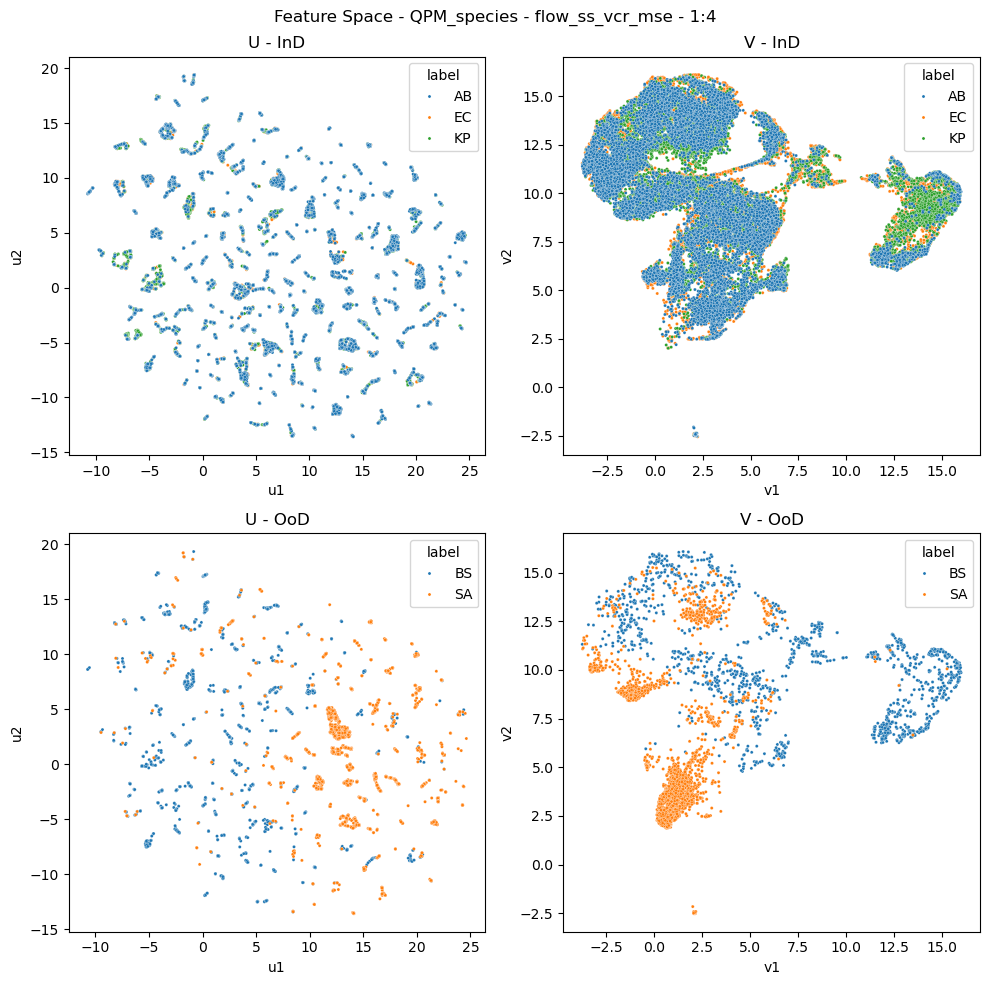

In [12]:
# plot feature space
ind_labels = [config.labels[i] for i in ind_tgt]
df_emb2d = pd.DataFrame()
u1, u2 = ind_e_u2d.T
v1, v2 = ind_e_v2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ind_labels, source="ind"))])

if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]
    u1, u2 = ood_e_u2d.T
    v1, v2 = ood_e_v2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ood_labels, source="ood"))])

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
ax1.set_title("U - InD")
ax2.set_title("V - InD")
ax3.set_title("U - OoD")
ax4.set_title("V - OoD")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="u1", y="u2", hue="label", s=5, ax=ax1)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="v1", y="v2", hue="label", s=5, ax=ax2)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="u1", y="u2", hue="label", s=5, ax=ax3)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="v1", y="v2", hue="label", s=5, ax=ax4)
plt.tight_layout()
plt.show()

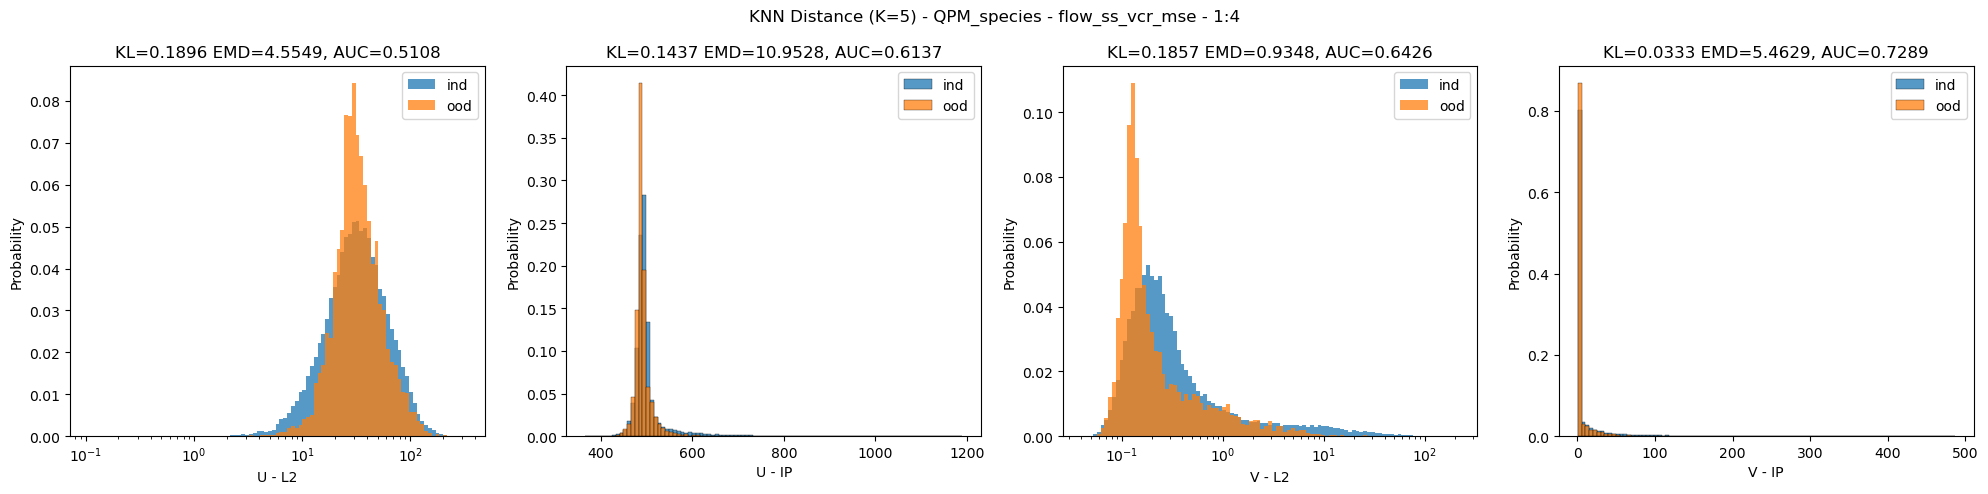

In [13]:
# plot knn distance from ind/ood to val data
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"KNN Distance (K=5) - {dataset_name} - {model_name} - {ood_str}")

def plot_knn_dists(index_fn, ax, idx_data, ind_data, ood_data=None, k=5, scale="linspace"):
    index = index_fn(idx_data.shape[-1])
    index.add(idx_data)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()

plot_knn_dists(faiss.IndexFlatL2, axs[0], val_e_u, ind_e_u, ood_e_u if ood_str else None, scale="logspace")
axs[0].set_xlabel("U - L2")
plot_knn_dists(faiss.IndexFlatIP, axs[1], val_e_u, ind_e_u, ood_e_u if ood_str else None, scale="linspace")
axs[1].set_xlabel("U - IP")
plot_knn_dists(faiss.IndexFlatL2, axs[2], val_e_v, ind_e_v, ood_e_v if ood_str else None, scale="logspace")
axs[2].set_xlabel("V - L2")
plot_knn_dists(faiss.IndexFlatIP, axs[3], val_e_v, ind_e_v, ood_e_v if ood_str else None, scale="linspace")
axs[3].set_xlabel("V - IP")
plt.tight_layout()
plt.show()

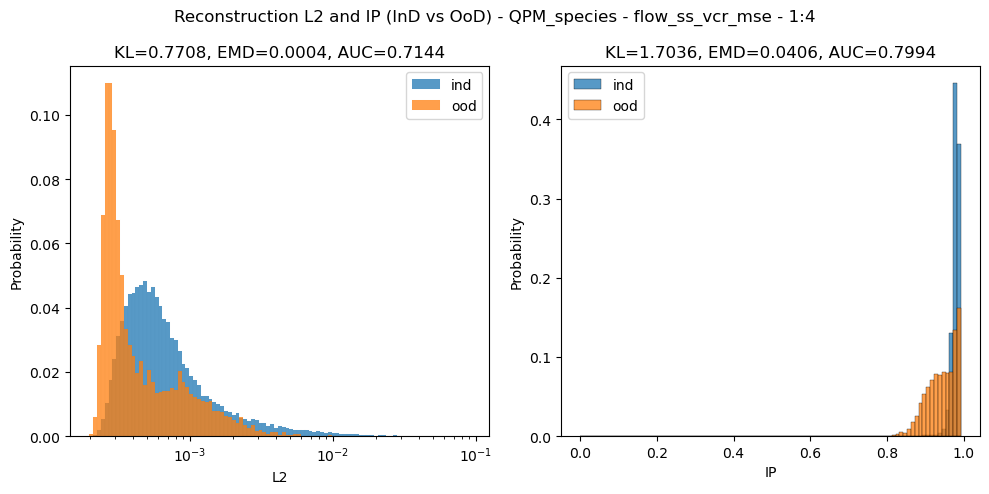

In [14]:
# plot reconstruction-based ood metrics
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# data
_ind_inp = ind_inp.reshape((ind_inp.shape[0], -1))
_ind_rcn = ind_rcn.reshape((ind_inp.shape[0], -1))
# unit vectors
_ind_inp_unit = _ind_inp / (np.linalg.norm(_ind_inp, axis=-1, keepdims=True) + 1e-7)
_ind_rcn_unit = _ind_rcn / (np.linalg.norm(_ind_rcn, axis=-1, keepdims=True) + 1e-7)
# metrics
ind_rcn_l2 = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_rcn_ip = (_ind_inp_unit * _ind_rcn_unit).sum(-1)

if ood_str:
    # data
    _ood_inp = ood_inp.reshape((ood_inp.shape[0], -1))
    _ood_rcn = ood_rcn.reshape((ood_inp.shape[0], -1))
    # unit vectors
    _ood_inp_unit = _ood_inp / (np.linalg.norm(_ood_inp, axis=-1, keepdims=True) + 1e-7)
    _ood_rcn_unit = _ood_rcn / (np.linalg.norm(_ood_rcn, axis=-1, keepdims=True) + 1e-7)
    # metrics
    ood_rcn_l2 = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_rcn_ip = (_ood_inp_unit * _ood_rcn_unit).sum(-1)

def plot_rcn(ind_rcn, ood_rcn, ax, scale="linspace"):
    D = ind_rcn
    if ood_str:
        D = np.concatenate([ind_rcn, ood_rcn], axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(ind_rcn, label="ind", stat="probability", bins=bins, ax=ax)
    if ood_str:
        sns.histplot(ood_rcn, label="ood", stat="probability", bins=bins, ax=ax)
        T = np.concatenate([[0]*ind_rcn.shape[0],[1]*ood_rcn.shape[0]], axis=0)
        Ci = np.histogram(ind_rcn, bins, density=True)[0]
        Co = np.histogram(ood_rcn, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(ood_rcn, ind_rcn)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        ax.set_title(f"KL={kld:.4f}, EMD={emd:.4f}, AUC={auc:.4f}")
    if scale == "logspace":
        ax.set_xscale("log")
    ax.legend()

plot_rcn(ind_rcn_l2, ood_rcn_l2 if ood_str else None, ax1, scale="logspace")
ax1.set_xlabel("L2")
plot_rcn(ind_rcn_ip, ood_rcn_ip if ood_str else None, ax2, scale="linspace")
ax2.set_xlabel("IP")
plt.suptitle(f"Reconstruction L2 and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

In [15]:
# compute vector norms
trn_n_u = np.linalg.norm(trn_e_u, axis=-1)
trn_n_v = np.linalg.norm(trn_e_v, axis=-1)
val_n_u = np.linalg.norm(val_e_u, axis=-1)
val_n_v = np.linalg.norm(val_e_v, axis=-1)
ind_n_u = np.linalg.norm(ind_e_u, axis=-1)
ind_n_v = np.linalg.norm(ind_e_v, axis=-1)
if ood_str:
    ood_n_u = np.linalg.norm(ood_e_u, axis=-1)
    ood_n_v = np.linalg.norm(ood_e_v, axis=-1)
rnd_n_u = np.linalg.norm(rnd_e_u, axis=-1)
rnd_n_v = np.linalg.norm(rnd_e_v, axis=-1)

print(trn_n_u.mean(), trn_n_u.std(), trn_n_v.mean(), trn_n_v.std())
print(val_n_u.mean(), val_n_u.std(), val_n_v.mean(), val_n_v.std())
print(ind_n_u.mean(), ind_n_u.std(), ind_n_v.mean(), ind_n_v.std())
if ood_str:
    print(ood_n_u.mean(), ood_n_u.std(), ood_n_v.mean(), ood_n_v.std())
print(rnd_n_u.mean(), rnd_n_u.std(), rnd_n_v.mean(), rnd_n_v.std())

22.726313 0.6907675 1.4496739 1.6621497
22.684023 0.62525463 1.347364 1.5071396
22.76629 0.7697413 1.5448488 1.837158
22.573174 0.35660487 1.0626931 1.0273799
33.403915 0.8896777 54.168358 0.73959595


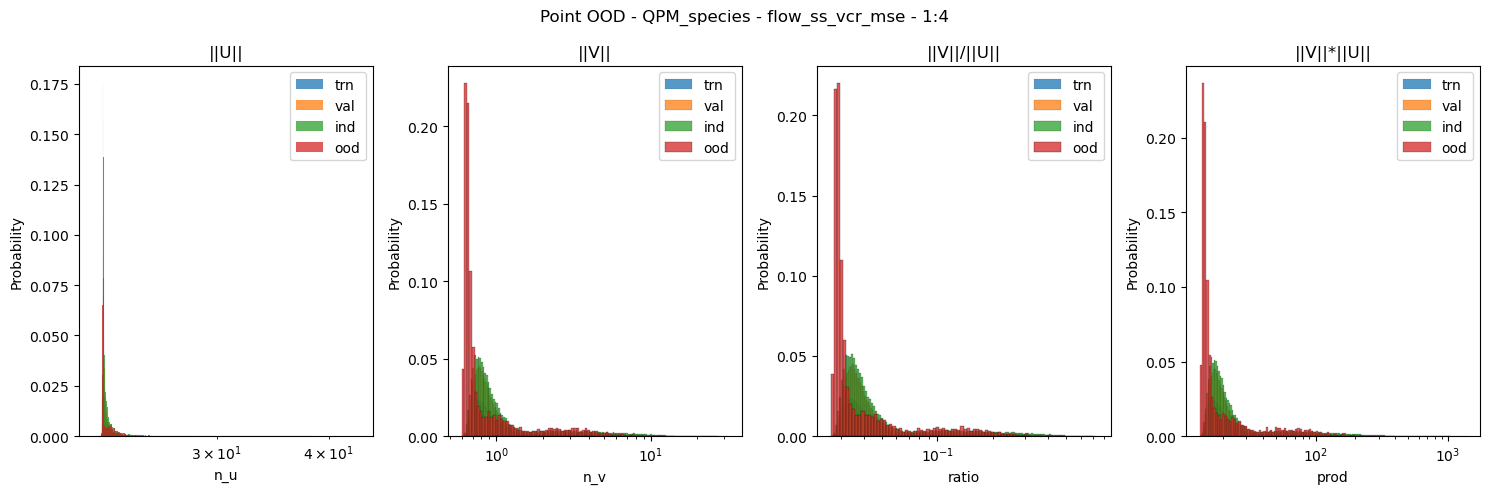

In [16]:
# plot pointwise ood metrics
df_trn = pd.DataFrame(dict(n_u=trn_n_u, n_v=trn_n_v, ratio=trn_n_v/trn_n_u, prod=trn_n_v*trn_n_u, target=trn_tgt))
df_val = pd.DataFrame(dict(n_u=val_n_u, n_v=val_n_v, ratio=val_n_v/val_n_u, prod=val_n_v*val_n_u, target=val_tgt))
df_ind = pd.DataFrame(dict(n_u=ind_n_u, n_v=ind_n_v, ratio=ind_n_v/ind_n_u, prod=ind_n_v*ind_n_u, target=ind_tgt))
if ood_str:
    df_ood = pd.DataFrame(dict(n_u=ood_n_u, n_v=ood_n_v, ratio=ood_n_v/ood_n_u, prod=ood_n_v*ood_n_u, target=ood_tgt))
df_rnd = pd.DataFrame(dict(n_u=rnd_n_u, n_v=rnd_n_v, ratio=rnd_n_v/rnd_n_u, prod=rnd_n_v*rnd_n_u))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (15, 5))
fig.suptitle(f"Point OOD - {dataset_name} - {model_name} - {ood_str}")

def plot_row(prop, ax):
    sns.histplot(data=df_trn, x=prop, log_scale=True, fill=True, label='trn', stat='probability', ax=ax)
    sns.histplot(data=df_val, x=prop, log_scale=True, fill=True, label='val', stat='probability', ax=ax)
    sns.histplot(data=df_ind, x=prop, log_scale=True, fill=True, label='ind', stat='probability', ax=ax)
    if ood_str:
        sns.histplot(data=df_ood, x=prop, log_scale=True, fill=True, label='ood', stat='probability', ax=ax)
    # sns.histplot(data=df_rnd, x=prop, log_scale=True, fill=True, label='rnd', stat='probability', ax=ax)
    ax.legend()

plot_row("n_u", ax1)
plot_row("n_v", ax2)
plot_row("ratio", ax3)
plot_row("prod", ax4)
ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
ax3.title.set_text('||V||/||U||')
ax4.title.set_text('||V||*||U||')

plt.tight_layout()
plt.show()

In [17]:
# organize data by class, aggregate groupwise
if ood_str:
    df_tst = pd.concat([df_ind, df_ood], axis=0)
else:
    df_tst = df_ind

all_targets = list(df_tst['target'].unique())
K = len(all_targets)
N = 128
rw, rh = 2, 0.75
colors = sns.color_palette(n_colors=K)

pointwise_trn = {}
pointwise_val = {}
pointwise_tst = {}

groupwise_trn = {}
groupwise_val = {}
groupwise_tst = {}

for i in range(K):
    _trn = df_trn[df_trn['target'] == all_targets[i]]
    _val = df_val[df_val['target'] == all_targets[i]]
    _tst = df_tst[df_tst['target'] == all_targets[i]]
    pointwise_trn[i] = _trn.copy()
    pointwise_val[i] = _val.copy()
    pointwise_tst[i] = _tst.copy()
    groupwise_trn[i] = _trn.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_val[i] = _val.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_tst[i] = _tst.rolling(N).agg(['mean', 'std']).dropna().copy()


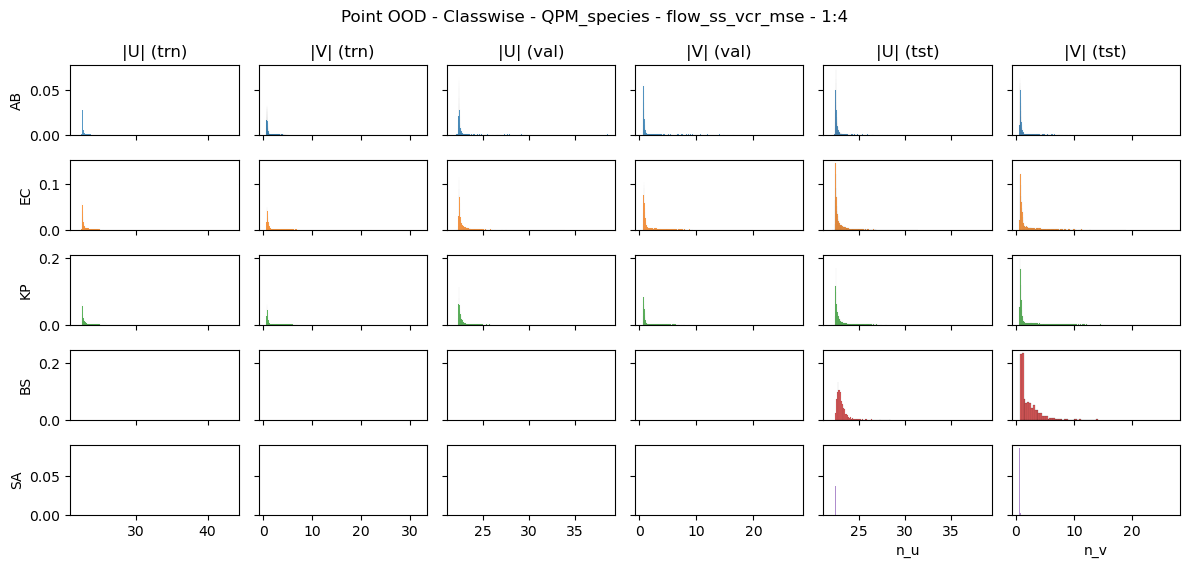

In [18]:
# plot per-class pointwise ood metrics
fig, axs = plt.subplots(K, 6, figsize=(6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Point OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in range(K):
    _trn = pointwise_trn[i]
    _val = pointwise_val[i]
    _tst = pointwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

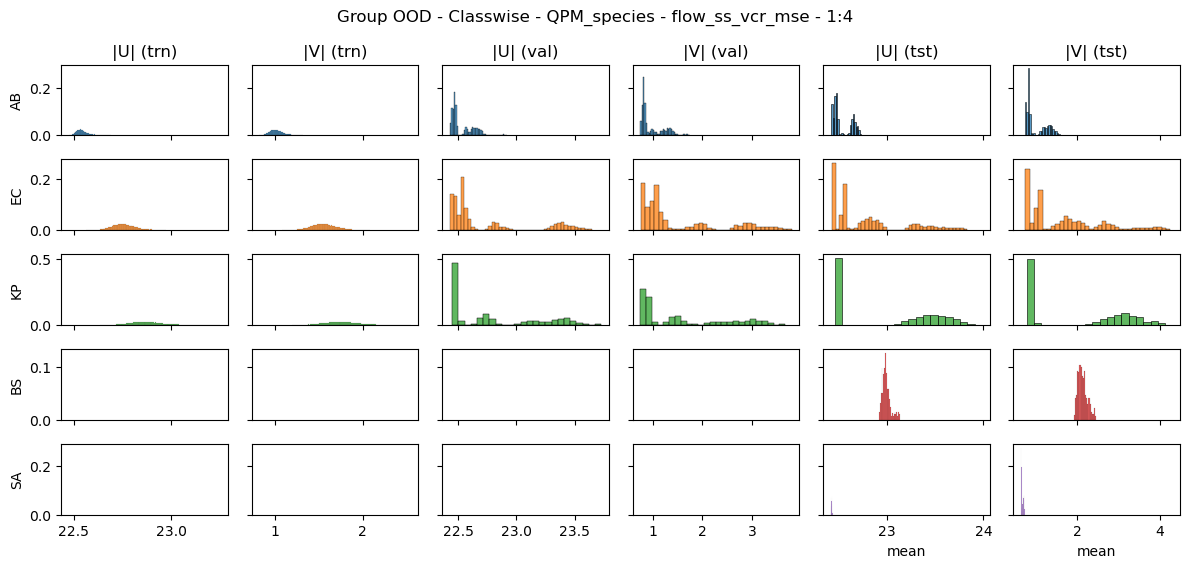

In [19]:
# plot per-class groupwise ood metrics
fig, axs = plt.subplots(K, 6, figsize = (6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Group OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in all_targets:
    _trn = groupwise_trn[i]
    _val = groupwise_val[i]
    _tst = groupwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()